In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

start_time = time.time()

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
sns.set(font_scale=1.6)

In [4]:
print (tf.__version__)

2.6.0


### Define PINN neural network

In [5]:
def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(1))
    
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    
    model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))
    
    return model

In [6]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r, model):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = model
        
        self.iter = 0
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1 + loss_2 + loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        return loss, g, g_u, g_r
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
            if i%10000 == 0:
                self.weights_log.append(PINN_solver.model.get_weights())
                self.gradients_log.append([grad_theta, g_u, g_r])

### Generate training data

In [8]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 5000                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([60000.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [9]:
N = 50000

### Train PINN without PCGrad

In [10]:
PINN_solver = PINN(x_u, y_u, x_r, init_model())
initial_weights = PINN_solver.model.get_weights()

In [11]:
optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver.train(N=N*2, optimizer=optim, method = 'original')

Iteration 00000: loss = 0.3108814,5.3529483e-09
Iteration 00005: loss = 0.1549211,4.6981725e-09
Iteration 00010: loss = 0.054250892,5.035244e-09
Iteration 00015: loss = 0.016276916,5.9040635e-09
Iteration 00020: loss = 0.005566288,6.743946e-09
Iteration 00025: loss = 0.0024359932,7.359234e-09
Iteration 00030: loss = 0.0013419633,7.7722255e-09
Iteration 00035: loss = 0.0008823997,8.043897e-09
Iteration 00040: loss = 0.0006581627,8.223413e-09
Iteration 00045: loss = 0.0005352322,8.344002e-09
Iteration 00050: loss = 0.0004612557,8.427121e-09
Iteration 00055: loss = 0.00041304846,8.4864595e-09
Iteration 00060: loss = 0.0003792852,8.530727e-09
Iteration 00065: loss = 0.0003540154,8.565456e-09
Iteration 00070: loss = 0.00033394035,8.594148e-09
Iteration 00075: loss = 0.00031716845,8.619022e-09
Iteration 00080: loss = 0.00030257608,8.641474e-09
Iteration 00085: loss = 0.00028949775,8.662376e-09
Iteration 00090: loss = 0.00027752787,8.682267e-09
Iteration 00095: loss = 0.0002664063,8.701488e-0

Iteration 00825: loss = 1.3734698e-05,1.0077462e-08
Iteration 00830: loss = 1.3582084e-05,1.0082438e-08
Iteration 00835: loss = 1.3431665e-05,1.0087387e-08
Iteration 00840: loss = 1.3283837e-05,1.009231e-08
Iteration 00845: loss = 1.31377465e-05,1.0097203e-08
Iteration 00850: loss = 1.2994979e-05,1.0102073e-08
Iteration 00855: loss = 1.28536785e-05,1.0106918e-08
Iteration 00860: loss = 1.2714638e-05,1.0111737e-08
Iteration 00865: loss = 1.2578011e-05,1.011653e-08
Iteration 00870: loss = 1.2443175e-05,1.0121299e-08
Iteration 00875: loss = 1.2310891e-05,1.0126044e-08
Iteration 00880: loss = 1.2179941e-05,1.0130764e-08
Iteration 00885: loss = 1.2051697e-05,1.0135459e-08
Iteration 00890: loss = 1.1925126e-05,1.0140132e-08
Iteration 00895: loss = 1.1800602e-05,1.0144781e-08
Iteration 00900: loss = 1.167753e-05,1.0149405e-08
Iteration 00905: loss = 1.1556641e-05,1.0154007e-08
Iteration 00910: loss = 1.1437524e-05,1.0158587e-08
Iteration 00915: loss = 1.1319782e-05,1.0163144e-08
Iteration 009

Iteration 01620: loss = 3.6459007e-06,1.0651493e-08
Iteration 01625: loss = 3.6225267e-06,1.0654205e-08
Iteration 01630: loss = 3.5993783e-06,1.0656908e-08
Iteration 01635: loss = 3.576238e-06,1.0659605e-08
Iteration 01640: loss = 3.5534304e-06,1.0662294e-08
Iteration 01645: loss = 3.5307373e-06,1.0664975e-08
Iteration 01650: loss = 3.5085802e-06,1.0667652e-08
Iteration 01655: loss = 3.4862196e-06,1.0670318e-08
Iteration 01660: loss = 3.4642835e-06,1.0672981e-08
Iteration 01665: loss = 3.4424627e-06,1.0675632e-08
Iteration 01670: loss = 3.4206416e-06,1.0678278e-08
Iteration 01675: loss = 3.3992399e-06,1.0680916e-08
Iteration 01680: loss = 3.3781519e-06,1.0683549e-08
Iteration 01685: loss = 3.3569634e-06,1.0686177e-08
Iteration 01690: loss = 3.335984e-06,1.0688793e-08
Iteration 01695: loss = 3.3154138e-06,1.0691407e-08
Iteration 01700: loss = 3.294742e-06,1.069401e-08
Iteration 01705: loss = 3.2742712e-06,1.0696608e-08
Iteration 01710: loss = 3.2542055e-06,1.06992e-08
Iteration 01715: l

Iteration 02425: loss = 1.5071596e-06,1.1016093e-08
Iteration 02430: loss = 1.5000815e-06,1.1018016e-08
Iteration 02435: loss = 1.4928936e-06,1.1019934e-08
Iteration 02440: loss = 1.4857302e-06,1.1021849e-08
Iteration 02445: loss = 1.4787967e-06,1.1023764e-08
Iteration 02450: loss = 1.4718235e-06,1.1025672e-08
Iteration 02455: loss = 1.4650082e-06,1.1027578e-08
Iteration 02460: loss = 1.4580854e-06,1.1029481e-08
Iteration 02465: loss = 1.4511862e-06,1.1031383e-08
Iteration 02470: loss = 1.4443776e-06,1.1033281e-08
Iteration 02475: loss = 1.4377969e-06,1.1035174e-08
Iteration 02480: loss = 1.430972e-06,1.1037065e-08
Iteration 02485: loss = 1.4241714e-06,1.1038955e-08
Iteration 02490: loss = 1.4177289e-06,1.1040838e-08
Iteration 02495: loss = 1.4109743e-06,1.10427205e-08
Iteration 02500: loss = 1.4045135e-06,1.1044599e-08
Iteration 02505: loss = 1.3980734e-06,1.1046474e-08
Iteration 02510: loss = 1.3913929e-06,1.1048348e-08
Iteration 02515: loss = 1.3850653e-06,1.1050217e-08
Iteration 02

Iteration 03225: loss = 7.573549e-07,1.12905685e-08
Iteration 03230: loss = 7.544047e-07,1.1292114e-08
Iteration 03235: loss = 7.515598e-07,1.1293658e-08
Iteration 03240: loss = 7.4853e-07,1.1295198e-08
Iteration 03245: loss = 7.456065e-07,1.1296739e-08
Iteration 03250: loss = 7.4269036e-07,1.1298275e-08
Iteration 03255: loss = 7.396875e-07,1.12998135e-08
Iteration 03260: loss = 7.368842e-07,1.1301347e-08
Iteration 03265: loss = 7.3399514e-07,1.130288e-08
Iteration 03270: loss = 7.3116115e-07,1.1304413e-08
Iteration 03275: loss = 7.2838384e-07,1.1305941e-08
Iteration 03280: loss = 7.255185e-07,1.130747e-08
Iteration 03285: loss = 7.227568e-07,1.1308996e-08
Iteration 03290: loss = 7.1990803e-07,1.13105205e-08
Iteration 03295: loss = 7.170684e-07,1.1312045e-08
Iteration 03300: loss = 7.1433027e-07,1.1313567e-08
Iteration 03305: loss = 7.115068e-07,1.1315087e-08
Iteration 03310: loss = 7.0878576e-07,1.1316604e-08
Iteration 03315: loss = 7.0597775e-07,1.13181216e-08
Iteration 03320: loss =

Iteration 04020: loss = 4.2167702e-07,1.1517928e-08
Iteration 04025: loss = 4.2016623e-07,1.15192575e-08
Iteration 04030: loss = 4.1873264e-07,1.1520587e-08
Iteration 04035: loss = 4.1730232e-07,1.1521916e-08
Iteration 04040: loss = 4.158758e-07,1.1523243e-08
Iteration 04045: loss = 4.1438045e-07,1.1524568e-08
Iteration 04050: loss = 4.1296107e-07,1.1525895e-08
Iteration 04055: loss = 4.1147322e-07,1.1527218e-08
Iteration 04060: loss = 4.1013251e-07,1.1528543e-08
Iteration 04065: loss = 4.0872374e-07,1.1529865e-08
Iteration 04070: loss = 4.0724674e-07,1.1531188e-08
Iteration 04075: loss = 4.05917e-07,1.1532506e-08
Iteration 04080: loss = 4.0451883e-07,1.1533828e-08
Iteration 04085: loss = 4.0308836e-07,1.1535144e-08
Iteration 04090: loss = 4.016973e-07,1.1536464e-08
Iteration 04095: loss = 4.0038046e-07,1.15377805e-08
Iteration 04100: loss = 3.9899612e-07,1.1539094e-08
Iteration 04105: loss = 3.9761503e-07,1.154041e-08
Iteration 04110: loss = 3.9623774e-07,1.1541725e-08
Iteration 04115

Iteration 04820: loss = 2.4786672e-07,1.1719256e-08
Iteration 04825: loss = 2.47099e-07,1.17204495e-08
Iteration 04830: loss = 2.4627758e-07,1.1721645e-08
Iteration 04835: loss = 2.4551358e-07,1.1722838e-08
Iteration 04840: loss = 2.447514e-07,1.172403e-08
Iteration 04845: loss = 2.4399083e-07,1.172522e-08
Iteration 04850: loss = 2.431765e-07,1.1726414e-08
Iteration 04855: loss = 2.4241965e-07,1.1727602e-08
Iteration 04860: loss = 2.4166425e-07,1.1728792e-08
Iteration 04865: loss = 2.4091057e-07,1.1729979e-08
Iteration 04870: loss = 2.4015858e-07,1.1731168e-08
Iteration 04875: loss = 2.3935362e-07,1.1732354e-08
Iteration 04880: loss = 2.386051e-07,1.1733539e-08
Iteration 04885: loss = 2.3785856e-07,1.1734723e-08
Iteration 04890: loss = 2.371133e-07,1.173591e-08
Iteration 04895: loss = 2.3637006e-07,1.1737095e-08
Iteration 04900: loss = 2.3562815e-07,1.173828e-08
Iteration 04905: loss = 2.3488805e-07,1.1739462e-08
Iteration 04910: loss = 2.3414971e-07,1.1740646e-08
Iteration 04915: loss

Iteration 05620: loss = 1.512309e-07,1.1902423e-08
Iteration 05625: loss = 1.5072969e-07,1.19035235e-08
Iteration 05630: loss = 1.5031681e-07,1.1904625e-08
Iteration 05635: loss = 1.4986126e-07,1.1905723e-08
Iteration 05640: loss = 1.4940663e-07,1.1906821e-08
Iteration 05645: loss = 1.4895298e-07,1.190792e-08
Iteration 05650: loss = 1.4850018e-07,1.19090195e-08
Iteration 05655: loss = 1.4804849e-07,1.1910116e-08
Iteration 05660: loss = 1.4759794e-07,1.1911214e-08
Iteration 05665: loss = 1.4719114e-07,1.1912309e-08
Iteration 05670: loss = 1.4674204e-07,1.19134045e-08
Iteration 05675: loss = 1.4629411e-07,1.1914501e-08
Iteration 05680: loss = 1.4584727e-07,1.19155965e-08
Iteration 05685: loss = 1.4540119e-07,1.1916692e-08
Iteration 05690: loss = 1.450414e-07,1.1917784e-08
Iteration 05695: loss = 1.4459711e-07,1.1918879e-08
Iteration 05700: loss = 1.4415387e-07,1.191997e-08
Iteration 05705: loss = 1.4371143e-07,1.19210615e-08
Iteration 05710: loss = 1.4331228e-07,1.1922155e-08
Iteration 0

Iteration 06410: loss = 9.5099615e-08,1.20705845e-08
Iteration 06415: loss = 9.486964e-08,1.2071618e-08
Iteration 06420: loss = 9.460545e-08,1.2072649e-08
Iteration 06425: loss = 9.430746e-08,1.2073675e-08
Iteration 06430: loss = 9.404431e-08,1.20747075e-08
Iteration 06435: loss = 9.378187e-08,1.2075738e-08
Iteration 06440: loss = 9.348556e-08,1.2076766e-08
Iteration 06445: loss = 9.3224095e-08,1.2077793e-08
Iteration 06450: loss = 9.296317e-08,1.2078824e-08
Iteration 06455: loss = 9.270273e-08,1.2079852e-08
Iteration 06460: loss = 9.240876e-08,1.2080877e-08
Iteration 06465: loss = 9.214935e-08,1.2081907e-08
Iteration 06470: loss = 9.192456e-08,1.2082934e-08
Iteration 06475: loss = 9.163216e-08,1.2083961e-08
Iteration 06480: loss = 9.137444e-08,1.2084986e-08
Iteration 06485: loss = 9.111708e-08,1.208601e-08
Iteration 06490: loss = 9.0860254e-08,1.2087036e-08
Iteration 06495: loss = 9.057012e-08,1.208806e-08
Iteration 06500: loss = 9.031453e-08,1.2089086e-08
Iteration 06505: loss = 9.00

Iteration 07210: loss = 6.0510416e-08,1.2230929e-08
Iteration 07215: loss = 6.0343645e-08,1.22319035e-08
Iteration 07220: loss = 6.020464e-08,1.223288e-08
Iteration 07225: loss = 6.003849e-08,1.2233853e-08
Iteration 07230: loss = 5.984517e-08,1.2234829e-08
Iteration 07235: loss = 5.967963e-08,1.2235802e-08
Iteration 07240: loss = 5.95145e-08,1.2236773e-08
Iteration 07245: loss = 5.937692e-08,1.2237746e-08
Iteration 07250: loss = 5.91851e-08,1.2238719e-08
Iteration 07255: loss = 5.9020824e-08,1.2239691e-08
Iteration 07260: loss = 5.885693e-08,1.2240665e-08
Iteration 07265: loss = 5.8720403e-08,1.2241635e-08
Iteration 07270: loss = 5.855711e-08,1.2242606e-08
Iteration 07275: loss = 5.836698e-08,1.2243577e-08
Iteration 07280: loss = 5.8204293e-08,1.2244546e-08
Iteration 07285: loss = 5.806895e-08,1.2245517e-08
Iteration 07290: loss = 5.790686e-08,1.22464865e-08
Iteration 07295: loss = 5.7745055e-08,1.2247456e-08
Iteration 07300: loss = 5.7556694e-08,1.2248424e-08
Iteration 07305: loss = 5

Iteration 08015: loss = 3.893714e-08,1.2383818e-08
Iteration 08020: loss = 3.881335e-08,1.2384743e-08
Iteration 08025: loss = 3.8711804e-08,1.2385668e-08
Iteration 08030: loss = 3.8588365e-08,1.2386594e-08
Iteration 08035: loss = 3.8509253e-08,1.2387516e-08
Iteration 08040: loss = 3.840826e-08,1.23884405e-08
Iteration 08045: loss = 3.8285524e-08,1.2389361e-08
Iteration 08050: loss = 3.818497e-08,1.2390286e-08
Iteration 08055: loss = 3.8084508e-08,1.239121e-08
Iteration 08060: loss = 3.798431e-08,1.239213e-08
Iteration 08065: loss = 3.7884316e-08,1.2393055e-08
Iteration 08070: loss = 3.776265e-08,1.2393977e-08
Iteration 08075: loss = 3.7684742e-08,1.23948976e-08
Iteration 08080: loss = 3.756357e-08,1.239582e-08
Iteration 08085: loss = 3.7464293e-08,1.2396742e-08
Iteration 08090: loss = 3.736518e-08,1.2397662e-08
Iteration 08095: loss = 3.7266272e-08,1.2398582e-08
Iteration 08100: loss = 3.7167567e-08,1.2399503e-08
Iteration 08105: loss = 3.7069018e-08,1.2400424e-08
Iteration 08110: loss

Iteration 08815: loss = 2.5339816e-08,1.2528008e-08
Iteration 08820: loss = 2.5281585e-08,1.2528883e-08
Iteration 08825: loss = 2.5205635e-08,1.2529759e-08
Iteration 08830: loss = 2.514763e-08,1.2530634e-08
Iteration 08835: loss = 2.5071968e-08,1.253151e-08
Iteration 08840: loss = 2.5014124e-08,1.2532385e-08
Iteration 08845: loss = 2.4956464e-08,1.25332615e-08
Iteration 08850: loss = 2.4863466e-08,1.2534136e-08
Iteration 08855: loss = 2.4806026e-08,1.253501e-08
Iteration 08860: loss = 2.4748658e-08,1.2535885e-08
Iteration 08865: loss = 2.467378e-08,1.2536758e-08
Iteration 08870: loss = 2.461664e-08,1.2537633e-08
Iteration 08875: loss = 2.4559602e-08,1.2538506e-08
Iteration 08880: loss = 2.4485098e-08,1.253938e-08
Iteration 08885: loss = 2.442826e-08,1.2540253e-08
Iteration 08890: loss = 2.4354017e-08,1.25411255e-08
Iteration 08895: loss = 2.4297384e-08,1.25419986e-08
Iteration 08900: loss = 2.4240885e-08,1.2542869e-08
Iteration 08905: loss = 2.414958e-08,1.2543742e-08
Iteration 08910: 

Iteration 09610: loss = 1.6693217e-08,1.2663458e-08
Iteration 09615: loss = 1.6649667e-08,1.2664284e-08
Iteration 09620: loss = 1.660625e-08,1.2665109e-08
Iteration 09625: loss = 1.6562854e-08,1.2665933e-08
Iteration 09630: loss = 1.6519584e-08,1.2666759e-08
Iteration 09635: loss = 1.6476385e-08,1.2667584e-08
Iteration 09640: loss = 1.6433232e-08,1.2668409e-08
Iteration 09645: loss = 1.6404542e-08,1.2669233e-08
Iteration 09650: loss = 1.6361522e-08,1.2670056e-08
Iteration 09655: loss = 1.6318609e-08,1.26708795e-08
Iteration 09660: loss = 1.6261465e-08,1.2671703e-08
Iteration 09665: loss = 1.6218694e-08,1.2672526e-08
Iteration 09670: loss = 1.6176028e-08,1.2673348e-08
Iteration 09675: loss = 1.6133434e-08,1.2674169e-08
Iteration 09680: loss = 1.6090898e-08,1.267499e-08
Iteration 09685: loss = 1.606265e-08,1.267581e-08
Iteration 09690: loss = 1.602026e-08,1.2676633e-08
Iteration 09695: loss = 1.597794e-08,1.2677455e-08
Iteration 09700: loss = 1.5935703e-08,1.2678273e-08
Iteration 09705: 

Iteration 10405: loss = 1.1093509e-08,1.2790377e-08
Iteration 10410: loss = 1.10604175e-08,1.2791145e-08
Iteration 10415: loss = 1.10273985e-08,1.27919115e-08
Iteration 10420: loss = 1.09944365e-08,1.2792679e-08
Iteration 10425: loss = 1.0985034e-08,1.2793445e-08
Iteration 10430: loss = 1.095215e-08,1.2794211e-08
Iteration 10435: loss = 1.091933e-08,1.27949775e-08
Iteration 10440: loss = 1.0898295e-08,1.2795743e-08
Iteration 10445: loss = 1.0865588e-08,1.2796505e-08
Iteration 10450: loss = 1.0832945e-08,1.2797271e-08
Iteration 10455: loss = 1.0812028e-08,1.2798034e-08
Iteration 10460: loss = 1.0791138e-08,1.27988e-08
Iteration 10465: loss = 1.0758634e-08,1.2799561e-08
Iteration 10470: loss = 1.0726204e-08,1.2800326e-08
Iteration 10475: loss = 1.0705437e-08,1.2801087e-08
Iteration 10480: loss = 1.0673105e-08,1.280185e-08
Iteration 10485: loss = 1.0640842e-08,1.2802611e-08
Iteration 10490: loss = 1.0620216e-08,1.2803374e-08
Iteration 10495: loss = 1.0599588e-08,1.2804134e-08
Iteration 10

Iteration 11210: loss = 7.3840227e-09,1.2908429e-08
Iteration 11215: loss = 7.368211e-09,1.2909126e-08
Iteration 11220: loss = 7.3524276e-09,1.2909819e-08
Iteration 11225: loss = 7.3270816e-09,1.29105135e-08
Iteration 11230: loss = 7.3209385e-09,1.2911209e-08
Iteration 11235: loss = 7.295652e-09,1.2911901e-08
Iteration 11240: loss = 7.279974e-09,1.2912592e-08
Iteration 11245: loss = 7.25478e-09,1.29132856e-08
Iteration 11250: loss = 7.239168e-09,1.2913977e-08
Iteration 11255: loss = 7.2235795e-09,1.2914667e-08
Iteration 11260: loss = 7.198503e-09,1.2915359e-08
Iteration 11265: loss = 7.19248e-09,1.2916049e-08
Iteration 11270: loss = 7.1674715e-09,1.2916737e-08
Iteration 11275: loss = 7.1519928e-09,1.2917427e-08
Iteration 11280: loss = 7.1365522e-09,1.2918116e-08
Iteration 11285: loss = 7.121122e-09,1.2918805e-08
Iteration 11290: loss = 7.0962662e-09,1.2919491e-08
Iteration 11295: loss = 7.08091e-09,1.2920177e-08
Iteration 11300: loss = 7.065566e-09,1.2920864e-08
Iteration 11305: loss =

Iteration 12010: loss = 4.9792352e-09,1.3012663e-08
Iteration 12015: loss = 4.9751794e-09,1.3013267e-08
Iteration 12020: loss = 4.9553317e-09,1.3013871e-08
Iteration 12025: loss = 4.943401e-09,1.3014472e-08
Iteration 12030: loss = 4.931494e-09,1.3015073e-08
Iteration 12035: loss = 4.919609e-09,1.3015675e-08
Iteration 12040: loss = 4.907742e-09,1.3016274e-08
Iteration 12045: loss = 4.895897e-09,1.3016873e-08
Iteration 12050: loss = 4.884071e-09,1.3017472e-08
Iteration 12055: loss = 4.8722657e-09,1.3018069e-08
Iteration 12060: loss = 4.860476e-09,1.3018666e-08
Iteration 12065: loss = 4.848712e-09,1.3019266e-08
Iteration 12070: loss = 4.8369677e-09,1.3019858e-08
Iteration 12075: loss = 4.8252375e-09,1.3020454e-08
Iteration 12080: loss = 4.8135296e-09,1.3021048e-08
Iteration 12085: loss = 4.8018376e-09,1.3021642e-08
Iteration 12090: loss = 4.7901705e-09,1.30222375e-08
Iteration 12095: loss = 4.778523e-09,1.3022827e-08
Iteration 12100: loss = 4.7668935e-09,1.302342e-08
Iteration 12105: loss

Iteration 12810: loss = 3.3930938e-09,1.3100088e-08
Iteration 12815: loss = 3.3838898e-09,1.31005695e-08
Iteration 12820: loss = 3.3812144e-09,1.3101053e-08
Iteration 12825: loss = 3.372036e-09,1.3101536e-08
Iteration 12830: loss = 3.3628735e-09,1.3102016e-08
Iteration 12835: loss = 3.353722e-09,1.3102497e-08
Iteration 12840: loss = 3.344595e-09,1.3102976e-08
Iteration 12845: loss = 3.3354792e-09,1.3103454e-08
Iteration 12850: loss = 3.3328424e-09,1.3103934e-08
Iteration 12855: loss = 3.3172964e-09,1.3104409e-08
Iteration 12860: loss = 3.3146768e-09,1.3104885e-08
Iteration 12865: loss = 3.312066e-09,1.3105358e-08
Iteration 12870: loss = 3.2965783e-09,1.3105833e-08
Iteration 12875: loss = 3.293979e-09,1.3106307e-08
Iteration 12880: loss = 3.2785374e-09,1.310678e-08
Iteration 12885: loss = 3.2759522e-09,1.310725e-08
Iteration 12890: loss = 3.2669671e-09,1.3107721e-08
Iteration 12895: loss = 3.257995e-09,1.3108192e-08
Iteration 12900: loss = 3.2554288e-09,1.3108661e-08
Iteration 12905: lo

Iteration 13610: loss = 2.3422857e-09,1.31656215e-08
Iteration 13615: loss = 2.3405085e-09,1.3165948e-08
Iteration 13620: loss = 2.3333198e-09,1.3166274e-08
Iteration 13625: loss = 2.3261502e-09,1.3166602e-08
Iteration 13630: loss = 2.324387e-09,1.3166925e-08
Iteration 13635: loss = 2.3172306e-09,1.3167249e-08
Iteration 13640: loss = 2.3100941e-09,1.3167572e-08
Iteration 13645: loss = 2.308343e-09,1.31678926e-08
Iteration 13650: loss = 2.3066002e-09,1.3168211e-08
Iteration 13655: loss = 2.2941131e-09,1.3168531e-08
Iteration 13660: loss = 2.2923783e-09,1.3168849e-08
Iteration 13665: loss = 2.290646e-09,1.3169164e-08
Iteration 13670: loss = 2.278212e-09,1.3169483e-08
Iteration 13675: loss = 2.276489e-09,1.3169796e-08
Iteration 13680: loss = 2.2747695e-09,1.317011e-08
Iteration 13685: loss = 2.262391e-09,1.3170422e-08
Iteration 13690: loss = 2.2606792e-09,1.3170734e-08
Iteration 13695: loss = 2.2589763e-09,1.3171046e-08
Iteration 13700: loss = 2.2519544e-09,1.3171352e-08
Iteration 13705: 

Iteration 14410: loss = 1.645713e-09,1.3202779e-08
Iteration 14415: loss = 1.640001e-09,1.3202907e-08
Iteration 14420: loss = 1.6388243e-09,1.32030324e-08
Iteration 14425: loss = 1.6376505e-09,1.3203158e-08
Iteration 14430: loss = 1.6319531e-09,1.3203279e-08
Iteration 14435: loss = 1.6262715e-09,1.32034e-08
Iteration 14440: loss = 1.6251055e-09,1.3203522e-08
Iteration 14445: loss = 1.6239428e-09,1.3203638e-08
Iteration 14450: loss = 1.6182781e-09,1.3203756e-08
Iteration 14455: loss = 1.6126283e-09,1.3203872e-08
Iteration 14460: loss = 1.6114736e-09,1.3203986e-08
Iteration 14465: loss = 1.610324e-09,1.3204099e-08
Iteration 14470: loss = 1.6046878e-09,1.320421e-08
Iteration 14475: loss = 1.5990685e-09,1.3204321e-08
Iteration 14480: loss = 1.5979255e-09,1.320443e-08
Iteration 14485: loss = 1.5967867e-09,1.3204535e-08
Iteration 14490: loss = 1.5867263e-09,1.3204642e-08
Iteration 14495: loss = 1.5855921e-09,1.3204747e-08
Iteration 14500: loss = 1.5844632e-09,1.3204849e-08
Iteration 14505: l

Iteration 15205: loss = 1.1813396e-09,1.3203895e-08
Iteration 15210: loss = 1.1805532e-09,1.3203769e-08
Iteration 15215: loss = 1.1797693e-09,1.3203645e-08
Iteration 15220: loss = 1.1789861e-09,1.32035165e-08
Iteration 15225: loss = 1.1743734e-09,1.3203389e-08
Iteration 15230: loss = 1.1697707e-09,1.3203257e-08
Iteration 15235: loss = 1.1689938e-09,1.3203126e-08
Iteration 15240: loss = 1.1682199e-09,1.3202988e-08
Iteration 15245: loss = 1.1674461e-09,1.3202851e-08
Iteration 15250: loss = 1.1628623e-09,1.3202713e-08
Iteration 15255: loss = 1.1582891e-09,1.3202576e-08
Iteration 15260: loss = 1.1575231e-09,1.3202432e-08
Iteration 15265: loss = 1.156757e-09,1.3202287e-08
Iteration 15270: loss = 1.1559936e-09,1.3202144e-08
Iteration 15275: loss = 1.1514377e-09,1.3201999e-08
Iteration 15280: loss = 1.1468937e-09,1.32018485e-08
Iteration 15285: loss = 1.1461371e-09,1.32017e-08
Iteration 15290: loss = 1.1453818e-09,1.32015465e-08
Iteration 15295: loss = 1.1446272e-09,1.3201394e-08
Iteration 15

Iteration 16005: loss = 8.713323e-10,1.316012e-08
Iteration 16010: loss = 8.708098e-10,1.3159685e-08
Iteration 16015: loss = 8.7029023e-10,1.3159248e-08
Iteration 16020: loss = 8.6648977e-10,1.3158807e-08
Iteration 16025: loss = 8.659713e-10,1.3158367e-08
Iteration 16030: loss = 8.654561e-10,1.3157924e-08
Iteration 16035: loss = 8.6166757e-10,1.3157475e-08
Iteration 16040: loss = 8.611549e-10,1.315703e-08
Iteration 16045: loss = 8.6064195e-10,1.3156578e-08
Iteration 16050: loss = 8.5686797e-10,1.3156127e-08
Iteration 16055: loss = 8.5635654e-10,1.3155671e-08
Iteration 16060: loss = 8.558502e-10,1.3155216e-08
Iteration 16065: loss = 8.520887e-10,1.3154757e-08
Iteration 16070: loss = 8.5158386e-10,1.3154295e-08
Iteration 16075: loss = 8.510798e-10,1.3153833e-08
Iteration 16080: loss = 8.505771e-10,1.3153366e-08
Iteration 16085: loss = 8.468312e-10,1.3152898e-08
Iteration 16090: loss = 8.4632995e-10,1.315243e-08
Iteration 16095: loss = 8.4259555e-10,1.3151958e-08
Iteration 16100: loss = 8

Iteration 16805: loss = 6.64743e-10,1.3061522e-08
Iteration 16810: loss = 6.6440203e-10,1.306071e-08
Iteration 16815: loss = 6.640602e-10,1.3059896e-08
Iteration 16820: loss = 6.6372147e-10,1.305908e-08
Iteration 16825: loss = 6.605254e-10,1.3058261e-08
Iteration 16830: loss = 6.6018746e-10,1.3057439e-08
Iteration 16835: loss = 6.5700306e-10,1.3056616e-08
Iteration 16840: loss = 6.566679e-10,1.305579e-08
Iteration 16845: loss = 6.563328e-10,1.3054958e-08
Iteration 16850: loss = 6.5599887e-10,1.3054127e-08
Iteration 16855: loss = 6.5566547e-10,1.3053292e-08
Iteration 16860: loss = 6.5533395e-10,1.3052455e-08
Iteration 16865: loss = 6.550003e-10,1.3051615e-08
Iteration 16870: loss = 6.51832e-10,1.3050776e-08
Iteration 16875: loss = 6.4867306e-10,1.3049931e-08
Iteration 16880: loss = 6.483449e-10,1.30490845e-08
Iteration 16885: loss = 6.4801636e-10,1.30482345e-08
Iteration 16890: loss = 6.47691e-10,1.3047379e-08
Iteration 16895: loss = 6.4736433e-10,1.3046524e-08
Iteration 16900: loss = 6

Iteration 17605: loss = 5.287114e-10,1.28970115e-08
Iteration 17610: loss = 5.2849386e-10,1.2895745e-08
Iteration 17615: loss = 5.282763e-10,1.2894484e-08
Iteration 17620: loss = 5.280593e-10,1.2893215e-08
Iteration 17625: loss = 5.2530835e-10,1.2891944e-08
Iteration 17630: loss = 5.250937e-10,1.2890673e-08
Iteration 17635: loss = 5.2487864e-10,1.2889396e-08
Iteration 17640: loss = 5.246641e-10,1.2888116e-08
Iteration 17645: loss = 5.2445076e-10,1.2886832e-08
Iteration 17650: loss = 5.217138e-10,1.2885549e-08
Iteration 17655: loss = 5.215025e-10,1.2884258e-08
Iteration 17660: loss = 5.2128996e-10,1.2882966e-08
Iteration 17665: loss = 5.2107835e-10,1.2881673e-08
Iteration 17670: loss = 5.18352e-10,1.2880371e-08
Iteration 17675: loss = 5.18143e-10,1.287907e-08
Iteration 17680: loss = 5.1793453e-10,1.28777655e-08
Iteration 17685: loss = 5.1772614e-10,1.2876456e-08
Iteration 17690: loss = 5.1751886e-10,1.2875144e-08
Iteration 17695: loss = 5.1731136e-10,1.2873829e-08
Iteration 17700: loss 

Iteration 18405: loss = 4.4296578e-10,1.2653571e-08
Iteration 18410: loss = 4.4052728e-10,1.2651772e-08
Iteration 18415: loss = 4.403967e-10,1.2649968e-08
Iteration 18420: loss = 4.37969e-10,1.2648162e-08
Iteration 18425: loss = 4.3783951e-10,1.2646346e-08
Iteration 18430: loss = 4.3771173e-10,1.2644529e-08
Iteration 18435: loss = 4.3758488e-10,1.2642707e-08
Iteration 18440: loss = 4.3745732e-10,1.2640881e-08
Iteration 18445: loss = 4.3733053e-10,1.26390525e-08
Iteration 18450: loss = 4.372053e-10,1.263722e-08
Iteration 18455: loss = 4.370795e-10,1.2635384e-08
Iteration 18460: loss = 4.369535e-10,1.2633546e-08
Iteration 18465: loss = 4.368288e-10,1.2631701e-08
Iteration 18470: loss = 4.3441584e-10,1.26298545e-08
Iteration 18475: loss = 4.3429152e-10,1.2628005e-08
Iteration 18480: loss = 4.3416792e-10,1.2626151e-08
Iteration 18485: loss = 4.3404472e-10,1.2624291e-08
Iteration 18490: loss = 4.339217e-10,1.2622431e-08
Iteration 18495: loss = 4.3379852e-10,1.2620566e-08
Iteration 18500: lo

Iteration 19200: loss = 3.8956105e-10,1.2318082e-08
Iteration 19205: loss = 3.894931e-10,1.2315648e-08
Iteration 19210: loss = 3.894258e-10,1.23132065e-08
Iteration 19215: loss = 3.8935796e-10,1.2310763e-08
Iteration 19220: loss = 3.8929082e-10,1.2308313e-08
Iteration 19225: loss = 3.8707848e-10,1.23058586e-08
Iteration 19230: loss = 3.8487658e-10,1.2303399e-08
Iteration 19235: loss = 3.848127e-10,1.2300931e-08
Iteration 19240: loss = 3.8474993e-10,1.2298458e-08
Iteration 19245: loss = 3.846887e-10,1.22959785e-08
Iteration 19250: loss = 3.846267e-10,1.2293495e-08
Iteration 19255: loss = 3.8456605e-10,1.2291008e-08
Iteration 19260: loss = 3.8450507e-10,1.2288515e-08
Iteration 19265: loss = 3.8444414e-10,1.2286018e-08
Iteration 19270: loss = 3.843835e-10,1.228352e-08
Iteration 19275: loss = 3.843228e-10,1.2281017e-08
Iteration 19280: loss = 3.8426184e-10,1.2278513e-08
Iteration 19285: loss = 3.8420114e-10,1.22760015e-08
Iteration 19290: loss = 3.8414064e-10,1.2273487e-08
Iteration 19295:

Iteration 20000: loss = 3.5988632e-10,1.1870759e-08
Iteration 20005: loss = 3.5987072e-10,1.1867587e-08
Iteration 20010: loss = 3.5985562e-10,1.1864409e-08
Iteration 20015: loss = 3.5983985e-10,1.1861231e-08
Iteration 20020: loss = 3.598252e-10,1.1858043e-08
Iteration 20025: loss = 3.598111e-10,1.1854854e-08
Iteration 20030: loss = 3.597963e-10,1.1851661e-08
Iteration 20035: loss = 3.59782e-10,1.1848463e-08
Iteration 20040: loss = 3.597678e-10,1.1845262e-08
Iteration 20045: loss = 3.5975267e-10,1.18420544e-08
Iteration 20050: loss = 3.597378e-10,1.1838845e-08
Iteration 20055: loss = 3.5972333e-10,1.1835633e-08
Iteration 20060: loss = 3.5970904e-10,1.1832415e-08
Iteration 20065: loss = 3.5969464e-10,1.182919e-08
Iteration 20070: loss = 3.5968026e-10,1.1825966e-08
Iteration 20075: loss = 3.5966596e-10,1.1822734e-08
Iteration 20080: loss = 3.596514e-10,1.1819498e-08
Iteration 20085: loss = 3.5963696e-10,1.1816262e-08
Iteration 20090: loss = 3.596228e-10,1.18130155e-08
Iteration 20095: los

Iteration 20800: loss = 3.5343709e-10,1.13067244e-08
Iteration 20805: loss = 3.5143533e-10,1.1302845e-08
Iteration 20810: loss = 3.5144843e-10,1.1298955e-08
Iteration 20815: loss = 3.5146439e-10,1.1295059e-08
Iteration 20820: loss = 3.5148015e-10,1.1291156e-08
Iteration 20825: loss = 3.5149694e-10,1.1287248e-08
Iteration 20830: loss = 3.5151412e-10,1.1283335e-08
Iteration 20835: loss = 3.5153178e-10,1.12794165e-08
Iteration 20840: loss = 3.5154904e-10,1.1275497e-08
Iteration 20845: loss = 3.515669e-10,1.1271571e-08
Iteration 20850: loss = 3.515842e-10,1.126764e-08
Iteration 20855: loss = 3.5160239e-10,1.1263704e-08
Iteration 20860: loss = 3.516206e-10,1.12597665e-08
Iteration 20865: loss = 3.5163852e-10,1.1255826e-08
Iteration 20870: loss = 3.5165668e-10,1.1251879e-08
Iteration 20875: loss = 3.516737e-10,1.12479315e-08
Iteration 20880: loss = 3.516908e-10,1.1243983e-08
Iteration 20885: loss = 3.517079e-10,1.12400285e-08
Iteration 20890: loss = 3.517244e-10,1.12360725e-08
Iteration 2089

Iteration 21595: loss = 3.544294e-10,1.0641916e-08
Iteration 21600: loss = 3.5444758e-10,1.0637476e-08
Iteration 21605: loss = 3.5446737e-10,1.06330305e-08
Iteration 21610: loss = 3.5448755e-10,1.062858e-08
Iteration 21615: loss = 3.545091e-10,1.0624125e-08
Iteration 21620: loss = 3.545304e-10,1.0619666e-08
Iteration 21625: loss = 3.5455305e-10,1.0615204e-08
Iteration 21630: loss = 3.54575e-10,1.0610737e-08
Iteration 21635: loss = 3.5459746e-10,1.0606267e-08
Iteration 21640: loss = 3.5462008e-10,1.0601795e-08
Iteration 21645: loss = 3.5464287e-10,1.059732e-08
Iteration 21650: loss = 3.5466552e-10,1.0592843e-08
Iteration 21655: loss = 3.5468795e-10,1.0588362e-08
Iteration 21660: loss = 3.547109e-10,1.0583878e-08
Iteration 21665: loss = 3.5473288e-10,1.0579395e-08
Iteration 21670: loss = 3.5475298e-10,1.0574912e-08
Iteration 21675: loss = 3.5477318e-10,1.05704245e-08
Iteration 21680: loss = 3.547936e-10,1.05659375e-08
Iteration 21685: loss = 3.548136e-10,1.0561449e-08
Iteration 21690: lo

Iteration 22400: loss = 3.570554e-10,9.897793e-09
Iteration 22405: loss = 3.5706482e-10,9.893041e-09
Iteration 22410: loss = 3.570739e-10,9.888289e-09
Iteration 22415: loss = 3.5708358e-10,9.883535e-09
Iteration 22420: loss = 3.570925e-10,9.87878e-09
Iteration 22425: loss = 3.5710193e-10,9.874023e-09
Iteration 22430: loss = 3.5711098e-10,9.869266e-09
Iteration 22435: loss = 3.5712022e-10,9.864506e-09
Iteration 22440: loss = 3.5712955e-10,9.859747e-09
Iteration 22445: loss = 3.571378e-10,9.854986e-09
Iteration 22450: loss = 3.5714776e-10,9.850225e-09
Iteration 22455: loss = 3.571569e-10,9.84546e-09
Iteration 22460: loss = 3.5716533e-10,9.840697e-09
Iteration 22465: loss = 3.571743e-10,9.835932e-09
Iteration 22470: loss = 3.5718326e-10,9.831165e-09
Iteration 22475: loss = 3.571918e-10,9.826399e-09
Iteration 22480: loss = 3.5720113e-10,9.8216315e-09
Iteration 22485: loss = 3.5720918e-10,9.816862e-09
Iteration 22490: loss = 3.5721834e-10,9.812092e-09
Iteration 22495: loss = 3.572267e-10,9.

Iteration 23225: loss = 3.5738223e-10,9.107601e-09
Iteration 23230: loss = 3.5737424e-10,9.102832e-09
Iteration 23235: loss = 3.5736544e-10,9.098061e-09
Iteration 23240: loss = 3.5735648e-10,9.093293e-09
Iteration 23245: loss = 3.57348e-10,9.088525e-09
Iteration 23250: loss = 3.5733858e-10,9.083758e-09
Iteration 23255: loss = 3.573305e-10,9.078992e-09
Iteration 23260: loss = 3.573211e-10,9.074228e-09
Iteration 23265: loss = 3.5731126e-10,9.069465e-09
Iteration 23270: loss = 3.5730188e-10,9.0647e-09
Iteration 23275: loss = 3.5729184e-10,9.0599395e-09
Iteration 23280: loss = 3.5728212e-10,9.055178e-09
Iteration 23285: loss = 3.5727268e-10,9.05042e-09
Iteration 23290: loss = 3.5726186e-10,9.04566e-09
Iteration 23295: loss = 3.5725115e-10,9.040903e-09
Iteration 23300: loss = 3.572407e-10,9.036148e-09
Iteration 23305: loss = 3.572306e-10,9.031391e-09
Iteration 23310: loss = 3.5721923e-10,9.026637e-09
Iteration 23315: loss = 3.5720837e-10,9.021885e-09
Iteration 23320: loss = 3.5719705e-10,9.

Iteration 24035: loss = 3.5484135e-10,8.352314e-09
Iteration 24040: loss = 3.548292e-10,8.347782e-09
Iteration 24045: loss = 3.548171e-10,8.343252e-09
Iteration 24050: loss = 3.5480427e-10,8.338727e-09
Iteration 24055: loss = 3.5680323e-10,8.334209e-09
Iteration 24060: loss = 3.567773e-10,8.32972e-09
Iteration 24065: loss = 3.5674433e-10,8.325253e-09
Iteration 24070: loss = 3.5670664e-10,8.320799e-09
Iteration 24075: loss = 3.5666634e-10,8.316355e-09
Iteration 24080: loss = 3.5662437e-10,8.3119165e-09
Iteration 24085: loss = 3.565814e-10,8.307484e-09
Iteration 24090: loss = 3.5653747e-10,8.303054e-09
Iteration 24095: loss = 3.5649386e-10,8.298629e-09
Iteration 24100: loss = 3.5644973e-10,8.294205e-09
Iteration 24105: loss = 3.5640568e-10,8.289785e-09
Iteration 24110: loss = 3.563617e-10,8.285367e-09
Iteration 24115: loss = 3.563172e-10,8.280951e-09
Iteration 24120: loss = 3.5627354e-10,8.276539e-09
Iteration 24125: loss = 3.5622974e-10,8.272126e-09
Iteration 24130: loss = 3.5619e-10,8.

Iteration 24855: loss = 3.5258693e-10,7.653312e-09
Iteration 24860: loss = 3.5253409e-10,7.649401e-09
Iteration 24865: loss = 3.5248185e-10,7.6454905e-09
Iteration 24870: loss = 3.5243355e-10,7.641574e-09
Iteration 24875: loss = 3.5238648e-10,7.637659e-09
Iteration 24880: loss = 3.5234016e-10,7.633745e-09
Iteration 24885: loss = 3.5229467e-10,7.629833e-09
Iteration 24890: loss = 3.5224976e-10,7.625927e-09
Iteration 24895: loss = 3.522039e-10,7.622022e-09
Iteration 24900: loss = 3.5215797e-10,7.618121e-09
Iteration 24905: loss = 3.5211298e-10,7.6142275e-09
Iteration 24910: loss = 3.5206696e-10,7.610338e-09
Iteration 24915: loss = 3.520215e-10,7.60645e-09
Iteration 24920: loss = 3.519753e-10,7.602568e-09
Iteration 24925: loss = 3.519284e-10,7.598691e-09
Iteration 24930: loss = 3.51882e-10,7.594818e-09
Iteration 24935: loss = 3.498218e-10,7.59095e-09
Iteration 24940: loss = 3.4978673e-10,7.5870545e-09
Iteration 24945: loss = 3.4976969e-10,7.583119e-09
Iteration 24950: loss = 3.4976247e-10

Iteration 25660: loss = 3.473637e-10,7.0695085e-09
Iteration 25665: loss = 3.473211e-10,7.066271e-09
Iteration 25670: loss = 3.472621e-10,7.063082e-09
Iteration 25675: loss = 3.471902e-10,7.0599304e-09
Iteration 25680: loss = 3.4711103e-10,7.056804e-09
Iteration 25685: loss = 3.4702785e-10,7.0536945e-09
Iteration 25690: loss = 3.469417e-10,7.050594e-09
Iteration 25695: loss = 3.468538e-10,7.0475044e-09
Iteration 25700: loss = 3.4676947e-10,7.044411e-09
Iteration 25705: loss = 3.4669e-10,7.0413066e-09
Iteration 25710: loss = 3.466156e-10,7.0381976e-09
Iteration 25715: loss = 3.445386e-10,7.0350628e-09
Iteration 25720: loss = 3.4449388e-10,7.031884e-09
Iteration 25725: loss = 3.4445957e-10,7.028682e-09
Iteration 25730: loss = 3.4443123e-10,7.025468e-09
Iteration 25735: loss = 3.4440617e-10,7.022251e-09
Iteration 25740: loss = 3.4438186e-10,7.019037e-09
Iteration 25745: loss = 3.443581e-10,7.0158257e-09
Iteration 25750: loss = 3.4433412e-10,7.012621e-09
Iteration 25755: loss = 3.4430883e-

Iteration 26475: loss = 3.371398e-10,6.6012418e-09
Iteration 26480: loss = 3.3709224e-10,6.598767e-09
Iteration 26485: loss = 3.3704628e-10,6.5962933e-09
Iteration 26490: loss = 3.3700057e-10,6.5938206e-09
Iteration 26495: loss = 3.3695483e-10,6.591355e-09
Iteration 26500: loss = 3.3690772e-10,6.5888957e-09
Iteration 26505: loss = 3.368599e-10,6.586445e-09
Iteration 26510: loss = 3.3681072e-10,6.583999e-09
Iteration 26515: loss = 3.367632e-10,6.5815557e-09
Iteration 26520: loss = 3.367225e-10,6.5790973e-09
Iteration 26525: loss = 3.3668554e-10,6.576633e-09
Iteration 26530: loss = 3.3665057e-10,6.5741688e-09
Iteration 26535: loss = 3.366155e-10,6.571709e-09
Iteration 26540: loss = 3.3657968e-10,6.5692545e-09
Iteration 26545: loss = 3.3654246e-10,6.5668093e-09
Iteration 26550: loss = 3.3650394e-10,6.5643704e-09
Iteration 26555: loss = 3.364642e-10,6.5619394e-09
Iteration 26560: loss = 3.3642303e-10,6.559519e-09
Iteration 26565: loss = 3.363798e-10,6.557105e-09
Iteration 26570: loss = 3.3

Iteration 27285: loss = 3.253475e-10,6.2491345e-09
Iteration 27290: loss = 3.2537462e-10,6.247101e-09
Iteration 27295: loss = 3.273852e-10,6.245051e-09
Iteration 27300: loss = 3.273957e-10,6.2430714e-09
Iteration 27305: loss = 3.254109e-10,6.241149e-09
Iteration 27310: loss = 3.2541822e-10,6.239187e-09
Iteration 27315: loss = 3.2543437e-10,6.2372e-09
Iteration 27320: loss = 3.254551e-10,6.2352066e-09
Iteration 27325: loss = 3.25459e-10,6.233262e-09
Iteration 27330: loss = 3.254602e-10,6.231329e-09
Iteration 27335: loss = 3.25467e-10,6.2293837e-09
Iteration 27340: loss = 3.25475e-10,6.227439e-09
Iteration 27345: loss = 3.254825e-10,6.2254997e-09
Iteration 27350: loss = 3.2548805e-10,6.223568e-09
Iteration 27355: loss = 3.254905e-10,6.221649e-09
Iteration 27360: loss = 3.2548966e-10,6.219741e-09
Iteration 27365: loss = 3.2548578e-10,6.217845e-09
Iteration 27370: loss = 3.2547795e-10,6.2159637e-09
Iteration 27375: loss = 3.2546774e-10,6.214093e-09
Iteration 27380: loss = 3.254529e-10,6.21

Iteration 28095: loss = 3.1531636e-10,5.9854304e-09
Iteration 28100: loss = 3.1529768e-10,5.984022e-09
Iteration 28105: loss = 3.1528102e-10,5.9826135e-09
Iteration 28110: loss = 3.1526312e-10,5.981209e-09
Iteration 28115: loss = 3.152436e-10,5.9798126e-09
Iteration 28120: loss = 3.1522152e-10,5.9784253e-09
Iteration 28125: loss = 3.1519642e-10,5.9770473e-09
Iteration 28130: loss = 3.1516878e-10,5.9756813e-09
Iteration 28135: loss = 3.1513803e-10,5.974324e-09
Iteration 28140: loss = 3.151044e-10,5.9729794e-09
Iteration 28145: loss = 3.1506822e-10,5.9716445e-09
Iteration 28150: loss = 3.1502925e-10,5.97032e-09
Iteration 28155: loss = 3.149877e-10,5.969004e-09
Iteration 28160: loss = 3.1494363e-10,5.9676974e-09
Iteration 28165: loss = 3.1489666e-10,5.9664016e-09
Iteration 28170: loss = 3.1484745e-10,5.9651137e-09
Iteration 28175: loss = 3.1479633e-10,5.9638348e-09
Iteration 28180: loss = 3.1474323e-10,5.962564e-09
Iteration 28185: loss = 3.1468764e-10,5.9613012e-09
Iteration 28190: loss 

Iteration 28895: loss = 3.0315503e-10,5.7948997e-09
Iteration 28900: loss = 3.0506864e-10,5.7937926e-09
Iteration 28905: loss = 3.031515e-10,5.7927254e-09
Iteration 28910: loss = 3.050666e-10,5.7916205e-09
Iteration 28915: loss = 3.0314537e-10,5.7905645e-09
Iteration 28920: loss = 3.0506067e-10,5.789463e-09
Iteration 28925: loss = 3.0314878e-10,5.7883875e-09
Iteration 28930: loss = 3.0314473e-10,5.7873164e-09
Iteration 28935: loss = 3.031409e-10,5.7862497e-09
Iteration 28940: loss = 3.050549e-10,5.7851577e-09
Iteration 28945: loss = 3.031385e-10,5.7841016e-09
Iteration 28950: loss = 3.0314132e-10,5.78302e-09
Iteration 28955: loss = 3.0313893e-10,5.7819554e-09
Iteration 28960: loss = 3.05049e-10,5.780882e-09
Iteration 28965: loss = 3.0313127e-10,5.779838e-09
Iteration 28970: loss = 3.0312622e-10,5.7787855e-09
Iteration 28975: loss = 3.031219e-10,5.7777325e-09
Iteration 28980: loss = 3.031165e-10,5.7766867e-09
Iteration 28985: loss = 3.0310834e-10,5.7756475e-09
Iteration 28990: loss = 3.

Iteration 29705: loss = 2.9412833e-10,5.649786e-09
Iteration 29710: loss = 2.941128e-10,5.649004e-09
Iteration 29715: loss = 2.9409947e-10,5.6482143e-09
Iteration 29720: loss = 2.940871e-10,5.6474274e-09
Iteration 29725: loss = 2.9407263e-10,5.646646e-09
Iteration 29730: loss = 2.9405592e-10,5.645871e-09
Iteration 29735: loss = 2.940371e-10,5.6451044e-09
Iteration 29740: loss = 2.940148e-10,5.644349e-09
Iteration 29745: loss = 2.9398994e-10,5.643601e-09
Iteration 29750: loss = 2.9210254e-10,5.6428315e-09
Iteration 29755: loss = 2.939857e-10,5.6419855e-09
Iteration 29760: loss = 2.939807e-10,5.6411884e-09
Iteration 29765: loss = 2.9209998e-10,5.6404037e-09
Iteration 29770: loss = 2.9397654e-10,5.63958e-09
Iteration 29775: loss = 2.9209457e-10,5.6388036e-09
Iteration 29780: loss = 2.93969e-10,5.6379887e-09
Iteration 29785: loss = 2.9396605e-10,5.637192e-09
Iteration 29790: loss = 2.9209124e-10,5.636401e-09
Iteration 29795: loss = 2.939618e-10,5.635599e-09
Iteration 29800: loss = 2.939600

Iteration 30520: loss = 2.8534186e-10,5.540432e-09
Iteration 30525: loss = 2.8528815e-10,5.5399445e-09
Iteration 30530: loss = 2.852326e-10,5.539463e-09
Iteration 30535: loss = 2.8517655e-10,5.538984e-09
Iteration 30540: loss = 2.851183e-10,5.538512e-09
Iteration 30545: loss = 2.850601e-10,5.538041e-09
Iteration 30550: loss = 2.8500027e-10,5.5375744e-09
Iteration 30555: loss = 2.8311123e-10,5.537073e-09
Iteration 30560: loss = 2.8311334e-10,5.5364393e-09
Iteration 30565: loss = 2.8498212e-10,5.5357416e-09
Iteration 30570: loss = 2.8498762e-10,5.5351017e-09
Iteration 30575: loss = 2.8497754e-10,5.534506e-09
Iteration 30580: loss = 2.8311323e-10,5.53394e-09
Iteration 30585: loss = 2.8495795e-10,5.533314e-09
Iteration 30590: loss = 2.849576e-10,5.5326925e-09
Iteration 30595: loss = 2.8495148e-10,5.5320903e-09
Iteration 30600: loss = 2.8310546e-10,5.53148e-09
Iteration 30605: loss = 2.8495054e-10,5.530854e-09
Iteration 30610: loss = 2.8310296e-10,5.530249e-09
Iteration 30615: loss = 2.8309

Iteration 31330: loss = 2.7705827e-10,5.4566662e-09
Iteration 31335: loss = 2.770331e-10,5.4562337e-09
Iteration 31340: loss = 2.7700875e-10,5.4558003e-09
Iteration 31345: loss = 2.7698246e-10,5.4553695e-09
Iteration 31350: loss = 2.7695607e-10,5.454944e-09
Iteration 31355: loss = 2.7692723e-10,5.454523e-09
Iteration 31360: loss = 2.768976e-10,5.4541065e-09
Iteration 31365: loss = 2.7687333e-10,5.4536753e-09
Iteration 31370: loss = 2.768535e-10,5.4532334e-09
Iteration 31375: loss = 2.7683475e-10,5.4527884e-09
Iteration 31380: loss = 2.768166e-10,5.4523426e-09
Iteration 31385: loss = 2.7679628e-10,5.4519047e-09
Iteration 31390: loss = 2.7677435e-10,5.4514695e-09
Iteration 31395: loss = 2.7675032e-10,5.451042e-09
Iteration 31400: loss = 2.7672434e-10,5.4506217e-09
Iteration 31405: loss = 2.7669614e-10,5.4502056e-09
Iteration 31410: loss = 2.7666544e-10,5.449798e-09
Iteration 31415: loss = 2.7663286e-10,5.449395e-09
Iteration 31420: loss = 2.765986e-10,5.4490004e-09
Iteration 31425: loss 

Iteration 32140: loss = 2.6928035e-10,5.389795e-09
Iteration 32145: loss = 2.6927893e-10,5.3893885e-09
Iteration 32150: loss = 2.6927804e-10,5.3889826e-09
Iteration 32155: loss = 2.6928262e-10,5.3885616e-09
Iteration 32160: loss = 2.710791e-10,5.388152e-09
Iteration 32165: loss = 2.6927863e-10,5.3877582e-09
Iteration 32170: loss = 2.6927902e-10,5.3873506e-09
Iteration 32175: loss = 2.6928157e-10,5.3869385e-09
Iteration 32180: loss = 2.692835e-10,5.3865286e-09
Iteration 32185: loss = 2.692833e-10,5.3861235e-09
Iteration 32190: loss = 2.6928096e-10,5.3857248e-09
Iteration 32195: loss = 2.6927596e-10,5.385335e-09
Iteration 32200: loss = 2.692679e-10,5.3849516e-09
Iteration 32205: loss = 2.692566e-10,5.384579e-09
Iteration 32210: loss = 2.692427e-10,5.3842144e-09
Iteration 32215: loss = 2.692262e-10,5.383858e-09
Iteration 32220: loss = 2.692066e-10,5.383508e-09
Iteration 32225: loss = 2.691847e-10,5.383166e-09
Iteration 32230: loss = 2.6916067e-10,5.3828297e-09
Iteration 32235: loss = 2.69

Iteration 32960: loss = 2.630958e-10,5.3354148e-09
Iteration 32965: loss = 2.6308955e-10,5.335088e-09
Iteration 32970: loss = 2.6486416e-10,5.334748e-09
Iteration 32975: loss = 2.6485839e-10,5.334418e-09
Iteration 32980: loss = 2.630728e-10,5.3340994e-09
Iteration 32985: loss = 2.6307018e-10,5.3337637e-09
Iteration 32990: loss = 2.630633e-10,5.333438e-09
Iteration 32995: loss = 2.6483754e-10,5.3331024e-09
Iteration 33000: loss = 2.630541e-10,5.3327787e-09
Iteration 33005: loss = 2.63045e-10,5.3324607e-09
Iteration 33010: loss = 2.6482003e-10,5.3321214e-09
Iteration 33015: loss = 2.6303545e-10,5.331804e-09
Iteration 33020: loss = 2.6480906e-10,5.3314704e-09
Iteration 33025: loss = 2.630249e-10,5.331149e-09
Iteration 33030: loss = 2.6301616e-10,5.3308327e-09
Iteration 33035: loss = 2.6300762e-10,5.330514e-09
Iteration 33040: loss = 2.6300825e-10,5.330173e-09
Iteration 33045: loss = 2.6300045e-10,5.3298557e-09
Iteration 33050: loss = 2.629891e-10,5.329547e-09
Iteration 33055: loss = 2.629

Iteration 33770: loss = 2.579981e-10,5.2875633e-09
Iteration 33775: loss = 2.5798705e-10,5.287291e-09
Iteration 33780: loss = 2.579734e-10,5.2870277e-09
Iteration 33785: loss = 2.5795757e-10,5.2867697e-09
Iteration 33790: loss = 2.5793997e-10,5.286517e-09
Iteration 33795: loss = 2.5791988e-10,5.2862705e-09
Iteration 33800: loss = 2.5789834e-10,5.2860303e-09
Iteration 33805: loss = 2.578751e-10,5.285793e-09
Iteration 33810: loss = 2.5785046e-10,5.2855613e-09
Iteration 33815: loss = 2.578243e-10,5.2853335e-09
Iteration 33820: loss = 2.577971e-10,5.2851057e-09
Iteration 33825: loss = 2.5776759e-10,5.2848863e-09
Iteration 33830: loss = 2.5773803e-10,5.2846687e-09
Iteration 33835: loss = 2.5770838e-10,5.28445e-09
Iteration 33840: loss = 2.576867e-10,5.284211e-09
Iteration 33845: loss = 2.5767088e-10,5.2839555e-09
Iteration 33850: loss = 2.576573e-10,5.283695e-09
Iteration 33855: loss = 2.576441e-10,5.2834324e-09
Iteration 33860: loss = 2.576309e-10,5.283171e-09
Iteration 33865: loss = 2.576

Iteration 34570: loss = 2.539948e-10,5.2479914e-09
Iteration 34575: loss = 2.5398453e-10,5.2477485e-09
Iteration 34580: loss = 2.5397257e-10,5.247509e-09
Iteration 34585: loss = 2.5395816e-10,5.2472764e-09
Iteration 34590: loss = 2.5394206e-10,5.247049e-09
Iteration 34595: loss = 2.5392474e-10,5.246826e-09
Iteration 34600: loss = 2.5390576e-10,5.2466067e-09
Iteration 34605: loss = 2.5388447e-10,5.2463927e-09
Iteration 34610: loss = 2.5386246e-10,5.2461826e-09
Iteration 34615: loss = 2.5383887e-10,5.2459757e-09
Iteration 34620: loss = 2.5381378e-10,5.245774e-09
Iteration 34625: loss = 2.537878e-10,5.2455746e-09
Iteration 34630: loss = 2.5376096e-10,5.245379e-09
Iteration 34635: loss = 2.5373298e-10,5.245184e-09
Iteration 34640: loss = 2.5370453e-10,5.244991e-09
Iteration 34645: loss = 2.5367483e-10,5.244802e-09
Iteration 34650: loss = 2.519059e-10,5.2446163e-09
Iteration 34655: loss = 2.5364985e-10,5.244332e-09
Iteration 34660: loss = 2.5365907e-10,5.244038e-09
Iteration 34665: loss = 2

Iteration 35385: loss = 2.4900024e-10,5.2096167e-09
Iteration 35390: loss = 2.490081e-10,5.209344e-09
Iteration 35395: loss = 2.4901e-10,5.209088e-09
Iteration 35400: loss = 2.490064e-10,5.2088467e-09
Iteration 35405: loss = 2.4900437e-10,5.208601e-09
Iteration 35410: loss = 2.490033e-10,5.2083537e-09
Iteration 35415: loss = 2.490013e-10,5.2081077e-09
Iteration 35420: loss = 2.4899788e-10,5.207866e-09
Iteration 35425: loss = 2.4899285e-10,5.2076294e-09
Iteration 35430: loss = 2.4898575e-10,5.207399e-09
Iteration 35435: loss = 2.4897723e-10,5.207172e-09
Iteration 35440: loss = 2.489664e-10,5.206951e-09
Iteration 35445: loss = 2.4895383e-10,5.2067355e-09
Iteration 35450: loss = 2.4893929e-10,5.206525e-09
Iteration 35455: loss = 2.4892385e-10,5.2063163e-09
Iteration 35460: loss = 2.489066e-10,5.206113e-09
Iteration 35465: loss = 2.488875e-10,5.2059153e-09
Iteration 35470: loss = 2.4886745e-10,5.2057194e-09
Iteration 35475: loss = 2.488465e-10,5.2055276e-09
Iteration 35480: loss = 2.488240

Iteration 36185: loss = 2.4568603e-10,5.1748894e-09
Iteration 36190: loss = 2.4567884e-10,5.1746722e-09
Iteration 36195: loss = 2.456722e-10,5.1744515e-09
Iteration 36200: loss = 2.4566485e-10,5.1742344e-09
Iteration 36205: loss = 2.45657e-10,5.1740185e-09
Iteration 36210: loss = 2.4564775e-10,5.173806e-09
Iteration 36215: loss = 2.4563637e-10,5.1735984e-09
Iteration 36220: loss = 2.456236e-10,5.1733955e-09
Iteration 36225: loss = 2.4560967e-10,5.1731956e-09
Iteration 36230: loss = 2.4559496e-10,5.1730007e-09
Iteration 36235: loss = 2.4557806e-10,5.1728084e-09
Iteration 36240: loss = 2.455601e-10,5.1726206e-09
Iteration 36245: loss = 2.455414e-10,5.172435e-09
Iteration 36250: loss = 2.455217e-10,5.172251e-09
Iteration 36255: loss = 2.4550098e-10,5.17207e-09
Iteration 36260: loss = 2.4547955e-10,5.1718922e-09
Iteration 36265: loss = 2.4545666e-10,5.171718e-09
Iteration 36270: loss = 2.4543298e-10,5.1715454e-09
Iteration 36275: loss = 2.4540892e-10,5.1713744e-09
Iteration 36280: loss = 2

Iteration 37000: loss = 2.4215804e-10,5.141846e-09
Iteration 37005: loss = 2.4215274e-10,5.141632e-09
Iteration 37010: loss = 2.4214641e-10,5.1414215e-09
Iteration 37015: loss = 2.4213906e-10,5.141213e-09
Iteration 37020: loss = 2.421307e-10,5.1410054e-09
Iteration 37025: loss = 2.4211977e-10,5.140806e-09
Iteration 37030: loss = 2.4210847e-10,5.140609e-09
Iteration 37035: loss = 2.4209557e-10,5.140416e-09
Iteration 37040: loss = 2.4208122e-10,5.140226e-09
Iteration 37045: loss = 2.4206623e-10,5.140038e-09
Iteration 37050: loss = 2.4204902e-10,5.1398557e-09
Iteration 37055: loss = 2.4203142e-10,5.1396762e-09
Iteration 37060: loss = 2.42013e-10,5.1394986e-09
Iteration 37065: loss = 2.420101e-10,5.139279e-09
Iteration 37070: loss = 2.4201746e-10,5.139028e-09
Iteration 37075: loss = 2.4031158e-10,5.1388156e-09
Iteration 37080: loss = 2.420187e-10,5.138568e-09
Iteration 37085: loss = 2.4031543e-10,5.138347e-09
Iteration 37090: loss = 2.4202168e-10,5.1381033e-09
Iteration 37095: loss = 2.420

Iteration 37800: loss = 2.3924937e-10,5.1089346e-09
Iteration 37805: loss = 2.3924301e-10,5.1087277e-09
Iteration 37810: loss = 2.3924962e-10,5.108485e-09
Iteration 37815: loss = 2.3925104e-10,5.1082596e-09
Iteration 37820: loss = 2.3925037e-10,5.1080367e-09
Iteration 37825: loss = 2.3925487e-10,5.1077995e-09
Iteration 37830: loss = 2.392547e-10,5.1075766e-09
Iteration 37835: loss = 2.3925775e-10,5.107344e-09
Iteration 37840: loss = 2.3926003e-10,5.107115e-09
Iteration 37845: loss = 2.3756924e-10,5.106889e-09
Iteration 37850: loss = 2.3926713e-10,5.106646e-09
Iteration 37855: loss = 2.3926885e-10,5.1064184e-09
Iteration 37860: loss = 2.3756574e-10,5.1062283e-09
Iteration 37865: loss = 2.3925154e-10,5.1060187e-09
Iteration 37870: loss = 2.3754e-10,5.105851e-09
Iteration 37875: loss = 2.3922256e-10,5.1056497e-09
Iteration 37880: loss = 2.3920932e-10,5.1054623e-09
Iteration 37885: loss = 2.3750524e-10,5.1052744e-09
Iteration 37890: loss = 2.3749236e-10,5.1050866e-09
Iteration 37895: loss 

Iteration 38605: loss = 2.362899e-10,5.076586e-09
Iteration 38610: loss = 2.3628632e-10,5.076374e-09
Iteration 38615: loss = 2.362817e-10,5.076166e-09
Iteration 38620: loss = 2.3627494e-10,5.075961e-09
Iteration 38625: loss = 2.362669e-10,5.0757625e-09
Iteration 38630: loss = 2.3625715e-10,5.0755675e-09
Iteration 38635: loss = 2.3624644e-10,5.075376e-09
Iteration 38640: loss = 2.36235e-10,5.075187e-09
Iteration 38645: loss = 2.3622168e-10,5.0750004e-09
Iteration 38650: loss = 2.3620791e-10,5.0748183e-09
Iteration 38655: loss = 2.361927e-10,5.0746385e-09
Iteration 38660: loss = 2.3617586e-10,5.0744626e-09
Iteration 38665: loss = 2.3615912e-10,5.0742877e-09
Iteration 38670: loss = 2.361411e-10,5.074116e-09
Iteration 38675: loss = 2.3612307e-10,5.073944e-09
Iteration 38680: loss = 2.3610452e-10,5.0737743e-09
Iteration 38685: loss = 2.3608468e-10,5.0736064e-09
Iteration 38690: loss = 2.3606536e-10,5.0734403e-09
Iteration 38695: loss = 2.3604466e-10,5.0732742e-09
Iteration 38700: loss = 2.3

Iteration 39410: loss = 2.3355798e-10,5.043885e-09
Iteration 39415: loss = 2.33538e-10,5.0437183e-09
Iteration 39420: loss = 2.3351737e-10,5.0435545e-09
Iteration 39425: loss = 2.334968e-10,5.043391e-09
Iteration 39430: loss = 2.3347582e-10,5.043228e-09
Iteration 39435: loss = 2.3345456e-10,5.043065e-09
Iteration 39440: loss = 2.3343327e-10,5.042903e-09
Iteration 39445: loss = 2.3341185e-10,5.0427413e-09
Iteration 39450: loss = 2.3339922e-10,5.0425557e-09
Iteration 39455: loss = 2.3339355e-10,5.0423496e-09
Iteration 39460: loss = 2.3339178e-10,5.0421334e-09
Iteration 39465: loss = 2.333918e-10,5.0419118e-09
Iteration 39470: loss = 2.3339244e-10,5.0416897e-09
Iteration 39475: loss = 2.333917e-10,5.0414712e-09
Iteration 39480: loss = 2.333901e-10,5.0412536e-09
Iteration 39485: loss = 2.3338703e-10,5.0410414e-09
Iteration 39490: loss = 2.3338234e-10,5.0408335e-09
Iteration 39495: loss = 2.3337646e-10,5.040629e-09
Iteration 39500: loss = 2.3336946e-10,5.040428e-09
Iteration 39505: loss = 2

Iteration 40215: loss = 2.3046187e-10,5.012199e-09
Iteration 40220: loss = 2.3045706e-10,5.0119895e-09
Iteration 40225: loss = 2.3045622e-10,5.011771e-09
Iteration 40230: loss = 2.3045595e-10,5.0115485e-09
Iteration 40235: loss = 2.3045606e-10,5.0113265e-09
Iteration 40240: loss = 2.3045622e-10,5.011106e-09
Iteration 40245: loss = 2.304545e-10,5.0108877e-09
Iteration 40250: loss = 2.3045131e-10,5.0106754e-09
Iteration 40255: loss = 2.3044684e-10,5.010465e-09
Iteration 40260: loss = 2.3044122e-10,5.0102584e-09
Iteration 40265: loss = 2.3043445e-10,5.010056e-09
Iteration 40270: loss = 2.3042597e-10,5.0098565e-09
Iteration 40275: loss = 2.3041696e-10,5.0096616e-09
Iteration 40280: loss = 2.304054e-10,5.009469e-09
Iteration 40285: loss = 2.3039447e-10,5.009279e-09
Iteration 40290: loss = 2.3038138e-10,5.009092e-09
Iteration 40295: loss = 2.3036807e-10,5.008908e-09
Iteration 40300: loss = 2.3035424e-10,5.0087254e-09
Iteration 40305: loss = 2.3033941e-10,5.008544e-09
Iteration 40310: loss = 

Iteration 41015: loss = 2.2957646e-10,4.9790003e-09
Iteration 41020: loss = 2.2789147e-10,4.978838e-09
Iteration 41025: loss = 2.2788017e-10,4.9786446e-09
Iteration 41030: loss = 2.278754e-10,4.978433e-09
Iteration 41035: loss = 2.2786406e-10,4.978241e-09
Iteration 41040: loss = 2.2785052e-10,4.978056e-09
Iteration 41045: loss = 2.2783647e-10,4.9778706e-09
Iteration 41050: loss = 2.2782816e-10,4.977668e-09
Iteration 41055: loss = 2.2781366e-10,4.977485e-09
Iteration 41060: loss = 2.2780265e-10,4.9772906e-09
Iteration 41065: loss = 2.2779241e-10,4.977096e-09
Iteration 41070: loss = 2.2777598e-10,4.9769158e-09
Iteration 41075: loss = 2.2776593e-10,4.9767217e-09
Iteration 41080: loss = 2.2775777e-10,4.9765196e-09
Iteration 41085: loss = 2.27741e-10,4.976343e-09
Iteration 41090: loss = 2.2772635e-10,4.976158e-09
Iteration 41095: loss = 2.2771564e-10,4.975963e-09
Iteration 41100: loss = 2.2770653e-10,4.9757642e-09
Iteration 41105: loss = 2.2769775e-10,4.975564e-09
Iteration 41110: loss = 2.

Iteration 41815: loss = 2.2619683e-10,4.9477054e-09
Iteration 41820: loss = 2.2620252e-10,4.947463e-09
Iteration 41825: loss = 2.2454838e-10,4.947238e-09
Iteration 41830: loss = 2.2621366e-10,4.946976e-09
Iteration 41835: loss = 2.2621192e-10,4.9467546e-09
Iteration 41840: loss = 2.2621027e-10,4.946533e-09
Iteration 41845: loss = 2.2621405e-10,4.9462936e-09
Iteration 41850: loss = 2.2621893e-10,4.9460533e-09
Iteration 41855: loss = 2.262205e-10,4.9458215e-09
Iteration 41860: loss = 2.2622247e-10,4.945588e-09
Iteration 41865: loss = 2.245682e-10,4.9453646e-09
Iteration 41870: loss = 2.262287e-10,4.9451168e-09
Iteration 41875: loss = 2.2622865e-10,4.94489e-09
Iteration 41880: loss = 2.2457597e-10,4.9446602e-09
Iteration 41885: loss = 2.2623503e-10,4.944416e-09
Iteration 41890: loss = 2.2623753e-10,4.9441837e-09
Iteration 41895: loss = 2.2624021e-10,4.9439475e-09
Iteration 41900: loss = 2.2458595e-10,4.9437223e-09
Iteration 41905: loss = 2.2625023e-10,4.943465e-09
Iteration 41910: loss = 

Iteration 42615: loss = 2.2360075e-10,4.913683e-09
Iteration 42620: loss = 2.2360465e-10,4.913441e-09
Iteration 42625: loss = 2.2195946e-10,4.9132147e-09
Iteration 42630: loss = 2.2361264e-10,4.912957e-09
Iteration 42635: loss = 2.2196446e-10,4.9127378e-09
Iteration 42640: loss = 2.2361223e-10,4.912496e-09
Iteration 42645: loss = 2.2197044e-10,4.912258e-09
Iteration 42650: loss = 2.2197257e-10,4.912022e-09
Iteration 42655: loss = 2.2197554e-10,4.9117816e-09
Iteration 42660: loss = 2.2362313e-10,4.9115405e-09
Iteration 42665: loss = 2.2362913e-10,4.9112927e-09
Iteration 42670: loss = 2.2198192e-10,4.91107e-09
Iteration 42675: loss = 2.2363428e-10,4.910815e-09
Iteration 42680: loss = 2.2198937e-10,4.910586e-09
Iteration 42685: loss = 2.2199226e-10,4.9103477e-09
Iteration 42690: loss = 2.2364192e-10,4.910099e-09
Iteration 42695: loss = 2.2199603e-10,4.9098734e-09
Iteration 42700: loss = 2.2364693e-10,4.909622e-09
Iteration 42705: loss = 2.2199964e-10,4.9094e-09
Iteration 42710: loss = 2.2

Iteration 43415: loss = 2.210655e-10,4.878835e-09
Iteration 43420: loss = 2.2106421e-10,4.878602e-09
Iteration 43425: loss = 2.210619e-10,4.8783724e-09
Iteration 43430: loss = 2.2105867e-10,4.8781468e-09
Iteration 43435: loss = 2.2105305e-10,4.8779265e-09
Iteration 43440: loss = 2.2104647e-10,4.87771e-09
Iteration 43445: loss = 2.2104157e-10,4.877487e-09
Iteration 43450: loss = 2.1940945e-10,4.8772444e-09
Iteration 43455: loss = 2.2105172e-10,4.876987e-09
Iteration 43460: loss = 2.2105064e-10,4.876753e-09
Iteration 43465: loss = 2.2105388e-10,4.876508e-09
Iteration 43470: loss = 2.2105619e-10,4.876266e-09
Iteration 43475: loss = 2.1942186e-10,4.87603e-09
Iteration 43480: loss = 2.2106939e-10,4.8757554e-09
Iteration 43485: loss = 2.2107005e-10,4.8755178e-09
Iteration 43490: loss = 2.1943143e-10,4.8752944e-09
Iteration 43495: loss = 2.2107106e-10,4.875043e-09
Iteration 43500: loss = 2.2107617e-10,4.8747926e-09
Iteration 43505: loss = 2.2107788e-10,4.874552e-09
Iteration 43510: loss = 2.2

Iteration 44220: loss = 2.1846382e-10,4.8431708e-09
Iteration 44225: loss = 2.1846813e-10,4.842918e-09
Iteration 44230: loss = 2.20115e-10,4.8426414e-09
Iteration 44235: loss = 2.1847545e-10,4.8424154e-09
Iteration 44240: loss = 2.1847872e-10,4.842165e-09
Iteration 44245: loss = 2.1848605e-10,4.8419038e-09
Iteration 44250: loss = 2.1848828e-10,4.841656e-09
Iteration 44255: loss = 2.1849063e-10,4.8414086e-09
Iteration 44260: loss = 2.1849104e-10,4.841165e-09
Iteration 44265: loss = 2.1849646e-10,4.840908e-09
Iteration 44270: loss = 2.1849823e-10,4.840662e-09
Iteration 44275: loss = 2.1849729e-10,4.8404245e-09
Iteration 44280: loss = 2.1849926e-10,4.8401776e-09
Iteration 44285: loss = 2.1850359e-10,4.839925e-09
Iteration 44290: loss = 2.1850795e-10,4.839671e-09
Iteration 44295: loss = 2.1851128e-10,4.839419e-09
Iteration 44300: loss = 2.1851394e-10,4.839171e-09
Iteration 44305: loss = 2.1851415e-10,4.8389284e-09
Iteration 44310: loss = 2.1851365e-10,4.8386886e-09
Iteration 44315: loss = 

Iteration 45020: loss = 2.1591716e-10,4.806737e-09
Iteration 45025: loss = 2.1591696e-10,4.8064908e-09
Iteration 45030: loss = 2.1591613e-10,4.806245e-09
Iteration 45035: loss = 2.1591469e-10,4.806003e-09
Iteration 45040: loss = 2.1591161e-10,4.8057642e-09
Iteration 45045: loss = 2.1590911e-10,4.8055235e-09
Iteration 45050: loss = 2.1591533e-10,4.805261e-09
Iteration 45055: loss = 2.1591713e-10,4.805008e-09
Iteration 45060: loss = 2.159201e-10,4.804754e-09
Iteration 45065: loss = 2.1592256e-10,4.804499e-09
Iteration 45070: loss = 2.1592618e-10,4.8042406e-09
Iteration 45075: loss = 2.1592839e-10,4.8039865e-09
Iteration 45080: loss = 2.1593131e-10,4.803732e-09
Iteration 45085: loss = 2.1593365e-10,4.8034794e-09
Iteration 45090: loss = 2.1593721e-10,4.8032205e-09
Iteration 45095: loss = 2.1593911e-10,4.8029682e-09
Iteration 45100: loss = 2.1594126e-10,4.8027156e-09
Iteration 45105: loss = 2.1594349e-10,4.802461e-09
Iteration 45110: loss = 2.1594547e-10,4.802207e-09
Iteration 45115: loss =

Iteration 45825: loss = 2.1503137e-10,4.76898e-09
Iteration 45830: loss = 2.1341699e-10,4.7687245e-09
Iteration 45835: loss = 2.1342178e-10,4.768456e-09
Iteration 45840: loss = 2.1342317e-10,4.7681983e-09
Iteration 45845: loss = 2.1342578e-10,4.767939e-09
Iteration 45850: loss = 2.1342894e-10,4.767676e-09
Iteration 45855: loss = 2.1505064e-10,4.767405e-09
Iteration 45860: loss = 2.1343603e-10,4.7671493e-09
Iteration 45865: loss = 2.1343523e-10,4.766898e-09
Iteration 45870: loss = 2.1505897e-10,4.7666204e-09
Iteration 45875: loss = 2.134446e-10,4.766365e-09
Iteration 45880: loss = 2.1344676e-10,4.7661053e-09
Iteration 45885: loss = 2.1345192e-10,4.7658366e-09
Iteration 45890: loss = 2.134532e-10,4.765579e-09
Iteration 45895: loss = 2.1345604e-10,4.765318e-09
Iteration 45900: loss = 2.134558e-10,4.765065e-09
Iteration 45905: loss = 2.1508105e-10,4.7647823e-09
Iteration 45910: loss = 2.1346336e-10,4.7645363e-09
Iteration 45915: loss = 2.134703e-10,4.764264e-09
Iteration 45920: loss = 2.13

Iteration 46630: loss = 2.123931e-10,4.7305653e-09
Iteration 46635: loss = 2.1238089e-10,4.7303397e-09
Iteration 46640: loss = 2.1236969e-10,4.730112e-09
Iteration 46645: loss = 2.1236087e-10,4.729878e-09
Iteration 46650: loss = 2.1234829e-10,4.729652e-09
Iteration 46655: loss = 2.123393e-10,4.7294173e-09
Iteration 46660: loss = 2.12328e-10,4.729189e-09
Iteration 46665: loss = 2.1231868e-10,4.728955e-09
Iteration 46670: loss = 2.1069925e-10,4.728733e-09
Iteration 46675: loss = 2.1230344e-10,4.728478e-09
Iteration 46680: loss = 2.1229123e-10,4.728251e-09
Iteration 46685: loss = 2.1066714e-10,4.728044e-09
Iteration 46690: loss = 2.1226719e-10,4.7278e-09
Iteration 46695: loss = 2.1225473e-10,4.7275734e-09
Iteration 46700: loss = 2.1224217e-10,4.727349e-09
Iteration 46705: loss = 2.1223445e-10,4.7271103e-09
Iteration 46710: loss = 2.106121e-10,4.7268967e-09
Iteration 46715: loss = 2.1221287e-10,4.7266506e-09
Iteration 46720: loss = 2.1059271e-10,4.72643e-09
Iteration 46725: loss = 2.121882

Iteration 47440: loss = 2.0949421e-10,4.6915463e-09
Iteration 47445: loss = 2.0947423e-10,4.6913353e-09
Iteration 47450: loss = 2.0946267e-10,4.691101e-09
Iteration 47455: loss = 2.0945873e-10,4.690844e-09
Iteration 47460: loss = 2.0945962e-10,4.690575e-09
Iteration 47465: loss = 2.0946245e-10,4.6902997e-09
Iteration 47470: loss = 2.0946578e-10,4.6900235e-09
Iteration 47475: loss = 2.0946873e-10,4.6897473e-09
Iteration 47480: loss = 2.0947122e-10,4.689473e-09
Iteration 47485: loss = 2.094714e-10,4.6892055e-09
Iteration 47490: loss = 2.0947055e-10,4.688939e-09
Iteration 47495: loss = 2.0946844e-10,4.6886774e-09
Iteration 47500: loss = 2.09465e-10,4.6884194e-09
Iteration 47505: loss = 2.0946099e-10,4.6881627e-09
Iteration 47510: loss = 2.0945558e-10,4.687912e-09
Iteration 47515: loss = 2.0944856e-10,4.687664e-09
Iteration 47520: loss = 2.094404e-10,4.6874185e-09
Iteration 47525: loss = 2.0943071e-10,4.6871778e-09
Iteration 47530: loss = 2.0942081e-10,4.6869384e-09
Iteration 47535: loss =

Iteration 48240: loss = 2.074043e-10,4.649615e-09
Iteration 48245: loss = 2.0738994e-10,4.6493804e-09
Iteration 48250: loss = 2.0737549e-10,4.6491455e-09
Iteration 48255: loss = 2.0735959e-10,4.648916e-09
Iteration 48260: loss = 2.073436e-10,4.648687e-09
Iteration 48265: loss = 2.0732742e-10,4.648459e-09
Iteration 48270: loss = 2.0731049e-10,4.6482307e-09
Iteration 48275: loss = 2.0729414e-10,4.648002e-09
Iteration 48280: loss = 2.0727732e-10,4.647774e-09
Iteration 48285: loss = 2.072606e-10,4.647547e-09
Iteration 48290: loss = 2.0724356e-10,4.64732e-09
Iteration 48295: loss = 2.072259e-10,4.6470947e-09
Iteration 48300: loss = 2.0721226e-10,4.6468576e-09
Iteration 48305: loss = 2.0720818e-10,4.6465947e-09
Iteration 48310: loss = 2.0720854e-10,4.6463184e-09
Iteration 48315: loss = 2.072113e-10,4.6460356e-09
Iteration 48320: loss = 2.0721468e-10,4.6457513e-09
Iteration 48325: loss = 2.072177e-10,4.645467e-09
Iteration 48330: loss = 2.0722019e-10,4.645184e-09
Iteration 48335: loss = 2.072

Iteration 49050: loss = 2.0486036e-10,4.6072177e-09
Iteration 49055: loss = 2.0485103e-10,4.606962e-09
Iteration 49060: loss = 2.0484087e-10,4.606708e-09
Iteration 49065: loss = 2.0482993e-10,4.6064565e-09
Iteration 49070: loss = 2.0481837e-10,4.6062074e-09
Iteration 49075: loss = 2.0480612e-10,4.6059587e-09
Iteration 49080: loss = 2.0479413e-10,4.6057105e-09
Iteration 49085: loss = 2.047797e-10,4.6054667e-09
Iteration 49090: loss = 2.0476489e-10,4.6052273e-09
Iteration 49095: loss = 2.0474987e-10,4.6049875e-09
Iteration 49100: loss = 2.0473435e-10,4.6047486e-09
Iteration 49105: loss = 2.0471862e-10,4.6045097e-09
Iteration 49110: loss = 2.047028e-10,4.6042725e-09
Iteration 49115: loss = 2.0468664e-10,4.604035e-09
Iteration 49120: loss = 2.0466895e-10,4.603802e-09
Iteration 49125: loss = 2.0465164e-10,4.603568e-09
Iteration 49130: loss = 2.0463407e-10,4.603335e-09
Iteration 49135: loss = 2.0461598e-10,4.6031023e-09
Iteration 49140: loss = 2.0459838e-10,4.602871e-09
Iteration 49145: loss

Iteration 49855: loss = 2.0331643e-10,4.565491e-09
Iteration 49860: loss = 2.0330647e-10,4.565229e-09
Iteration 49865: loss = 2.0329677e-10,4.5649657e-09
Iteration 49870: loss = 2.0328661e-10,4.5647037e-09
Iteration 49875: loss = 2.0327513e-10,4.564447e-09
Iteration 49880: loss = 2.0326552e-10,4.5641837e-09
Iteration 49885: loss = 2.0325654e-10,4.563918e-09
Iteration 49890: loss = 2.0324768e-10,4.563652e-09
Iteration 49895: loss = 2.016557e-10,4.563403e-09
Iteration 49900: loss = 2.0323188e-10,4.5631166e-09
Iteration 49905: loss = 2.0163586e-10,4.5628776e-09
Iteration 49910: loss = 2.0320824e-10,4.562601e-09
Iteration 49915: loss = 2.0319896e-10,4.562336e-09
Iteration 49920: loss = 2.0318856e-10,4.5620743e-09
Iteration 49925: loss = 2.0318104e-10,4.5618047e-09
Iteration 49930: loss = 2.0158629e-10,4.5615627e-09
Iteration 49935: loss = 2.0316275e-10,4.5612745e-09
Iteration 49940: loss = 2.0314878e-10,4.5610227e-09
Iteration 49945: loss = 2.0314099e-10,4.560754e-09
Iteration 49950: loss 

Iteration 50670: loss = 2.0078154e-10,4.5201682e-09
Iteration 50675: loss = 2.0078043e-10,4.5198725e-09
Iteration 50680: loss = 2.0078168e-10,4.5195705e-09
Iteration 50685: loss = 2.0078354e-10,4.5192645e-09
Iteration 50690: loss = 2.0078601e-10,4.5189594e-09
Iteration 50695: loss = 2.0078728e-10,4.5186557e-09
Iteration 50700: loss = 2.0078834e-10,4.5183532e-09
Iteration 50705: loss = 2.0078866e-10,4.518053e-09
Iteration 50710: loss = 2.007874e-10,4.5177577e-09
Iteration 50715: loss = 2.0078529e-10,4.517463e-09
Iteration 50720: loss = 2.0078171e-10,4.5171733e-09
Iteration 50725: loss = 2.0077706e-10,4.5168873e-09
Iteration 50730: loss = 2.0077212e-10,4.5166013e-09
Iteration 50735: loss = 2.007637e-10,4.5163255e-09
Iteration 50740: loss = 2.0075475e-10,4.516052e-09
Iteration 50745: loss = 2.0074518e-10,4.5157798e-09
Iteration 50750: loss = 2.0073415e-10,4.5155115e-09
Iteration 50755: loss = 2.007227e-10,4.515245e-09
Iteration 50760: loss = 2.0071066e-10,4.5149795e-09
Iteration 50765: lo

Iteration 51470: loss = 1.9847861e-10,4.473724e-09
Iteration 51475: loss = 1.984709e-10,4.473438e-09
Iteration 51480: loss = 1.9846286e-10,4.4731534e-09
Iteration 51485: loss = 1.9845268e-10,4.472874e-09
Iteration 51490: loss = 1.9844322e-10,4.472593e-09
Iteration 51495: loss = 1.9843079e-10,4.472322e-09
Iteration 51500: loss = 1.9842057e-10,4.472043e-09
Iteration 51505: loss = 1.9841064e-10,4.4717643e-09
Iteration 51510: loss = 1.9840078e-10,4.4714845e-09
Iteration 51515: loss = 1.9839114e-10,4.4712047e-09
Iteration 51520: loss = 1.9838108e-10,4.470925e-09
Iteration 51525: loss = 1.9836988e-10,4.4706487e-09
Iteration 51530: loss = 1.9835805e-10,4.4703747e-09
Iteration 51535: loss = 1.9834578e-10,4.470101e-09
Iteration 51540: loss = 1.9833346e-10,4.4698294e-09
Iteration 51545: loss = 1.9832062e-10,4.469558e-09
Iteration 51550: loss = 1.9830705e-10,4.469288e-09
Iteration 51555: loss = 1.9829237e-10,4.4690216e-09
Iteration 51560: loss = 1.9827735e-10,4.4687547e-09
Iteration 51565: loss =

Iteration 52270: loss = 1.9599011e-10,4.426452e-09
Iteration 52275: loss = 1.9597757e-10,4.4261714e-09
Iteration 52280: loss = 1.9596506e-10,4.4258908e-09
Iteration 52285: loss = 1.9595647e-10,4.4255986e-09
Iteration 52290: loss = 1.9595033e-10,4.4252997e-09
Iteration 52295: loss = 1.9593693e-10,4.4250217e-09
Iteration 52300: loss = 1.9592183e-10,4.424747e-09
Iteration 52305: loss = 1.9591127e-10,4.4244612e-09
Iteration 52310: loss = 1.9590253e-10,4.424169e-09
Iteration 52315: loss = 1.9435115e-10,4.423859e-09
Iteration 52320: loss = 1.9589406e-10,4.423559e-09
Iteration 52325: loss = 1.9588814e-10,4.4232586e-09
Iteration 52330: loss = 1.9588388e-10,4.4229536e-09
Iteration 52335: loss = 1.9587647e-10,4.4226565e-09
Iteration 52340: loss = 1.9586771e-10,4.4223665e-09
Iteration 52345: loss = 1.9585633e-10,4.42208e-09
Iteration 52350: loss = 1.9584497e-10,4.4217963e-09
Iteration 52355: loss = 1.9582984e-10,4.4215214e-09
Iteration 52360: loss = 1.9581468e-10,4.421248e-09
Iteration 52365: los

Iteration 53080: loss = 1.9351896e-10,4.3770667e-09
Iteration 53085: loss = 1.935137e-10,4.376756e-09
Iteration 53090: loss = 1.9350749e-10,4.3764476e-09
Iteration 53095: loss = 1.9350095e-10,4.376141e-09
Iteration 53100: loss = 1.9350177e-10,4.3758117e-09
Iteration 53105: loss = 1.9350822e-10,4.3754675e-09
Iteration 53110: loss = 1.9351713e-10,4.375117e-09
Iteration 53115: loss = 1.9351888e-10,4.374785e-09
Iteration 53120: loss = 1.9351827e-10,4.37446e-09
Iteration 53125: loss = 1.9352152e-10,4.374125e-09
Iteration 53130: loss = 1.9352643e-10,4.3737844e-09
Iteration 53135: loss = 1.9353125e-10,4.3734443e-09
Iteration 53140: loss = 1.9353584e-10,4.3731045e-09
Iteration 53145: loss = 1.9353923e-10,4.3727675e-09
Iteration 53150: loss = 1.935419e-10,4.3724353e-09
Iteration 53155: loss = 1.9354297e-10,4.3721045e-09
Iteration 53160: loss = 1.9354275e-10,4.3717785e-09
Iteration 53165: loss = 1.9354174e-10,4.371454e-09
Iteration 53170: loss = 1.9353781e-10,4.371138e-09
Iteration 53175: loss =

Iteration 53885: loss = 1.9125239e-10,4.3259547e-09
Iteration 53890: loss = 1.9125601e-10,4.3256096e-09
Iteration 53895: loss = 1.9125879e-10,4.3252655e-09
Iteration 53900: loss = 1.9126084e-10,4.3249258e-09
Iteration 53905: loss = 1.9126149e-10,4.3245887e-09
Iteration 53910: loss = 1.9126105e-10,4.324255e-09
Iteration 53915: loss = 1.9125847e-10,4.3239257e-09
Iteration 53920: loss = 1.9125379e-10,4.3236033e-09
Iteration 53925: loss = 1.9124735e-10,4.3232857e-09
Iteration 53930: loss = 1.9124047e-10,4.322971e-09
Iteration 53935: loss = 1.912327e-10,4.322658e-09
Iteration 53940: loss = 1.912233e-10,4.3223483e-09
Iteration 53945: loss = 1.9121392e-10,4.3220396e-09
Iteration 53950: loss = 1.91204e-10,4.321733e-09
Iteration 53955: loss = 1.9119263e-10,4.32143e-09
Iteration 53960: loss = 1.9118056e-10,4.321128e-09
Iteration 53965: loss = 1.9116829e-10,4.3208273e-09
Iteration 53970: loss = 1.91156e-10,4.320527e-09
Iteration 53975: loss = 1.9114248e-10,4.3202286e-09
Iteration 53980: loss = 1.

Iteration 54695: loss = 1.8870949e-10,4.2738098e-09
Iteration 54700: loss = 1.8870254e-10,4.2734856e-09
Iteration 54705: loss = 1.902236e-10,4.2731667e-09
Iteration 54710: loss = 1.8867974e-10,4.272862e-09
Iteration 54715: loss = 1.8867073e-10,4.272543e-09
Iteration 54720: loss = 1.886614e-10,4.272224e-09
Iteration 54725: loss = 1.8865039e-10,4.2719117e-09
Iteration 54730: loss = 1.8864182e-10,4.271591e-09
Iteration 54735: loss = 1.8863015e-10,4.2712793e-09
Iteration 54740: loss = 1.8861813e-10,4.2709685e-09
Iteration 54745: loss = 1.886089e-10,4.27065e-09
Iteration 54750: loss = 1.8860082e-10,4.270328e-09
Iteration 54755: loss = 1.8859214e-10,4.2700083e-09
Iteration 54760: loss = 1.8857706e-10,4.2697064e-09
Iteration 54765: loss = 1.8856479e-10,4.2693955e-09
Iteration 54770: loss = 1.8855352e-10,4.269082e-09
Iteration 54775: loss = 1.8854883e-10,4.268751e-09
Iteration 54780: loss = 1.9007627e-10,4.268413e-09
Iteration 54785: loss = 1.8853079e-10,4.268112e-09
Iteration 54790: loss = 1.

Iteration 55500: loss = 1.8715164e-10,4.222035e-09
Iteration 55505: loss = 1.8714214e-10,4.2217083e-09
Iteration 55510: loss = 1.8712905e-10,4.221392e-09
Iteration 55515: loss = 1.8712039e-10,4.2210626e-09
Iteration 55520: loss = 1.8711016e-10,4.220738e-09
Iteration 55525: loss = 1.8710052e-10,4.2204116e-09
Iteration 55530: loss = 1.870908e-10,4.2200847e-09
Iteration 55535: loss = 1.8708285e-10,4.2197534e-09
Iteration 55540: loss = 1.8708035e-10,4.2194053e-09
Iteration 55545: loss = 1.870694e-10,4.219081e-09
Iteration 55550: loss = 1.8705341e-10,4.2187733e-09
Iteration 55555: loss = 1.8704382e-10,4.2184456e-09
Iteration 55560: loss = 1.8703554e-10,4.2181143e-09
Iteration 55565: loss = 1.8550161e-10,4.2177986e-09
Iteration 55570: loss = 1.8549984e-10,4.2174473e-09
Iteration 55575: loss = 1.8550485e-10,4.2170774e-09
Iteration 55580: loss = 1.8703138e-10,4.2167048e-09
Iteration 55585: loss = 1.8703428e-10,4.216341e-09
Iteration 55590: loss = 1.8551621e-10,4.2159787e-09
Iteration 55595: lo

Iteration 56310: loss = 1.832456e-10,4.16635e-09
Iteration 56315: loss = 1.8476788e-10,4.165954e-09
Iteration 56320: loss = 1.8477064e-10,4.1655808e-09
Iteration 56325: loss = 1.8326156e-10,4.16521e-09
Iteration 56330: loss = 1.8326268e-10,4.164843e-09
Iteration 56335: loss = 1.8478262e-10,4.1644515e-09
Iteration 56340: loss = 1.8327011e-10,4.1640917e-09
Iteration 56345: loss = 1.8327616e-10,4.163709e-09
Iteration 56350: loss = 1.8479289e-10,4.163328e-09
Iteration 56355: loss = 1.8328054e-10,4.162966e-09
Iteration 56360: loss = 1.8480086e-10,4.1625743e-09
Iteration 56365: loss = 1.8329051e-10,4.1622075e-09
Iteration 56370: loss = 1.8481033e-10,4.1618167e-09
Iteration 56375: loss = 1.8329831e-10,4.161455e-09
Iteration 56380: loss = 1.8481626e-10,4.1610697e-09
Iteration 56385: loss = 1.8330142e-10,4.160715e-09
Iteration 56390: loss = 1.848286e-10,4.1603037e-09
Iteration 56395: loss = 1.833117e-10,4.159955e-09
Iteration 56400: loss = 1.8483282e-10,4.15956e-09
Iteration 56405: loss = 1.833

Iteration 57110: loss = 1.8108338e-10,4.1091788e-09
Iteration 57115: loss = 1.8108842e-10,4.108792e-09
Iteration 57120: loss = 1.8259634e-10,4.1083994e-09
Iteration 57125: loss = 1.810947e-10,4.1080246e-09
Iteration 57130: loss = 1.8110086e-10,4.1076316e-09
Iteration 57135: loss = 1.8110513e-10,4.107244e-09
Iteration 57140: loss = 1.811095e-10,4.106858e-09
Iteration 57145: loss = 1.8111317e-10,4.106472e-09
Iteration 57150: loss = 1.826206e-10,4.1060813e-09
Iteration 57155: loss = 1.8111973e-10,4.1057047e-09
Iteration 57160: loss = 1.8112604e-10,4.1053103e-09
Iteration 57165: loss = 1.8113e-10,4.104925e-09
Iteration 57170: loss = 1.8113461e-10,4.1045376e-09
Iteration 57175: loss = 1.8113709e-10,4.104155e-09
Iteration 57180: loss = 1.8114184e-10,4.1037653e-09
Iteration 57185: loss = 1.8114392e-10,4.1033843e-09
Iteration 57190: loss = 1.826543e-10,4.1029846e-09
Iteration 57195: loss = 1.8115141e-10,4.1026116e-09
Iteration 57200: loss = 1.811594e-10,4.102215e-09
Iteration 57205: loss = 1.8

Iteration 57925: loss = 1.7986057e-10,4.050908e-09
Iteration 57930: loss = 1.783581e-10,4.0505537e-09
Iteration 57935: loss = 1.7984268e-10,4.0501917e-09
Iteration 57940: loss = 1.7983386e-10,4.0498334e-09
Iteration 57945: loss = 1.798286e-10,4.049463e-09
Iteration 57950: loss = 1.7981407e-10,4.04912e-09
Iteration 57955: loss = 1.7980441e-10,4.048765e-09
Iteration 57960: loss = 1.7979407e-10,4.0484105e-09
Iteration 57965: loss = 1.7829072e-10,4.048057e-09
Iteration 57970: loss = 1.7977436e-10,4.047698e-09
Iteration 57975: loss = 1.7827118e-10,4.047344e-09
Iteration 57980: loss = 1.7826107e-10,4.046988e-09
Iteration 57985: loss = 1.797497e-10,4.0466133e-09
Iteration 57990: loss = 1.7973571e-10,4.046269e-09
Iteration 57995: loss = 1.7972927e-10,4.045902e-09
Iteration 58000: loss = 1.7972096e-10,4.0455417e-09
Iteration 58005: loss = 1.7970712e-10,4.0451966e-09
Iteration 58010: loss = 1.796966e-10,4.044841e-09
Iteration 58015: loss = 1.7968753e-10,4.044482e-09
Iteration 58020: loss = 1.781

Iteration 58725: loss = 1.7713984e-10,3.99217e-09
Iteration 58730: loss = 1.7712658e-10,3.991815e-09
Iteration 58735: loss = 1.7711212e-10,3.991463e-09
Iteration 58740: loss = 1.7709707e-10,3.991111e-09
Iteration 58745: loss = 1.7708192e-10,3.9907606e-09
Iteration 58750: loss = 1.7706642e-10,3.9904102e-09
Iteration 58755: loss = 1.7558599e-10,3.990009e-09
Iteration 58760: loss = 1.770854e-10,3.9895656e-09
Iteration 58765: loss = 1.7708679e-10,3.9891663e-09
Iteration 58770: loss = 1.755973e-10,3.9887906e-09
Iteration 58775: loss = 1.770885e-10,3.9883696e-09
Iteration 58780: loss = 1.7709184e-10,3.9879646e-09
Iteration 58785: loss = 1.7561162e-10,3.9875623e-09
Iteration 58790: loss = 1.7561534e-10,3.9871555e-09
Iteration 58795: loss = 1.7710867e-10,3.986729e-09
Iteration 58800: loss = 1.7562334e-10,3.986341e-09
Iteration 58805: loss = 1.7711538e-10,3.9859183e-09
Iteration 58810: loss = 1.7563216e-10,3.985523e-09
Iteration 58815: loss = 1.7712369e-10,3.9851016e-09
Iteration 58820: loss = 

Iteration 59525: loss = 1.7497863e-10,3.930197e-09
Iteration 59530: loss = 1.7350453e-10,3.9297943e-09
Iteration 59535: loss = 1.7351016e-10,3.9293733e-09
Iteration 59540: loss = 1.7498951e-10,3.928951e-09
Iteration 59545: loss = 1.7499435e-10,3.9285304e-09
Iteration 59550: loss = 1.750004e-10,3.9281076e-09
Iteration 59555: loss = 1.7352753e-10,3.9277026e-09
Iteration 59560: loss = 1.7500994e-10,3.92727e-09
Iteration 59565: loss = 1.7353824e-10,3.92686e-09
Iteration 59570: loss = 1.7354196e-10,3.926444e-09
Iteration 59575: loss = 1.7354744e-10,3.926022e-09
Iteration 59580: loss = 1.750259e-10,3.925602e-09
Iteration 59585: loss = 1.7503116e-10,3.9251806e-09
Iteration 59590: loss = 1.7356051e-10,3.924768e-09
Iteration 59595: loss = 1.7356468e-10,3.9243497e-09
Iteration 59600: loss = 1.7356988e-10,3.9239296e-09
Iteration 59605: loss = 1.7357492e-10,3.9235086e-09
Iteration 59610: loss = 1.7357783e-10,3.923094e-09
Iteration 59615: loss = 1.7358331e-10,3.922672e-09
Iteration 59620: loss = 1.

Iteration 60335: loss = 1.7257828e-10,3.866503e-09
Iteration 60340: loss = 1.7256986e-10,3.8661123e-09
Iteration 60345: loss = 1.710918e-10,3.86574e-09
Iteration 60350: loss = 1.7255201e-10,3.8653343e-09
Iteration 60355: loss = 1.7255054e-10,3.864923e-09
Iteration 60360: loss = 1.7253489e-10,3.8645536e-09
Iteration 60365: loss = 1.7105241e-10,3.8641934e-09
Iteration 60370: loss = 1.7251622e-10,3.863778e-09
Iteration 60375: loss = 1.7250194e-10,3.863404e-09
Iteration 60380: loss = 1.7248993e-10,3.8630237e-09
Iteration 60385: loss = 1.7248353e-10,3.8626267e-09
Iteration 60390: loss = 1.7100538e-10,3.8622527e-09
Iteration 60395: loss = 1.7099568e-10,3.8618655e-09
Iteration 60400: loss = 1.7245105e-10,3.861474e-09
Iteration 60405: loss = 1.724429e-10,3.8610817e-09
Iteration 60410: loss = 1.7096678e-10,3.8607024e-09
Iteration 60415: loss = 1.7242448e-10,3.8603036e-09
Iteration 60420: loss = 1.7094491e-10,3.8599346e-09
Iteration 60425: loss = 1.7240648e-10,3.8595243e-09
Iteration 60430: loss

Iteration 61145: loss = 1.697845e-10,3.8023162e-09
Iteration 61150: loss = 1.6978319e-10,3.801895e-09
Iteration 61155: loss = 1.6978359e-10,3.8014685e-09
Iteration 61160: loss = 1.6978374e-10,3.8010413e-09
Iteration 61165: loss = 1.6978423e-10,3.8006145e-09
Iteration 61170: loss = 1.6978276e-10,3.800193e-09
Iteration 61175: loss = 1.697808e-10,3.7997725e-09
Iteration 61180: loss = 1.6977832e-10,3.7993537e-09
Iteration 61185: loss = 1.6977396e-10,3.79894e-09
Iteration 61190: loss = 1.6976921e-10,3.7985264e-09
Iteration 61195: loss = 1.6976208e-10,3.798123e-09
Iteration 61200: loss = 1.6975392e-10,3.797721e-09
Iteration 61205: loss = 1.6829266e-10,3.7973136e-09
Iteration 61210: loss = 1.6975926e-10,3.7968517e-09
Iteration 61215: loss = 1.6976286e-10,3.796415e-09
Iteration 61220: loss = 1.6976476e-10,3.7959826e-09
Iteration 61225: loss = 1.6976996e-10,3.7955408e-09
Iteration 61230: loss = 1.697742e-10,3.795101e-09
Iteration 61235: loss = 1.6832402e-10,3.794663e-09
Iteration 61240: loss = 

Iteration 61950: loss = 1.6631203e-10,3.7346637e-09
Iteration 61955: loss = 1.6631674e-10,3.7342134e-09
Iteration 61960: loss = 1.6632078e-10,3.733766e-09
Iteration 61965: loss = 1.6632608e-10,3.7333137e-09
Iteration 61970: loss = 1.6633182e-10,3.7328607e-09
Iteration 61975: loss = 1.67783e-10,3.732407e-09
Iteration 61980: loss = 1.6634026e-10,3.7319636e-09
Iteration 61985: loss = 1.6779328e-10,3.7315036e-09
Iteration 61990: loss = 1.6634587e-10,3.7310746e-09
Iteration 61995: loss = 1.6635504e-10,3.7306114e-09
Iteration 62000: loss = 1.6636177e-10,3.7301553e-09
Iteration 62005: loss = 1.6636814e-10,3.7297e-09
Iteration 62010: loss = 1.6637082e-10,3.729255e-09
Iteration 62015: loss = 1.6637318e-10,3.728811e-09
Iteration 62020: loss = 1.6638191e-10,3.728349e-09
Iteration 62025: loss = 1.6638822e-10,3.727894e-09
Iteration 62030: loss = 1.6638735e-10,3.72746e-09
Iteration 62035: loss = 1.6639222e-10,3.727009e-09
Iteration 62040: loss = 1.6639952e-10,3.7265506e-09
Iteration 62045: loss = 1.

Iteration 62760: loss = 1.6377928e-10,3.6664651e-09
Iteration 62765: loss = 1.6520559e-10,3.6660452e-09
Iteration 62770: loss = 1.6519645e-10,3.6656262e-09
Iteration 62775: loss = 1.637503e-10,3.6652117e-09
Iteration 62780: loss = 1.6374063e-10,3.6647936e-09
Iteration 62785: loss = 1.6373021e-10,3.6643781e-09
Iteration 62790: loss = 1.6372004e-10,3.6639618e-09
Iteration 62795: loss = 1.651491e-10,3.663533e-09
Iteration 62800: loss = 1.6514022e-10,3.663113e-09
Iteration 62805: loss = 1.651277e-10,3.6627033e-09
Iteration 62810: loss = 1.6368124e-10,3.6622891e-09
Iteration 62815: loss = 1.6367226e-10,3.66187e-09
Iteration 62820: loss = 1.6366157e-10,3.6614543e-09
Iteration 62825: loss = 1.6509105e-10,3.6610233e-09
Iteration 62830: loss = 1.6364211e-10,3.6606178e-09
Iteration 62835: loss = 1.6363287e-10,3.6601984e-09
Iteration 62840: loss = 1.6362327e-10,3.6597787e-09
Iteration 62845: loss = 1.6361251e-10,3.6593637e-09
Iteration 62850: loss = 1.6504086e-10,3.6589365e-09
Iteration 62855: lo

Iteration 63560: loss = 1.6130358e-10,3.5973773e-09
Iteration 63565: loss = 1.6274065e-10,3.596887e-09
Iteration 63570: loss = 1.6274411e-10,3.5964205e-09
Iteration 63575: loss = 1.6275035e-10,3.595945e-09
Iteration 63580: loss = 1.6132762e-10,3.5954804e-09
Iteration 63585: loss = 1.6276262e-10,3.594996e-09
Iteration 63590: loss = 1.6133993e-10,3.5945311e-09
Iteration 63595: loss = 1.6277184e-10,3.5940568e-09
Iteration 63600: loss = 1.613482e-10,3.593592e-09
Iteration 63605: loss = 1.6135604e-10,3.5931127e-09
Iteration 63610: loss = 1.6136004e-10,3.592644e-09
Iteration 63615: loss = 1.6136603e-10,3.5921697e-09
Iteration 63620: loss = 1.628004e-10,3.591688e-09
Iteration 63625: loss = 1.6137501e-10,3.5912289e-09
Iteration 63630: loss = 1.6281204e-10,3.5907388e-09
Iteration 63635: loss = 1.6138661e-10,3.590281e-09
Iteration 63640: loss = 1.6282264e-10,3.589793e-09
Iteration 63645: loss = 1.61397e-10,3.5893368e-09
Iteration 63650: loss = 1.6140334e-10,3.5888594e-09
Iteration 63655: loss = 

Iteration 64365: loss = 1.5945273e-10,3.5244412e-09
Iteration 64370: loss = 1.5944433e-10,3.5240006e-09
Iteration 64375: loss = 1.5943226e-10,3.5235708e-09
Iteration 64380: loss = 1.6084206e-10,3.5231231e-09
Iteration 64385: loss = 1.5941076e-10,3.5227021e-09
Iteration 64390: loss = 1.5940405e-10,3.5222558e-09
Iteration 64395: loss = 1.59393e-10,3.5218215e-09
Iteration 64400: loss = 1.5938179e-10,3.5213894e-09
Iteration 64405: loss = 1.607924e-10,3.5209393e-09
Iteration 64410: loss = 1.6078248e-10,3.5205028e-09
Iteration 64415: loss = 1.5935271e-10,3.520076e-09
Iteration 64420: loss = 1.5934563e-10,3.5196306e-09
Iteration 64425: loss = 1.5933448e-10,3.5191965e-09
Iteration 64430: loss = 1.6074338e-10,3.5187524e-09
Iteration 64435: loss = 1.5931363e-10,3.5183247e-09
Iteration 64440: loss = 1.593055e-10,3.5178822e-09
Iteration 64445: loss = 1.5929442e-10,3.517449e-09
Iteration 64450: loss = 1.5928375e-10,3.517013e-09
Iteration 64455: loss = 1.5927643e-10,3.5165688e-09
Iteration 64460: lo

Iteration 65160: loss = 1.5649859e-10,3.4542116e-09
Iteration 65165: loss = 1.5649086e-10,3.45376e-09
Iteration 65170: loss = 1.5790429e-10,3.4532652e-09
Iteration 65175: loss = 1.5650208e-10,3.4527747e-09
Iteration 65180: loss = 1.5791678e-10,3.4522774e-09
Iteration 65185: loss = 1.5792341e-10,3.4517817e-09
Iteration 65190: loss = 1.5651934e-10,3.4512975e-09
Iteration 65195: loss = 1.5793568e-10,3.450793e-09
Iteration 65200: loss = 1.5653069e-10,3.4503131e-09
Iteration 65205: loss = 1.5794625e-10,3.4498113e-09
Iteration 65210: loss = 1.5654383e-10,3.4493226e-09
Iteration 65215: loss = 1.5654944e-10,3.4488297e-09
Iteration 65220: loss = 1.5655681e-10,3.4483314e-09
Iteration 65225: loss = 1.5656297e-10,3.4478373e-09
Iteration 65230: loss = 1.5656627e-10,3.4473517e-09
Iteration 65235: loss = 1.5657081e-10,3.4468624e-09
Iteration 65240: loss = 1.5657857e-10,3.4463636e-09
Iteration 65245: loss = 1.5799423e-10,3.4458623e-09
Iteration 65250: loss = 1.5658881e-10,3.4453815e-09
Iteration 65255

Iteration 65960: loss = 1.5471517e-10,3.3786416e-09
Iteration 65965: loss = 1.5470966e-10,3.378176e-09
Iteration 65970: loss = 1.5470235e-10,3.377713e-09
Iteration 65975: loss = 1.5469453e-10,3.3772534e-09
Iteration 65980: loss = 1.5468622e-10,3.3767942e-09
Iteration 65985: loss = 1.5467629e-10,3.3763392e-09
Iteration 65990: loss = 1.5466618e-10,3.3758851e-09
Iteration 65995: loss = 1.5465573e-10,3.3754328e-09
Iteration 66000: loss = 1.5464442e-10,3.3749816e-09
Iteration 66005: loss = 1.5463247e-10,3.3745335e-09
Iteration 66010: loss = 1.5461886e-10,3.3740903e-09
Iteration 66015: loss = 1.5460459e-10,3.3736482e-09
Iteration 66020: loss = 1.545901e-10,3.373207e-09
Iteration 66025: loss = 1.5457477e-10,3.3727692e-09
Iteration 66030: loss = 1.5456235e-10,3.3723213e-09
Iteration 66035: loss = 1.5455821e-10,3.3718492e-09
Iteration 66040: loss = 1.545588e-10,3.3713627e-09
Iteration 66045: loss = 1.5456146e-10,3.370872e-09
Iteration 66050: loss = 1.5456462e-10,3.370377e-09
Iteration 66055: lo

Iteration 66755: loss = 1.5221344e-10,3.3044647e-09
Iteration 66760: loss = 1.522087e-10,3.303988e-09
Iteration 66765: loss = 1.5219977e-10,3.3035246e-09
Iteration 66770: loss = 1.521894e-10,3.3030636e-09
Iteration 66775: loss = 1.5218114e-10,3.3025973e-09
Iteration 66780: loss = 1.5217176e-10,3.302135e-09
Iteration 66785: loss = 1.521581e-10,3.3016843e-09
Iteration 66790: loss = 1.5214734e-10,3.3012255e-09
Iteration 66795: loss = 1.5213747e-10,3.3007637e-09
Iteration 66800: loss = 1.521276e-10,3.3003011e-09
Iteration 66805: loss = 1.5211794e-10,3.2998384e-09
Iteration 66810: loss = 1.5210815e-10,3.2993759e-09
Iteration 66815: loss = 1.5209835e-10,3.298914e-09
Iteration 66820: loss = 1.520883e-10,3.2984533e-09
Iteration 66825: loss = 1.5207795e-10,3.297992e-09
Iteration 66830: loss = 1.5206626e-10,3.2975354e-09
Iteration 66835: loss = 1.5205415e-10,3.2970795e-09
Iteration 66840: loss = 1.5204189e-10,3.2966239e-09
Iteration 66845: loss = 1.5202949e-10,3.2961696e-09
Iteration 66850: loss

Iteration 67565: loss = 1.4994922e-10,3.227084e-09
Iteration 67570: loss = 1.4994675e-10,3.2265943e-09
Iteration 67575: loss = 1.4994816e-10,3.2260945e-09
Iteration 67580: loss = 1.499512e-10,3.225589e-09
Iteration 67585: loss = 1.4995416e-10,3.2250829e-09
Iteration 67590: loss = 1.4995753e-10,3.224578e-09
Iteration 67595: loss = 1.4995959e-10,3.2240752e-09
Iteration 67600: loss = 1.4996053e-10,3.2235759e-09
Iteration 67605: loss = 1.4996078e-10,3.2230782e-09
Iteration 67610: loss = 1.499597e-10,3.2225846e-09
Iteration 67615: loss = 1.499579e-10,3.2220937e-09
Iteration 67620: loss = 1.4995456e-10,3.2216065e-09
Iteration 67625: loss = 1.499505e-10,3.2211211e-09
Iteration 67630: loss = 1.4994413e-10,3.2206438e-09
Iteration 67635: loss = 1.4993685e-10,3.220169e-09
Iteration 67640: loss = 1.4992892e-10,3.2196956e-09
Iteration 67645: loss = 1.4991997e-10,3.2192262e-09
Iteration 67650: loss = 1.4991015e-10,3.2187575e-09
Iteration 67655: loss = 1.4990031e-10,3.21829e-09
Iteration 67660: loss 

Iteration 68360: loss = 1.4761153e-10,3.1507683e-09
Iteration 68365: loss = 1.4759531e-10,3.150317e-09
Iteration 68370: loss = 1.4757916e-10,3.1498668e-09
Iteration 68375: loss = 1.4756198e-10,3.1494174e-09
Iteration 68380: loss = 1.4754435e-10,3.1489709e-09
Iteration 68385: loss = 1.4752714e-10,3.1485237e-09
Iteration 68390: loss = 1.4750946e-10,3.148077e-09
Iteration 68395: loss = 1.4749178e-10,3.1476302e-09
Iteration 68400: loss = 1.4747382e-10,3.147184e-09
Iteration 68405: loss = 1.4745657e-10,3.146737e-09
Iteration 68410: loss = 1.474386e-10,3.1462912e-09
Iteration 68415: loss = 1.4742056e-10,3.1458454e-09
Iteration 68420: loss = 1.460533e-10,3.1453689e-09
Iteration 68425: loss = 1.4743541e-10,3.1448006e-09
Iteration 68430: loss = 1.47448e-10,3.144265e-09
Iteration 68435: loss = 1.4744524e-10,3.1437728e-09
Iteration 68440: loss = 1.4745033e-10,3.143258e-09
Iteration 68445: loss = 1.4609658e-10,3.1427418e-09
Iteration 68450: loss = 1.474632e-10,3.1422198e-09
Iteration 68455: loss =

Iteration 69155: loss = 1.4535219e-10,3.0741099e-09
Iteration 69160: loss = 1.4535398e-10,3.0736067e-09
Iteration 69165: loss = 1.4535545e-10,3.0731038e-09
Iteration 69170: loss = 1.453566e-10,3.0726028e-09
Iteration 69175: loss = 1.4535607e-10,3.0721055e-09
Iteration 69180: loss = 1.4535496e-10,3.071611e-09
Iteration 69185: loss = 1.4535266e-10,3.0711196e-09
Iteration 69190: loss = 1.4534951e-10,3.0706317e-09
Iteration 69195: loss = 1.4534449e-10,3.0701486e-09
Iteration 69200: loss = 1.4533767e-10,3.0696714e-09
Iteration 69205: loss = 1.453307e-10,3.0691956e-09
Iteration 69210: loss = 1.4532295e-10,3.0687206e-09
Iteration 69215: loss = 1.4531364e-10,3.0682505e-09
Iteration 69220: loss = 1.4530437e-10,3.0677807e-09
Iteration 69225: loss = 1.4529443e-10,3.0673128e-09
Iteration 69230: loss = 1.4528369e-10,3.066846e-09
Iteration 69235: loss = 1.4527236e-10,3.0663827e-09
Iteration 69240: loss = 1.4526037e-10,3.0659209e-09
Iteration 69245: loss = 1.4524833e-10,3.065459e-09
Iteration 69250: 

Iteration 69960: loss = 1.4300026e-10,2.9974359e-09
Iteration 69965: loss = 1.4299419e-10,2.9969638e-09
Iteration 69970: loss = 1.4298467e-10,2.9965013e-09
Iteration 69975: loss = 1.4297719e-10,2.9960336e-09
Iteration 69980: loss = 1.4296907e-10,2.9955678e-09
Iteration 69985: loss = 1.4296152e-10,2.9950997e-09
Iteration 69990: loss = 1.4295337e-10,2.9946343e-09
Iteration 69995: loss = 1.429584e-10,2.9941292e-09
Iteration 70000: loss = 1.4296483e-10,2.9936196e-09
Iteration 70005: loss = 1.4162982e-10,2.9931126e-09
Iteration 70010: loss = 1.4297866e-10,2.992598e-09
Iteration 70015: loss = 1.4298472e-10,2.99209e-09
Iteration 70020: loss = 1.4299262e-10,2.9915763e-09
Iteration 70025: loss = 1.416564e-10,2.9910738e-09
Iteration 70030: loss = 1.4166317e-10,2.9905638e-09
Iteration 70035: loss = 1.4301192e-10,2.9900498e-09
Iteration 70040: loss = 1.4301828e-10,2.98954e-09
Iteration 70045: loss = 1.4302447e-10,2.9890332e-09
Iteration 70050: loss = 1.4168806e-10,2.988531e-09
Iteration 70055: los

Iteration 70765: loss = 1.3998992e-10,2.9206348e-09
Iteration 70770: loss = 1.3999908e-10,2.920134e-09
Iteration 70775: loss = 1.400053e-10,2.9196414e-09
Iteration 70780: loss = 1.4001274e-10,2.919145e-09
Iteration 70785: loss = 1.4134428e-10,2.9186693e-09
Iteration 70790: loss = 1.4000341e-10,2.9182254e-09
Iteration 70795: loss = 1.3999583e-10,2.9177734e-09
Iteration 70800: loss = 1.3998876e-10,2.917322e-09
Iteration 70805: loss = 1.4131367e-10,2.916867e-09
Iteration 70810: loss = 1.3997392e-10,2.9164196e-09
Iteration 70815: loss = 1.4129911e-10,2.915964e-09
Iteration 70820: loss = 1.3995351e-10,2.9155336e-09
Iteration 70825: loss = 1.3995227e-10,2.9150657e-09
Iteration 70830: loss = 1.3994246e-10,2.9146214e-09
Iteration 70835: loss = 1.3993505e-10,2.9141718e-09
Iteration 70840: loss = 1.412654e-10,2.9137e-09
Iteration 70845: loss = 1.3991933e-10,2.9132732e-09
Iteration 70850: loss = 1.3991434e-10,2.9128167e-09
Iteration 70855: loss = 1.4124167e-10,2.9123557e-09
Iteration 70860: loss 

Iteration 71565: loss = 1.3761829e-10,2.8498228e-09
Iteration 71570: loss = 1.389344e-10,2.8493896e-09
Iteration 71575: loss = 1.3760458e-10,2.8489668e-09
Iteration 71580: loss = 1.3892165e-10,2.8485336e-09
Iteration 71585: loss = 1.3759169e-10,2.8481102e-09
Iteration 71590: loss = 1.3890995e-10,2.8476743e-09
Iteration 71595: loss = 1.3757749e-10,2.8472582e-09
Iteration 71600: loss = 1.3889806e-10,2.8468148e-09
Iteration 71605: loss = 1.3756572e-10,2.8464002e-09
Iteration 71610: loss = 1.388841e-10,2.845964e-09
Iteration 71615: loss = 1.3755216e-10,2.845548e-09
Iteration 71620: loss = 1.388712e-10,2.8451097e-09
Iteration 71625: loss = 1.3753892e-10,2.8446956e-09
Iteration 71630: loss = 1.3886071e-10,2.8442497e-09
Iteration 71635: loss = 1.3752668e-10,2.8438405e-09
Iteration 71640: loss = 1.3884587e-10,2.8434033e-09
Iteration 71645: loss = 1.375161e-10,2.8429825e-09
Iteration 71650: loss = 1.3750989e-10,2.8425569e-09
Iteration 71655: loss = 1.3882706e-10,2.8421252e-09
Iteration 71660: l

Iteration 72365: loss = 1.3538526e-10,2.7837201e-09
Iteration 72370: loss = 1.3537965e-10,2.7833256e-09
Iteration 72375: loss = 1.3537392e-10,2.7829317e-09
Iteration 72380: loss = 1.3536931e-10,2.7825362e-09
Iteration 72385: loss = 1.3536151e-10,2.7821496e-09
Iteration 72390: loss = 1.3535574e-10,2.7817566e-09
Iteration 72395: loss = 1.3666808e-10,2.7813465e-09
Iteration 72400: loss = 1.3534733e-10,2.7809635e-09
Iteration 72405: loss = 1.3665699e-10,2.7805602e-09
Iteration 72410: loss = 1.3533415e-10,2.7801836e-09
Iteration 72415: loss = 1.366511e-10,2.779761e-09
Iteration 72420: loss = 1.3533498e-10,2.7793647e-09
Iteration 72425: loss = 1.3533133e-10,2.7789675e-09
Iteration 72430: loss = 1.3533094e-10,2.7785616e-09
Iteration 72435: loss = 1.3533301e-10,2.7781464e-09
Iteration 72440: loss = 1.3533581e-10,2.7777312e-09
Iteration 72445: loss = 1.3533763e-10,2.7773188e-09
Iteration 72450: loss = 1.3533703e-10,2.7769143e-09
Iteration 72455: loss = 1.3533193e-10,2.7765232e-09
Iteration 7246

Iteration 73160: loss = 1.3335567e-10,2.7239526e-09
Iteration 73165: loss = 1.3335967e-10,2.7235738e-09
Iteration 73170: loss = 1.3336356e-10,2.723194e-09
Iteration 73175: loss = 1.3206984e-10,2.7228295e-09
Iteration 73180: loss = 1.333703e-10,2.7224412e-09
Iteration 73185: loss = 1.3207264e-10,2.7220874e-09
Iteration 73190: loss = 1.33365e-10,2.7217255e-09
Iteration 73195: loss = 1.3206554e-10,2.7213773e-09
Iteration 73200: loss = 1.3206251e-10,2.7210207e-09
Iteration 73205: loss = 1.320592e-10,2.7206664e-09
Iteration 73210: loss = 1.3205588e-10,2.7203109e-09
Iteration 73215: loss = 1.3334592e-10,2.719956e-09
Iteration 73220: loss = 1.3204869e-10,2.719603e-09
Iteration 73225: loss = 1.32045e-10,2.7192497e-09
Iteration 73230: loss = 1.333366e-10,2.7188913e-09
Iteration 73235: loss = 1.3333366e-10,2.7185365e-09
Iteration 73240: loss = 1.3203315e-10,2.7181957e-09
Iteration 73245: loss = 1.3203154e-10,2.7178373e-09
Iteration 73250: loss = 1.3332266e-10,2.717481e-09
Iteration 73255: loss =

Iteration 73955: loss = 1.2992153e-10,2.6714981e-09
Iteration 73960: loss = 1.2992335e-10,2.671167e-09
Iteration 73965: loss = 1.2992445e-10,2.670839e-09
Iteration 73970: loss = 1.2992328e-10,2.6705171e-09
Iteration 73975: loss = 1.299207e-10,2.6702012e-09
Iteration 73980: loss = 1.2991701e-10,2.6698879e-09
Iteration 73985: loss = 1.2991286e-10,2.6695768e-09
Iteration 73990: loss = 1.2990668e-10,2.6692704e-09
Iteration 73995: loss = 1.299002e-10,2.6689662e-09
Iteration 74000: loss = 1.2989247e-10,2.6686657e-09
Iteration 74005: loss = 1.2988251e-10,2.668373e-09
Iteration 74010: loss = 1.2987185e-10,2.668082e-09
Iteration 74015: loss = 1.2986097e-10,2.6677918e-09
Iteration 74020: loss = 1.2984995e-10,2.6675029e-09
Iteration 74025: loss = 1.2983793e-10,2.6672173e-09
Iteration 74030: loss = 1.2982482e-10,2.6669336e-09
Iteration 74035: loss = 1.2981131e-10,2.6666522e-09
Iteration 74040: loss = 1.2979769e-10,2.6663711e-09
Iteration 74045: loss = 1.2978395e-10,2.6660916e-09
Iteration 74050: l

Iteration 74755: loss = 1.2759897e-10,2.625432e-09
Iteration 74760: loss = 1.2759944e-10,2.62514e-09
Iteration 74765: loss = 1.2760107e-10,2.624844e-09
Iteration 74770: loss = 1.2760147e-10,2.6245526e-09
Iteration 74775: loss = 1.2760186e-10,2.6242608e-09
Iteration 74780: loss = 1.2760239e-10,2.6239697e-09
Iteration 74785: loss = 1.2760124e-10,2.6236826e-09
Iteration 74790: loss = 1.2759961e-10,2.6233975e-09
Iteration 74795: loss = 1.2759725e-10,2.6231137e-09
Iteration 74800: loss = 1.2759359e-10,2.6228355e-09
Iteration 74805: loss = 1.2758776e-10,2.622564e-09
Iteration 74810: loss = 1.2758132e-10,2.6222937e-09
Iteration 74815: loss = 1.2757366e-10,2.6220282e-09
Iteration 74820: loss = 1.2757041e-10,2.6217482e-09
Iteration 74825: loss = 1.2757426e-10,2.6214484e-09
Iteration 74830: loss = 1.2757122e-10,2.6211686e-09
Iteration 74835: loss = 1.275721e-10,2.620878e-09
Iteration 74840: loss = 1.275734e-10,2.6205855e-09
Iteration 74845: loss = 1.2757266e-10,2.6203004e-09
Iteration 74850: los

Iteration 75555: loss = 1.2538597e-10,2.5838072e-09
Iteration 75560: loss = 1.2537739e-10,2.5835671e-09
Iteration 75565: loss = 1.2536837e-10,2.5833273e-09
Iteration 75570: loss = 1.2535882e-10,2.5830909e-09
Iteration 75575: loss = 1.2534822e-10,2.5828566e-09
Iteration 75580: loss = 1.2533675e-10,2.5826252e-09
Iteration 75585: loss = 1.2532367e-10,2.5823994e-09
Iteration 75590: loss = 1.2531064e-10,2.5821743e-09
Iteration 75595: loss = 1.2529695e-10,2.5819489e-09
Iteration 75600: loss = 1.2528324e-10,2.5817253e-09
Iteration 75605: loss = 1.25269e-10,2.581503e-09
Iteration 75610: loss = 1.2525374e-10,2.5812836e-09
Iteration 75615: loss = 1.252385e-10,2.5810656e-09
Iteration 75620: loss = 1.2522282e-10,2.5808475e-09
Iteration 75625: loss = 1.2520703e-10,2.5806308e-09
Iteration 75630: loss = 1.2519089e-10,2.580414e-09
Iteration 75635: loss = 1.2517483e-10,2.5801978e-09
Iteration 75640: loss = 1.2515883e-10,2.5799824e-09
Iteration 75645: loss = 1.2514262e-10,2.5797675e-09
Iteration 75650: 

Iteration 76355: loss = 1.2240392e-10,2.5442017e-09
Iteration 76360: loss = 1.2239994e-10,2.5439657e-09
Iteration 76365: loss = 1.2239593e-10,2.5437301e-09
Iteration 76370: loss = 1.2239183e-10,2.5434947e-09
Iteration 76375: loss = 1.2238766e-10,2.5432594e-09
Iteration 76380: loss = 1.223832e-10,2.5430258e-09
Iteration 76385: loss = 1.223782e-10,2.5427935e-09
Iteration 76390: loss = 1.2237246e-10,2.5425633e-09
Iteration 76395: loss = 1.2236466e-10,2.5423412e-09
Iteration 76400: loss = 1.2235633e-10,2.5421194e-09
Iteration 76405: loss = 1.2234785e-10,2.5418971e-09
Iteration 76410: loss = 1.2233829e-10,2.5416798e-09
Iteration 76415: loss = 1.223282e-10,2.541463e-09
Iteration 76420: loss = 1.2231778e-10,2.5412479e-09
Iteration 76425: loss = 1.2230747e-10,2.5410334e-09
Iteration 76430: loss = 1.222963e-10,2.540819e-09
Iteration 76435: loss = 1.2228428e-10,2.5406086e-09
Iteration 76440: loss = 1.222716e-10,2.5404019e-09
Iteration 76445: loss = 1.2225779e-10,2.540197e-09
Iteration 76450: los

Iteration 77155: loss = 1.2037883e-10,2.5081581e-09
Iteration 77160: loss = 1.2037689e-10,2.5079316e-09
Iteration 77165: loss = 1.2037392e-10,2.507707e-09
Iteration 77170: loss = 1.2036994e-10,2.5074864e-09
Iteration 77175: loss = 1.2036562e-10,2.5072668e-09
Iteration 77180: loss = 1.2036037e-10,2.5070506e-09
Iteration 77185: loss = 1.2035291e-10,2.5068403e-09
Iteration 77190: loss = 1.2034544e-10,2.5066307e-09
Iteration 77195: loss = 1.2033767e-10,2.5064222e-09
Iteration 77200: loss = 1.2032836e-10,2.506217e-09
Iteration 77205: loss = 1.203193e-10,2.5060132e-09
Iteration 77210: loss = 1.2030964e-10,2.5058093e-09
Iteration 77215: loss = 1.2030014e-10,2.5056064e-09
Iteration 77220: loss = 1.2028954e-10,2.5054068e-09
Iteration 77225: loss = 1.2027852e-10,2.5052065e-09
Iteration 77230: loss = 1.2026695e-10,2.5050102e-09
Iteration 77235: loss = 1.2025486e-10,2.5048155e-09
Iteration 77240: loss = 1.2024239e-10,2.5046214e-09
Iteration 77245: loss = 1.2022985e-10,2.5044284e-09
Iteration 77250

Iteration 77950: loss = 1.1832091e-10,2.4746474e-09
Iteration 77955: loss = 1.1831094e-10,2.4744573e-09
Iteration 77960: loss = 1.1830031e-10,2.474268e-09
Iteration 77965: loss = 1.1828882e-10,2.4740827e-09
Iteration 77970: loss = 1.1827625e-10,2.473901e-09
Iteration 77975: loss = 1.1826352e-10,2.4737186e-09
Iteration 77980: loss = 1.1825106e-10,2.4735365e-09
Iteration 77985: loss = 1.1823853e-10,2.4733544e-09
Iteration 77990: loss = 1.182286e-10,2.4731657e-09
Iteration 77995: loss = 1.1822678e-10,2.472952e-09
Iteration 78000: loss = 1.1823006e-10,2.472722e-09
Iteration 78005: loss = 1.182339e-10,2.4724902e-09
Iteration 78010: loss = 1.1823052e-10,2.4722824e-09
Iteration 78015: loss = 1.182271e-10,2.4720732e-09
Iteration 78020: loss = 1.1822764e-10,2.4718516e-09
Iteration 78025: loss = 1.1822902e-10,2.471628e-09
Iteration 78030: loss = 1.1822728e-10,2.4714155e-09
Iteration 78035: loss = 1.1822651e-10,2.4711986e-09
Iteration 78040: loss = 1.1822582e-10,2.4709825e-09
Iteration 78045: los

Iteration 78760: loss = 1.163003e-10,2.442336e-09
Iteration 78765: loss = 1.1628729e-10,2.4421667e-09
Iteration 78770: loss = 1.1627408e-10,2.441997e-09
Iteration 78775: loss = 1.1626115e-10,2.441827e-09
Iteration 78780: loss = 1.162482e-10,2.4416575e-09
Iteration 78785: loss = 1.1623518e-10,2.4414888e-09
Iteration 78790: loss = 1.1622176e-10,2.4413191e-09
Iteration 78795: loss = 1.16208786e-10,2.44115e-09
Iteration 78800: loss = 1.1619574e-10,2.4409803e-09
Iteration 78805: loss = 1.16181814e-10,2.4408136e-09
Iteration 78810: loss = 1.16167555e-10,2.440649e-09
Iteration 78815: loss = 1.1615342e-10,2.440484e-09
Iteration 78820: loss = 1.16139105e-10,2.4403193e-09
Iteration 78825: loss = 1.1612483e-10,2.440154e-09
Iteration 78830: loss = 1.16110684e-10,2.4399895e-09
Iteration 78835: loss = 1.1609646e-10,2.439824e-09
Iteration 78840: loss = 1.160822e-10,2.4396596e-09
Iteration 78845: loss = 1.1606798e-10,2.4394942e-09
Iteration 78850: loss = 1.1605389e-10,2.4393292e-09
Iteration 78855: lo

Iteration 79560: loss = 1.1339293e-10,2.4112627e-09
Iteration 79565: loss = 1.1459367e-10,2.4110576e-09
Iteration 79570: loss = 1.14591815e-10,2.4108653e-09
Iteration 79575: loss = 1.1339063e-10,2.4106748e-09
Iteration 79580: loss = 1.1459491e-10,2.410459e-09
Iteration 79585: loss = 1.1339054e-10,2.410279e-09
Iteration 79590: loss = 1.1459194e-10,2.4100715e-09
Iteration 79595: loss = 1.1458943e-10,2.4098812e-09
Iteration 79600: loss = 1.1459004e-10,2.409681e-09
Iteration 79605: loss = 1.13389166e-10,2.4094902e-09
Iteration 79610: loss = 1.14592245e-10,2.4092794e-09
Iteration 79615: loss = 1.1338749e-10,2.4091005e-09
Iteration 79620: loss = 1.1459161e-10,2.4088855e-09
Iteration 79625: loss = 1.1338714e-10,2.4087061e-09
Iteration 79630: loss = 1.14590504e-10,2.4084938e-09
Iteration 79635: loss = 1.1338432e-10,2.4083193e-09
Iteration 79640: loss = 1.1459092e-10,2.408097e-09
Iteration 79645: loss = 1.1338507e-10,2.4079219e-09
Iteration 79650: loss = 1.14586174e-10,2.407717e-09
Iteration 79

Iteration 80360: loss = 1.1269626e-10,2.3823672e-09
Iteration 80365: loss = 1.1268265e-10,2.3822186e-09
Iteration 80370: loss = 1.1266912e-10,2.3820708e-09
Iteration 80375: loss = 1.126555e-10,2.381923e-09
Iteration 80380: loss = 1.1264201e-10,2.3817746e-09
Iteration 80385: loss = 1.1262826e-10,2.381626e-09
Iteration 80390: loss = 1.1261478e-10,2.3814777e-09
Iteration 80395: loss = 1.1260743e-10,2.3813116e-09
Iteration 80400: loss = 1.1260768e-10,2.3811215e-09
Iteration 80405: loss = 1.1261172e-10,2.3809206e-09
Iteration 80410: loss = 1.12616715e-10,2.3807176e-09
Iteration 80415: loss = 1.12617686e-10,2.380526e-09
Iteration 80420: loss = 1.126155e-10,2.3803444e-09
Iteration 80425: loss = 1.1261576e-10,2.3801539e-09
Iteration 80430: loss = 1.1261708e-10,2.3799613e-09
Iteration 80435: loss = 1.12615584e-10,2.3797786e-09
Iteration 80440: loss = 1.12615084e-10,2.3795907e-09
Iteration 80445: loss = 1.12614834e-10,2.3794033e-09
Iteration 80450: loss = 1.1261452e-10,2.3792157e-09
Iteration 80

Iteration 81150: loss = 1.10997656e-10,2.3546844e-09
Iteration 81155: loss = 1.1098889e-10,2.3545308e-09
Iteration 81160: loss = 1.1098869e-10,2.3543507e-09
Iteration 81165: loss = 1.109913e-10,2.354162e-09
Iteration 81170: loss = 1.10988434e-10,2.3539901e-09
Iteration 81175: loss = 1.1098766e-10,2.3538127e-09
Iteration 81180: loss = 1.10991945e-10,2.3536195e-09
Iteration 81185: loss = 1.10989024e-10,2.353448e-09
Iteration 81190: loss = 1.1098871e-10,2.353268e-09
Iteration 81195: loss = 1.1098955e-10,2.3530855e-09
Iteration 81200: loss = 1.1098863e-10,2.352908e-09
Iteration 81205: loss = 1.1099092e-10,2.3527216e-09
Iteration 81210: loss = 1.09807004e-10,2.3525544e-09
Iteration 81215: loss = 1.10989634e-10,2.3523652e-09
Iteration 81220: loss = 1.1098864e-10,2.3521884e-09
Iteration 81225: loss = 1.10989384e-10,2.3520061e-09
Iteration 81230: loss = 1.1098927e-10,2.3518272e-09
Iteration 81235: loss = 1.10988274e-10,2.3516507e-09
Iteration 81240: loss = 1.10989336e-10,2.3514675e-09
Iteratio

Iteration 81955: loss = 1.09386535e-10,2.3275541e-09
Iteration 81960: loss = 1.0938563e-10,2.3273838e-09
Iteration 81965: loss = 1.09383884e-10,2.3272169e-09
Iteration 81970: loss = 1.0938056e-10,2.327054e-09
Iteration 81975: loss = 1.0937686e-10,2.3268931e-09
Iteration 81980: loss = 1.0937277e-10,2.326732e-09
Iteration 81985: loss = 1.0936876e-10,2.3265725e-09
Iteration 81990: loss = 1.09364295e-10,2.326413e-09
Iteration 81995: loss = 1.0935941e-10,2.3262545e-09
Iteration 82000: loss = 1.093547e-10,2.3260966e-09
Iteration 82005: loss = 1.0934867e-10,2.3259425e-09
Iteration 82010: loss = 1.0934023e-10,2.3257962e-09
Iteration 82015: loss = 1.09331634e-10,2.32565e-09
Iteration 82020: loss = 1.0932316e-10,2.3255033e-09
Iteration 82025: loss = 1.0931425e-10,2.3253577e-09
Iteration 82030: loss = 1.0930545e-10,2.325212e-09
Iteration 82035: loss = 1.09296745e-10,2.3250664e-09
Iteration 82040: loss = 1.092878e-10,2.3249216e-09
Iteration 82045: loss = 1.0927879e-10,2.3247764e-09
Iteration 82050

Iteration 82755: loss = 1.07552765e-10,2.3024955e-09
Iteration 82760: loss = 1.0754981e-10,2.3023377e-09
Iteration 82765: loss = 1.0754823e-10,2.302178e-09
Iteration 82770: loss = 1.0754684e-10,2.3020168e-09
Iteration 82775: loss = 1.0754536e-10,2.3018558e-09
Iteration 82780: loss = 1.0754425e-10,2.301694e-09
Iteration 82785: loss = 1.0754247e-10,2.3015336e-09
Iteration 82790: loss = 1.0754057e-10,2.3013744e-09
Iteration 82795: loss = 1.07538506e-10,2.3012148e-09
Iteration 82800: loss = 1.075364e-10,2.3010565e-09
Iteration 82805: loss = 1.0753068e-10,2.3009084e-09
Iteration 82810: loss = 1.07524885e-10,2.3007602e-09
Iteration 82815: loss = 1.0751903e-10,2.3006135e-09
Iteration 82820: loss = 1.0751303e-10,2.3004672e-09
Iteration 82825: loss = 1.0750695e-10,2.3003204e-09
Iteration 82830: loss = 1.0750081e-10,2.300174e-09
Iteration 82835: loss = 1.07494506e-10,2.300028e-09
Iteration 82840: loss = 1.0748824e-10,2.2998825e-09
Iteration 82845: loss = 1.0748195e-10,2.2997368e-09
Iteration 828

Iteration 83550: loss = 1.06221615e-10,2.2772495e-09
Iteration 83555: loss = 1.0622194e-10,2.2770894e-09
Iteration 83560: loss = 1.062174e-10,2.2769455e-09
Iteration 83565: loss = 1.0621598e-10,2.2767912e-09
Iteration 83570: loss = 1.0621693e-10,2.2766302e-09
Iteration 83575: loss = 1.06218895e-10,2.2764657e-09
Iteration 83580: loss = 1.0622068e-10,2.2763018e-09
Iteration 83585: loss = 1.0621498e-10,2.2761604e-09
Iteration 83590: loss = 1.0620973e-10,2.2760172e-09
Iteration 83595: loss = 1.06206925e-10,2.2758677e-09
Iteration 83600: loss = 1.06204316e-10,2.2757176e-09
Iteration 83605: loss = 1.06201915e-10,2.2755664e-09
Iteration 83610: loss = 1.0619966e-10,2.2754159e-09
Iteration 83615: loss = 1.0619713e-10,2.2752653e-09
Iteration 83620: loss = 1.061945e-10,2.2751154e-09
Iteration 83625: loss = 1.0619173e-10,2.274966e-09
Iteration 83630: loss = 1.06188e-10,2.2748192e-09
Iteration 83635: loss = 1.0618289e-10,2.2746764e-09
Iteration 83640: loss = 1.0617756e-10,2.2745346e-09
Iteration 83

Iteration 84340: loss = 1.0540204e-10,2.2551236e-09
Iteration 84345: loss = 1.0540679e-10,2.2549569e-09
Iteration 84350: loss = 1.0540427e-10,2.2548126e-09
Iteration 84355: loss = 1.0425033e-10,2.254668e-09
Iteration 84360: loss = 1.0540615e-10,2.254501e-09
Iteration 84365: loss = 1.0540286e-10,2.2543594e-09
Iteration 84370: loss = 1.0540521e-10,2.2541997e-09
Iteration 84375: loss = 1.05405566e-10,2.2540467e-09
Iteration 84380: loss = 1.0540598e-10,2.2538935e-09
Iteration 84385: loss = 1.05407856e-10,2.253735e-09
Iteration 84390: loss = 1.0425388e-10,2.2535918e-09
Iteration 84395: loss = 1.054079e-10,2.2534317e-09
Iteration 84400: loss = 1.0540712e-10,2.2532805e-09
Iteration 84405: loss = 1.05407606e-10,2.2531275e-09
Iteration 84410: loss = 1.0425658e-10,2.252975e-09
Iteration 84415: loss = 1.04257096e-10,2.252822e-09
Iteration 84420: loss = 1.04257186e-10,2.2526698e-09
Iteration 84425: loss = 1.0541184e-10,2.2525066e-09
Iteration 84430: loss = 1.0425696e-10,2.2523667e-09
Iteration 844

Iteration 85130: loss = 1.03721746e-10,2.2330757e-09
Iteration 85135: loss = 1.0257645e-10,2.2329407e-09
Iteration 85140: loss = 1.0371951e-10,2.2327895e-09
Iteration 85145: loss = 1.0371871e-10,2.2326454e-09
Iteration 85150: loss = 1.02575316e-10,2.2325044e-09
Iteration 85155: loss = 1.0371801e-10,2.232353e-09
Iteration 85160: loss = 1.0371836e-10,2.2322064e-09
Iteration 85165: loss = 1.03719665e-10,2.2320554e-09
Iteration 85170: loss = 1.0257267e-10,2.2319253e-09
Iteration 85175: loss = 1.03716445e-10,2.231772e-09
Iteration 85180: loss = 1.0371463e-10,2.231632e-09
Iteration 85185: loss = 1.0371304e-10,2.2314903e-09
Iteration 85190: loss = 1.0256953e-10,2.2313498e-09
Iteration 85195: loss = 1.02569044e-10,2.2312048e-09
Iteration 85200: loss = 1.0371106e-10,2.2310562e-09
Iteration 85205: loss = 1.0371095e-10,2.2309112e-09
Iteration 85210: loss = 1.0371103e-10,2.230765e-09
Iteration 85215: loss = 1.03709506e-10,2.2306228e-09
Iteration 85220: loss = 1.0370901e-10,2.2304776e-09
Iteration 

Iteration 85920: loss = 1.0243326e-10,2.2107636e-09
Iteration 85925: loss = 1.0242793e-10,2.2106381e-09
Iteration 85930: loss = 1.024226e-10,2.2105124e-09
Iteration 85935: loss = 1.0241726e-10,2.2103874e-09
Iteration 85940: loss = 1.0241189e-10,2.210262e-09
Iteration 85945: loss = 1.0240536e-10,2.2101414e-09
Iteration 85950: loss = 1.0239654e-10,2.2100264e-09
Iteration 85955: loss = 1.0238796e-10,2.2099111e-09
Iteration 85960: loss = 1.0237928e-10,2.2097955e-09
Iteration 85965: loss = 1.0237059e-10,2.2096809e-09
Iteration 85970: loss = 1.02362015e-10,2.2095659e-09
Iteration 85975: loss = 1.0235327e-10,2.2094502e-09
Iteration 85980: loss = 1.02344966e-10,2.2093354e-09
Iteration 85985: loss = 1.0233622e-10,2.2092204e-09
Iteration 85990: loss = 1.0232781e-10,2.209105e-09
Iteration 85995: loss = 1.0231934e-10,2.2089897e-09
Iteration 86000: loss = 1.02310736e-10,2.208874e-09
Iteration 86005: loss = 1.0230259e-10,2.2087583e-09
Iteration 86010: loss = 1.0229406e-10,2.2086426e-09
Iteration 860

Iteration 86720: loss = 1.0087453e-10,2.1898474e-09
Iteration 86725: loss = 1.0087326e-10,2.1897153e-09
Iteration 86730: loss = 1.0087144e-10,2.1895843e-09
Iteration 86735: loss = 1.0087226e-10,2.189446e-09
Iteration 86740: loss = 1.00871166e-10,2.1893132e-09
Iteration 86745: loss = 1.0086981e-10,2.1891815e-09
Iteration 86750: loss = 1.0086929e-10,2.1890476e-09
Iteration 86755: loss = 1.0086774e-10,2.1889157e-09
Iteration 86760: loss = 1.008682e-10,2.1887787e-09
Iteration 86765: loss = 1.0086587e-10,2.1886497e-09
Iteration 86770: loss = 1.00865566e-10,2.188515e-09
Iteration 86775: loss = 1.008661e-10,2.1883768e-09
Iteration 86780: loss = 1.00862735e-10,2.1882514e-09
Iteration 86785: loss = 1.00861375e-10,2.18812e-09
Iteration 86790: loss = 1.00860174e-10,2.1879876e-09
Iteration 86795: loss = 1.0085932e-10,2.187856e-09
Iteration 86800: loss = 1.0085782e-10,2.1877233e-09
Iteration 86805: loss = 1.0085672e-10,2.187592e-09
Iteration 86810: loss = 1.0085526e-10,2.187461e-09
Iteration 86815:

Iteration 87515: loss = 1.0015173e-10,2.1707398e-09
Iteration 87520: loss = 1.0015211e-10,2.1706066e-09
Iteration 87525: loss = 1.00153635e-10,2.1704707e-09
Iteration 87530: loss = 9.902997e-11,2.1703421e-09
Iteration 87535: loss = 1.00155516e-10,2.1702018e-09
Iteration 87540: loss = 1.0015733e-10,2.1700655e-09
Iteration 87545: loss = 1.0015936e-10,2.169927e-09
Iteration 87550: loss = 9.903267e-11,2.1698079e-09
Iteration 87555: loss = 1.0015872e-10,2.1696664e-09
Iteration 87560: loss = 1.0015965e-10,2.169532e-09
Iteration 87565: loss = 1.00160345e-10,2.1693989e-09
Iteration 87570: loss = 1.0016004e-10,2.1692683e-09
Iteration 87575: loss = 1.0016255e-10,2.1691302e-09
Iteration 87580: loss = 9.903734e-11,2.169006e-09
Iteration 87585: loss = 1.00163385e-10,2.168865e-09
Iteration 87590: loss = 1.0016312e-10,2.1687345e-09
Iteration 87595: loss = 1.0016451e-10,2.1685995e-09
Iteration 87600: loss = 1.00165126e-10,2.1684667e-09
Iteration 87605: loss = 9.9041525e-11,2.168338e-09
Iteration 87610

Iteration 88330: loss = 9.881357e-11,2.1503317e-09
Iteration 88335: loss = 9.881403e-11,2.1502036e-09
Iteration 88340: loss = 9.881552e-11,2.150072e-09
Iteration 88345: loss = 9.881592e-11,2.1499447e-09
Iteration 88350: loss = 9.881589e-11,2.149818e-09
Iteration 88355: loss = 9.8816844e-11,2.1496884e-09
Iteration 88360: loss = 9.881862e-11,2.1495559e-09
Iteration 88365: loss = 9.881803e-11,2.1494313e-09
Iteration 88370: loss = 9.8818516e-11,2.1493034e-09
Iteration 88375: loss = 9.88196e-11,2.1491733e-09
Iteration 88380: loss = 9.8820695e-11,2.1490436e-09
Iteration 88385: loss = 9.8821e-11,2.1489157e-09
Iteration 88390: loss = 9.882137e-11,2.1487883e-09
Iteration 88395: loss = 9.88217e-11,2.1486617e-09
Iteration 88400: loss = 9.8821486e-11,2.1485351e-09
Iteration 88405: loss = 9.8821284e-11,2.14841e-09
Iteration 88410: loss = 9.8820556e-11,2.148285e-09
Iteration 88415: loss = 9.881976e-11,2.1481614e-09
Iteration 88420: loss = 9.8817655e-11,2.1480417e-09
Iteration 88425: loss = 9.881459e

Iteration 89145: loss = 9.745215e-11,2.1307494e-09
Iteration 89150: loss = 9.74485e-11,2.1306379e-09
Iteration 89155: loss = 9.744471e-11,2.1305273e-09
Iteration 89160: loss = 9.7440694e-11,2.1304167e-09
Iteration 89165: loss = 9.7435775e-11,2.1303086e-09
Iteration 89170: loss = 9.742979e-11,2.1302042e-09
Iteration 89175: loss = 9.742387e-11,2.1300999e-09
Iteration 89180: loss = 9.741755e-11,2.1299962e-09
Iteration 89185: loss = 9.741142e-11,2.1298923e-09
Iteration 89190: loss = 9.74052e-11,2.1297881e-09
Iteration 89195: loss = 9.739931e-11,2.1296844e-09
Iteration 89200: loss = 9.7392906e-11,2.12958e-09
Iteration 89205: loss = 9.738676e-11,2.1294764e-09
Iteration 89210: loss = 9.7380666e-11,2.1293727e-09
Iteration 89215: loss = 9.737474e-11,2.1292683e-09
Iteration 89220: loss = 9.7368495e-11,2.1291646e-09
Iteration 89225: loss = 9.736243e-11,2.1290603e-09
Iteration 89230: loss = 9.735601e-11,2.1289568e-09
Iteration 89235: loss = 9.7349406e-11,2.1288553e-09
Iteration 89240: loss = 9.734

Iteration 89960: loss = 9.71885e-11,2.1118947e-09
Iteration 89965: loss = 9.608056e-11,2.1117899e-09
Iteration 89970: loss = 9.608491e-11,2.111658e-09
Iteration 89975: loss = 9.608488e-11,2.1115396e-09
Iteration 89980: loss = 9.60854e-11,2.1114201e-09
Iteration 89985: loss = 9.71917e-11,2.1112936e-09
Iteration 89990: loss = 9.608636e-11,2.1111801e-09
Iteration 89995: loss = 9.719289e-11,2.1110536e-09
Iteration 90000: loss = 9.7193975e-11,2.1109323e-09
Iteration 90005: loss = 9.60898e-11,2.110815e-09
Iteration 90010: loss = 9.6089005e-11,2.1106992e-09
Iteration 90015: loss = 9.608835e-11,2.110583e-09
Iteration 90020: loss = 9.719875e-11,2.1104447e-09
Iteration 90025: loss = 9.608616e-11,2.1103532e-09
Iteration 90030: loss = 9.609199e-11,2.110218e-09
Iteration 90035: loss = 9.609189e-11,2.1100997e-09
Iteration 90040: loss = 9.608717e-11,2.1099955e-09
Iteration 90045: loss = 9.6094854e-11,2.109855e-09
Iteration 90050: loss = 9.609322e-11,2.1097413e-09
Iteration 90055: loss = 9.6088894e-11

Iteration 90770: loss = 9.578951e-11,2.0939035e-09
Iteration 90775: loss = 9.578211e-11,2.0938111e-09
Iteration 90780: loss = 9.5774784e-11,2.0937179e-09
Iteration 90785: loss = 9.576725e-11,2.0936255e-09
Iteration 90790: loss = 9.575988e-11,2.0935327e-09
Iteration 90795: loss = 9.575255e-11,2.09344e-09
Iteration 90800: loss = 9.574535e-11,2.0933468e-09
Iteration 90805: loss = 9.573797e-11,2.0932542e-09
Iteration 90810: loss = 9.5730736e-11,2.0931614e-09
Iteration 90815: loss = 9.572342e-11,2.0930684e-09
Iteration 90820: loss = 9.571619e-11,2.0929758e-09
Iteration 90825: loss = 9.570894e-11,2.092883e-09
Iteration 90830: loss = 9.5701634e-11,2.0927904e-09
Iteration 90835: loss = 9.5694126e-11,2.0926971e-09
Iteration 90840: loss = 9.568682e-11,2.092604e-09
Iteration 90845: loss = 9.567957e-11,2.0925115e-09
Iteration 90850: loss = 9.567228e-11,2.092419e-09
Iteration 90855: loss = 9.566431e-11,2.092329e-09
Iteration 90860: loss = 9.5656066e-11,2.0922393e-09
Iteration 90865: loss = 9.564770

Iteration 91585: loss = 9.414853e-11,2.0771331e-09
Iteration 91590: loss = 9.414913e-11,2.0770201e-09
Iteration 91595: loss = 9.414938e-11,2.0769084e-09
Iteration 91600: loss = 9.5247095e-11,2.0767872e-09
Iteration 91605: loss = 9.415035e-11,2.0766828e-09
Iteration 91610: loss = 9.524981e-11,2.0765565e-09
Iteration 91615: loss = 9.415243e-11,2.076455e-09
Iteration 91620: loss = 9.4152165e-11,2.0763444e-09
Iteration 91625: loss = 9.4155655e-11,2.0762225e-09
Iteration 91630: loss = 9.5251e-11,2.0761086e-09
Iteration 91635: loss = 9.415672e-11,2.0759985e-09
Iteration 91640: loss = 9.4155524e-11,2.0758903e-09
Iteration 91645: loss = 9.525345e-11,2.075769e-09
Iteration 91650: loss = 9.415776e-11,2.0756616e-09
Iteration 91655: loss = 9.525631e-11,2.0755382e-09
Iteration 91660: loss = 9.416068e-11,2.0754318e-09
Iteration 91665: loss = 9.416041e-11,2.075322e-09
Iteration 91670: loss = 9.416093e-11,2.0752091e-09
Iteration 91675: loss = 9.41624e-11,2.0750945e-09
Iteration 91680: loss = 9.416365e

Iteration 92405: loss = 9.370954e-11,2.0605002e-09
Iteration 92410: loss = 9.3708395e-11,2.0603952e-09
Iteration 92415: loss = 9.370657e-11,2.0602937e-09
Iteration 92420: loss = 9.370454e-11,2.0601916e-09
Iteration 92425: loss = 9.3702886e-11,2.0600879e-09
Iteration 92430: loss = 9.3703684e-11,2.0599782e-09
Iteration 92435: loss = 9.370432e-11,2.059868e-09
Iteration 92440: loss = 9.3701845e-11,2.0597675e-09
Iteration 92445: loss = 9.369743e-11,2.0596747e-09
Iteration 92450: loss = 9.3695336e-11,2.0595727e-09
Iteration 92455: loss = 9.369349e-11,2.0594701e-09
Iteration 92460: loss = 9.369183e-11,2.0593671e-09
Iteration 92465: loss = 9.368992e-11,2.0592643e-09
Iteration 92470: loss = 9.368815e-11,2.0591615e-09
Iteration 92475: loss = 9.368508e-11,2.059064e-09
Iteration 92480: loss = 9.368086e-11,2.0589699e-09
Iteration 92485: loss = 9.367663e-11,2.0588757e-09
Iteration 92490: loss = 9.3672375e-11,2.0587814e-09
Iteration 92495: loss = 9.366801e-11,2.0586877e-09
Iteration 92500: loss = 9.3

Iteration 93210: loss = 9.3525104e-11,2.0439632e-09
Iteration 93215: loss = 9.3524966e-11,2.0438602e-09
Iteration 93220: loss = 9.243872e-11,2.0437596e-09
Iteration 93225: loss = 9.352339e-11,2.0436544e-09
Iteration 93230: loss = 9.2436774e-11,2.043556e-09
Iteration 93235: loss = 9.3521246e-11,2.0434527e-09
Iteration 93240: loss = 9.352041e-11,2.0433508e-09
Iteration 93245: loss = 9.352058e-11,2.0432462e-09
Iteration 93250: loss = 9.351886e-11,2.043147e-09
Iteration 93255: loss = 9.351888e-11,2.0430417e-09
Iteration 93260: loss = 9.243192e-11,2.042944e-09
Iteration 93265: loss = 9.243135e-11,2.0428417e-09
Iteration 93270: loss = 9.351723e-11,2.042734e-09
Iteration 93275: loss = 9.351492e-11,2.0426365e-09
Iteration 93280: loss = 9.351425e-11,2.0425346e-09
Iteration 93285: loss = 9.351376e-11,2.0424322e-09
Iteration 93290: loss = 9.3513974e-11,2.0423274e-09
Iteration 93295: loss = 9.242438e-11,2.042237e-09
Iteration 93300: loss = 9.3511615e-11,2.0421256e-09
Iteration 93305: loss = 9.3511

Iteration 94025: loss = 9.123633e-11,2.0275641e-09
Iteration 94030: loss = 9.2313386e-11,2.0274578e-09
Iteration 94035: loss = 9.231268e-11,2.0273585e-09
Iteration 94040: loss = 9.1234804e-11,2.0272644e-09
Iteration 94045: loss = 9.230997e-11,2.0271635e-09
Iteration 94050: loss = 9.230961e-11,2.027063e-09
Iteration 94055: loss = 9.231007e-11,2.0269604e-09
Iteration 94060: loss = 9.230741e-11,2.0268671e-09
Iteration 94065: loss = 9.230681e-11,2.0267668e-09
Iteration 94070: loss = 9.2305885e-11,2.0266682e-09
Iteration 94075: loss = 9.2306406e-11,2.0265656e-09
Iteration 94080: loss = 9.230449e-11,2.0264705e-09
Iteration 94085: loss = 9.1228164e-11,2.0263724e-09
Iteration 94090: loss = 9.122645e-11,2.0262758e-09
Iteration 94095: loss = 9.2304824e-11,2.0261655e-09
Iteration 94100: loss = 9.122522e-11,2.0260775e-09
Iteration 94105: loss = 9.2300424e-11,2.0259772e-09
Iteration 94110: loss = 9.230062e-11,2.0258744e-09
Iteration 94115: loss = 9.229931e-11,2.0257769e-09
Iteration 94120: loss = 9

Iteration 94840: loss = 9.091757e-11,2.012227e-09
Iteration 94845: loss = 9.0911084e-11,2.0121484e-09
Iteration 94850: loss = 9.0904374e-11,2.0120696e-09
Iteration 94855: loss = 9.089787e-11,2.0119912e-09
Iteration 94860: loss = 9.08911e-11,2.0119124e-09
Iteration 94865: loss = 9.088457e-11,2.0118336e-09
Iteration 94870: loss = 9.087778e-11,2.0117554e-09
Iteration 94875: loss = 9.0871366e-11,2.0116766e-09
Iteration 94880: loss = 9.086475e-11,2.0115978e-09
Iteration 94885: loss = 9.085819e-11,2.0115196e-09
Iteration 94890: loss = 9.085164e-11,2.0114412e-09
Iteration 94895: loss = 9.0845e-11,2.0113622e-09
Iteration 94900: loss = 9.083853e-11,2.0112836e-09
Iteration 94905: loss = 9.083181e-11,2.0112052e-09
Iteration 94910: loss = 9.0825375e-11,2.0111262e-09
Iteration 94915: loss = 9.08188e-11,2.0110478e-09
Iteration 94920: loss = 9.081231e-11,2.0109694e-09
Iteration 94925: loss = 9.080559e-11,2.0108906e-09
Iteration 94930: loss = 9.079922e-11,2.010812e-09
Iteration 94935: loss = 9.079251e

Iteration 95660: loss = 9.0487e-11,1.997565e-09
Iteration 95665: loss = 8.942006e-11,1.9974722e-09
Iteration 95670: loss = 9.048784e-11,1.9973707e-09
Iteration 95675: loss = 9.048892e-11,1.997272e-09
Iteration 95680: loss = 8.942342e-11,1.9971749e-09
Iteration 95685: loss = 9.0490705e-11,1.9970747e-09
Iteration 95690: loss = 8.942443e-11,1.9969804e-09
Iteration 95695: loss = 8.942538e-11,1.9968809e-09
Iteration 95700: loss = 9.049289e-11,1.996781e-09
Iteration 95705: loss = 9.0493835e-11,1.9966817e-09
Iteration 95710: loss = 8.9428444e-11,1.9965847e-09
Iteration 95715: loss = 9.049525e-11,1.9964856e-09
Iteration 95720: loss = 8.9429804e-11,1.9963884e-09
Iteration 95725: loss = 8.9430886e-11,1.9962905e-09
Iteration 95730: loss = 9.049755e-11,1.9961919e-09
Iteration 95735: loss = 8.9431275e-11,1.9960977e-09
Iteration 95740: loss = 9.050074e-11,1.995991e-09
Iteration 95745: loss = 8.943246e-11,1.9959026e-09
Iteration 95750: loss = 9.0500864e-11,1.9957997e-09
Iteration 95755: loss = 8.9434

Iteration 96480: loss = 8.903258e-11,1.983229e-09
Iteration 96485: loss = 8.902625e-11,1.9831556e-09
Iteration 96490: loss = 8.901871e-11,1.9830848e-09
Iteration 96495: loss = 8.901304e-11,1.9830095e-09
Iteration 96500: loss = 8.901436e-11,1.9829118e-09
Iteration 96505: loss = 8.901801e-11,1.9828077e-09
Iteration 96510: loss = 8.901788e-11,1.9827144e-09
Iteration 96515: loss = 8.901662e-11,1.982625e-09
Iteration 96520: loss = 8.901862e-11,1.9825261e-09
Iteration 96525: loss = 8.901816e-11,1.9824333e-09
Iteration 96530: loss = 8.901999e-11,1.9823347e-09
Iteration 96535: loss = 8.902101e-11,1.9822397e-09
Iteration 96540: loss = 8.902166e-11,1.982144e-09
Iteration 96545: loss = 8.902231e-11,1.9820485e-09
Iteration 96550: loss = 8.902293e-11,1.9819535e-09
Iteration 96555: loss = 8.902407e-11,1.9818571e-09
Iteration 96560: loss = 8.902413e-11,1.9817628e-09
Iteration 96565: loss = 8.9025766e-11,1.9816653e-09
Iteration 96570: loss = 8.9025794e-11,1.9815718e-09
Iteration 96575: loss = 8.902793

Iteration 97290: loss = 8.8735304e-11,1.9692161e-09
Iteration 97295: loss = 8.8730474e-11,1.9691395e-09
Iteration 97300: loss = 8.8725555e-11,1.9690634e-09
Iteration 97305: loss = 8.8720614e-11,1.9689872e-09
Iteration 97310: loss = 8.871525e-11,1.9689121e-09
Iteration 97315: loss = 8.870777e-11,1.9688429e-09
Iteration 97320: loss = 8.870079e-11,1.9687736e-09
Iteration 97325: loss = 8.869378e-11,1.968705e-09
Iteration 97330: loss = 8.868681e-11,1.9686357e-09
Iteration 97335: loss = 8.867978e-11,1.9685666e-09
Iteration 97340: loss = 8.867294e-11,1.9684974e-09
Iteration 97345: loss = 8.866608e-11,1.968428e-09
Iteration 97350: loss = 8.8659226e-11,1.9683577e-09
Iteration 97355: loss = 8.86524e-11,1.9682884e-09
Iteration 97360: loss = 8.864568e-11,1.9682183e-09
Iteration 97365: loss = 8.8638895e-11,1.9681485e-09
Iteration 97370: loss = 8.863201e-11,1.968079e-09
Iteration 97375: loss = 8.8632345e-11,1.9679878e-09
Iteration 97380: loss = 8.863266e-11,1.9678952e-09
Iteration 97385: loss = 8.86

Iteration 98095: loss = 8.764673e-11,1.954886e-09
Iteration 98100: loss = 8.764755e-11,1.9547959e-09
Iteration 98105: loss = 8.76457e-11,1.9547122e-09
Iteration 98110: loss = 8.7643566e-11,1.9546307e-09
Iteration 98115: loss = 8.7642456e-11,1.9545459e-09
Iteration 98120: loss = 8.764308e-11,1.954456e-09
Iteration 98125: loss = 8.764076e-11,1.9543736e-09
Iteration 98130: loss = 8.764004e-11,1.9542883e-09
Iteration 98135: loss = 8.764021e-11,1.9541997e-09
Iteration 98140: loss = 8.76377e-11,1.954118e-09
Iteration 98145: loss = 8.763871e-11,1.9540272e-09
Iteration 98150: loss = 8.763732e-11,1.9539441e-09
Iteration 98155: loss = 8.763688e-11,1.9538564e-09
Iteration 98160: loss = 8.763499e-11,1.9537738e-09
Iteration 98165: loss = 8.763451e-11,1.9536865e-09
Iteration 98170: loss = 8.763457e-11,1.9535988e-09
Iteration 98175: loss = 8.763262e-11,1.9535165e-09
Iteration 98180: loss = 8.7633574e-11,1.953426e-09
Iteration 98185: loss = 8.763129e-11,1.9533448e-09
Iteration 98190: loss = 8.763152e-

Iteration 98910: loss = 8.738201e-11,1.941454e-09
Iteration 98915: loss = 8.738002e-11,1.9413742e-09
Iteration 98920: loss = 8.7377904e-11,1.9412947e-09
Iteration 98925: loss = 8.73758e-11,1.941215e-09
Iteration 98930: loss = 8.73737e-11,1.9411353e-09
Iteration 98935: loss = 8.7370694e-11,1.9410584e-09
Iteration 98940: loss = 8.736678e-11,1.9409847e-09
Iteration 98945: loss = 8.73625e-11,1.9409105e-09
Iteration 98950: loss = 8.73586e-11,1.9408364e-09
Iteration 98955: loss = 8.735463e-11,1.9407627e-09
Iteration 98960: loss = 8.735019e-11,1.9406887e-09
Iteration 98965: loss = 8.734638e-11,1.9406148e-09
Iteration 98970: loss = 8.734194e-11,1.940541e-09
Iteration 98975: loss = 8.733819e-11,1.9404671e-09
Iteration 98980: loss = 8.733388e-11,1.9403936e-09
Iteration 98985: loss = 8.733e-11,1.9403195e-09
Iteration 98990: loss = 8.732611e-11,1.9402455e-09
Iteration 98995: loss = 8.7321754e-11,1.9401716e-09
Iteration 99000: loss = 8.7317986e-11,1.9400979e-09
Iteration 99005: loss = 8.731357e-11,

Iteration 99720: loss = 8.614304e-11,1.9282376e-09
Iteration 99725: loss = 8.614087e-11,1.9281605e-09
Iteration 99730: loss = 8.6140296e-11,1.9280775e-09
Iteration 99735: loss = 8.6138825e-11,1.927998e-09
Iteration 99740: loss = 8.6140095e-11,1.92791e-09
Iteration 99745: loss = 8.613946e-11,1.927829e-09
Iteration 99750: loss = 8.613834e-11,1.9277473e-09
Iteration 99755: loss = 8.6137576e-11,1.9276665e-09
Iteration 99760: loss = 8.6136404e-11,1.9275854e-09
Iteration 99765: loss = 8.61341e-11,1.927509e-09
Iteration 99770: loss = 8.613225e-11,1.927431e-09
Iteration 99775: loss = 8.71831e-11,1.9273345e-09
Iteration 99780: loss = 8.613235e-11,1.9272621e-09
Iteration 99785: loss = 8.7180596e-11,1.9271744e-09
Iteration 99790: loss = 8.6132955e-11,1.9270932e-09
Iteration 99795: loss = 8.61314e-11,1.9270137e-09
Iteration 99800: loss = 8.613008e-11,1.9269335e-09
Iteration 99805: loss = 8.7178216e-11,1.926846e-09
Iteration 99810: loss = 8.612964e-11,1.9267687e-09
Iteration 99815: loss = 8.612728e

### Train PINN with PCGrad

In [141]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r, init_model())
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [143]:
optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver_pcgrad.train(N=int(N*1.5), optimizer=optim, method = 'PCG_gradient')

Iteration 00000: loss = 0.3108814,5.3529483e-09
Iteration 00005: loss = 0.1549211,4.6981725e-09
Iteration 00010: loss = 0.054999113,4.924053e-09
Iteration 00015: loss = 0.018032636,5.3990554e-09
Iteration 00020: loss = 0.0071039572,5.789751e-09
Iteration 00025: loss = 0.0035785048,6.0522094e-09
Iteration 00030: loss = 0.0022172686,6.2188983e-09
Iteration 00035: loss = 0.0015978423,6.322259e-09
Iteration 00040: loss = 0.001277594,6.384872e-09
Iteration 00045: loss = 0.0010950386,6.421491e-09
Iteration 00050: loss = 0.0009824234,6.4416175e-09
Iteration 00055: loss = 0.0009079206,6.4513404e-09
Iteration 00060: loss = 0.0008552521,6.4545227e-09
Iteration 00065: loss = 0.0008155463,6.4536145e-09
Iteration 00070: loss = 0.00078375934,6.450141e-09
Iteration 00075: loss = 0.00075693865,6.445058e-09
Iteration 00080: loss = 0.0007333306,6.4389574e-09
Iteration 00085: loss = 0.0007118671,6.432201e-09
Iteration 00090: loss = 0.0006919173,6.425009e-09
Iteration 00095: loss = 0.00067308196,6.417519e

Iteration 00810: loss = 9.028099e-05,4.48978e-09
Iteration 00815: loss = 8.970177e-05,4.476372e-09
Iteration 00820: loss = 8.913069e-05,4.4630126e-09
Iteration 00825: loss = 8.856816e-05,4.4497e-09
Iteration 00830: loss = 8.801302e-05,4.436438e-09
Iteration 00835: loss = 8.746429e-05,4.4232245e-09
Iteration 00840: loss = 8.692381e-05,4.4100594e-09
Iteration 00845: loss = 8.6390464e-05,4.3969446e-09
Iteration 00850: loss = 8.586224e-05,4.383879e-09
Iteration 00855: loss = 8.534254e-05,4.370862e-09
Iteration 00860: loss = 8.483037e-05,4.3578976e-09
Iteration 00865: loss = 8.4324536e-05,4.3449813e-09
Iteration 00870: loss = 8.382349e-05,4.3321164e-09
Iteration 00875: loss = 8.332967e-05,4.3193022e-09
Iteration 00880: loss = 8.2843115e-05,4.3065387e-09
Iteration 00885: loss = 8.236259e-05,4.2938253e-09
Iteration 00890: loss = 8.188915e-05,4.2811648e-09
Iteration 00895: loss = 8.1420214e-05,4.2685535e-09
Iteration 00900: loss = 8.095714e-05,4.2559947e-09
Iteration 00905: loss = 8.049997e-05

Iteration 01620: loss = 5.1917083e-05,2.956959e-09
Iteration 01625: loss = 5.1884435e-05,2.9508942e-09
Iteration 01630: loss = 5.185376e-05,2.9448586e-09
Iteration 01635: loss = 5.1825267e-05,2.9388532e-09
Iteration 01640: loss = 5.1797193e-05,2.932878e-09
Iteration 01645: loss = 5.1771232e-05,2.926932e-09
Iteration 01650: loss = 5.1746476e-05,2.9210157e-09
Iteration 01655: loss = 5.1723775e-05,2.9151277e-09
Iteration 01660: loss = 5.170275e-05,2.9092693e-09
Iteration 01665: loss = 5.168343e-05,2.9034386e-09
Iteration 01670: loss = 5.1663665e-05,2.8976357e-09
Iteration 01675: loss = 5.1647516e-05,2.8918627e-09
Iteration 01680: loss = 5.1631418e-05,2.8861156e-09
Iteration 01685: loss = 5.161774e-05,2.8803981e-09
Iteration 01690: loss = 5.1604864e-05,2.8747063e-09
Iteration 01695: loss = 5.159357e-05,2.869043e-09
Iteration 01700: loss = 5.158391e-05,2.863405e-09
Iteration 01705: loss = 5.157458e-05,2.8577944e-09
Iteration 01710: loss = 5.1568466e-05,2.85221e-09
Iteration 01715: loss = 5.

Iteration 02420: loss = 5.4992648e-05,2.1978126e-09
Iteration 02425: loss = 5.509199e-05,2.193349e-09
Iteration 02430: loss = 5.5196302e-05,2.1888797e-09
Iteration 02435: loss = 5.5305587e-05,2.1844033e-09
Iteration 02440: loss = 5.541819e-05,2.1799214e-09
Iteration 02445: loss = 5.553795e-05,2.1754332e-09
Iteration 02450: loss = 5.5662327e-05,2.1709385e-09
Iteration 02455: loss = 5.5792338e-05,2.1664366e-09
Iteration 02460: loss = 5.5927e-05,2.1619293e-09
Iteration 02465: loss = 5.606853e-05,2.157416e-09
Iteration 02470: loss = 5.6215213e-05,2.1528956e-09
Iteration 02475: loss = 5.636721e-05,2.148368e-09
Iteration 02480: loss = 5.6525747e-05,2.1438336e-09
Iteration 02485: loss = 5.6689973e-05,2.139293e-09
Iteration 02490: loss = 5.6860375e-05,2.1347468e-09
Iteration 02495: loss = 5.7035602e-05,2.1301945e-09
Iteration 02500: loss = 5.7217938e-05,2.1256354e-09
Iteration 02505: loss = 5.7405672e-05,2.1210693e-09
Iteration 02510: loss = 5.7600497e-05,2.1164979e-09
Iteration 02515: loss = 

Iteration 03220: loss = 0.00012559,1.4866687e-09
Iteration 03225: loss = 0.00012531893,1.4837983e-09
Iteration 03230: loss = 0.00012501341,1.4809827e-09
Iteration 03235: loss = 0.00012467394,1.4782234e-09
Iteration 03240: loss = 0.00012429859,1.4755183e-09
Iteration 03245: loss = 0.00012388967,1.4728693e-09
Iteration 03250: loss = 0.00012344573,1.4702755e-09
Iteration 03255: loss = 0.00012296932,1.4677382e-09
Iteration 03260: loss = 0.00012245832,1.4652555e-09
Iteration 03265: loss = 0.00012191485,1.4628294e-09
Iteration 03270: loss = 0.00012133942,1.4604568e-09
Iteration 03275: loss = 0.00012073229,1.4581394e-09
Iteration 03280: loss = 0.00012009385,1.455875e-09
Iteration 03285: loss = 0.00011942845,1.4536626e-09
Iteration 03290: loss = 0.00011873058,1.4515045e-09
Iteration 03295: loss = 0.00011800532,1.4493977e-09
Iteration 03300: loss = 0.0001172531,1.4473411e-09
Iteration 03305: loss = 0.00011647298,1.4453371e-09
Iteration 03310: loss = 0.00011566814,1.4433815e-09
Iteration 03315: 

Iteration 04020: loss = 2.095759e-05,1.3035851e-09
Iteration 04025: loss = 2.0742862e-05,1.3026707e-09
Iteration 04030: loss = 2.0531237e-05,1.3017563e-09
Iteration 04035: loss = 2.0322828e-05,1.3008425e-09
Iteration 04040: loss = 2.0117663e-05,1.2999286e-09
Iteration 04045: loss = 1.9914673e-05,1.2990147e-09
Iteration 04050: loss = 1.9715084e-05,1.2981017e-09
Iteration 04055: loss = 1.9518324e-05,1.2971892e-09
Iteration 04060: loss = 1.9324656e-05,1.2962763e-09
Iteration 04065: loss = 1.9132834e-05,1.2953627e-09
Iteration 04070: loss = 1.8944736e-05,1.2944505e-09
Iteration 04075: loss = 1.8758823e-05,1.2935389e-09
Iteration 04080: loss = 1.8575383e-05,1.2926281e-09
Iteration 04085: loss = 1.839434e-05,1.2917176e-09
Iteration 04090: loss = 1.8216175e-05,1.2908077e-09
Iteration 04095: loss = 1.804035e-05,1.2898994e-09
Iteration 04100: loss = 1.786687e-05,1.2889906e-09
Iteration 04105: loss = 1.7696186e-05,1.2880814e-09
Iteration 04110: loss = 1.752727e-05,1.2871741e-09
Iteration 04115: 

Iteration 04820: loss = 6.1309215e-06,1.1691206e-09
Iteration 04825: loss = 6.0956504e-06,1.1683752e-09
Iteration 04830: loss = 6.0605394e-06,1.1676308e-09
Iteration 04835: loss = 6.025601e-06,1.1668879e-09
Iteration 04840: loss = 5.9911067e-06,1.166146e-09
Iteration 04845: loss = 5.9569134e-06,1.1654049e-09
Iteration 04850: loss = 5.9230165e-06,1.1646651e-09
Iteration 04855: loss = 5.889278e-06,1.1639265e-09
Iteration 04860: loss = 5.8562455e-06,1.1631888e-09
Iteration 04865: loss = 5.8228284e-06,1.1624522e-09
Iteration 04870: loss = 5.7901034e-06,1.1617168e-09
Iteration 04875: loss = 5.7575285e-06,1.1609829e-09
Iteration 04880: loss = 5.7256516e-06,1.1602493e-09
Iteration 04885: loss = 5.6935096e-06,1.159518e-09
Iteration 04890: loss = 5.66193e-06,1.1587866e-09
Iteration 04895: loss = 5.6304907e-06,1.1580569e-09
Iteration 04900: loss = 5.599191e-06,1.1573285e-09
Iteration 04905: loss = 5.568308e-06,1.1566005e-09
Iteration 04910: loss = 5.537831e-06,1.1558741e-09
Iteration 04915: loss

Iteration 05620: loss = 2.8513775e-06,1.0623132e-09
Iteration 05625: loss = 2.8401003e-06,1.0617108e-09
Iteration 05630: loss = 2.8287648e-06,1.0611092e-09
Iteration 05635: loss = 2.8176494e-06,1.0605091e-09
Iteration 05640: loss = 2.8064787e-06,1.0599092e-09
Iteration 05645: loss = 2.7952503e-06,1.0593096e-09
Iteration 05650: loss = 2.7844392e-06,1.0587103e-09
Iteration 05655: loss = 2.7733774e-06,1.0581122e-09
Iteration 05660: loss = 2.7624467e-06,1.0575151e-09
Iteration 05665: loss = 2.7516442e-06,1.0569183e-09
Iteration 05670: loss = 2.740783e-06,1.056322e-09
Iteration 05675: loss = 2.7301412e-06,1.055727e-09
Iteration 05680: loss = 2.7194374e-06,1.0551326e-09
Iteration 05685: loss = 2.70887e-06,1.0545386e-09
Iteration 05690: loss = 2.6983328e-06,1.0539449e-09
Iteration 05695: loss = 2.6879218e-06,1.0533515e-09
Iteration 05700: loss = 2.6774514e-06,1.0527592e-09
Iteration 05705: loss = 2.667013e-06,1.0521679e-09
Iteration 05710: loss = 2.6567043e-06,1.0515764e-09
Iteration 05715: l

Iteration 06420: loss = 1.6328019e-06,9.72763e-10
Iteration 06425: loss = 1.6279843e-06,9.722374e-10
Iteration 06430: loss = 1.623111e-06,9.717107e-10
Iteration 06435: loss = 1.6180314e-06,9.711855e-10
Iteration 06440: loss = 1.6132549e-06,9.706601e-10
Iteration 06445: loss = 1.608203e-06,9.701346e-10
Iteration 06450: loss = 1.6034497e-06,9.696095e-10
Iteration 06455: loss = 1.5985657e-06,9.690854e-10
Iteration 06460: loss = 1.5939095e-06,9.685601e-10
Iteration 06465: loss = 1.5891895e-06,9.680365e-10
Iteration 06470: loss = 1.5841989e-06,9.675133e-10
Iteration 06475: loss = 1.5795072e-06,9.66989e-10
Iteration 06480: loss = 1.5748193e-06,9.66467e-10
Iteration 06485: loss = 1.5700107e-06,9.65944e-10
Iteration 06490: loss = 1.5653491e-06,9.654222e-10
Iteration 06495: loss = 1.5607733e-06,9.648993e-10
Iteration 06500: loss = 1.5561321e-06,9.643782e-10
Iteration 06505: loss = 1.5515134e-06,9.638557e-10
Iteration 06510: loss = 1.5468986e-06,9.633345e-10
Iteration 06515: loss = 1.542436e-06,

Iteration 07230: loss = 1.0540919e-06,8.902646e-10
Iteration 07235: loss = 1.0516409e-06,8.897642e-10
Iteration 07240: loss = 1.0490846e-06,8.8926283e-10
Iteration 07245: loss = 1.0466434e-06,8.887627e-10
Iteration 07250: loss = 1.0440903e-06,8.882642e-10
Iteration 07255: loss = 1.0416553e-06,8.8776675e-10
Iteration 07260: loss = 1.0392324e-06,8.8726615e-10
Iteration 07265: loss = 1.0368121e-06,8.8676694e-10
Iteration 07270: loss = 1.034393e-06,8.8626867e-10
Iteration 07275: loss = 1.0319814e-06,8.857696e-10
Iteration 07280: loss = 1.0294596e-06,8.8527113e-10
Iteration 07285: loss = 1.0271185e-06,8.847706e-10
Iteration 07290: loss = 1.0247248e-06,8.8427055e-10
Iteration 07295: loss = 1.0224477e-06,8.8377144e-10
Iteration 07300: loss = 1.0199459e-06,8.832738e-10
Iteration 07305: loss = 1.0175605e-06,8.8277663e-10
Iteration 07310: loss = 1.0151867e-06,8.822767e-10
Iteration 07315: loss = 1.0129326e-06,8.817758e-10
Iteration 07320: loss = 1.0105679e-06,8.8127594e-10
Iteration 07325: loss 

Iteration 08040: loss = 7.5242434e-07,8.087331e-10
Iteration 08045: loss = 7.5110023e-07,8.082193e-10
Iteration 08050: loss = 7.4977805e-07,8.077055e-10
Iteration 08055: loss = 7.4845957e-07,8.0719065e-10
Iteration 08060: loss = 7.470458e-07,8.0667517e-10
Iteration 08065: loss = 7.4573404e-07,8.061597e-10
Iteration 08070: loss = 7.4452345e-07,8.056428e-10
Iteration 08075: loss = 7.4321764e-07,8.051257e-10
Iteration 08080: loss = 7.419081e-07,8.046118e-10
Iteration 08085: loss = 7.4060296e-07,8.040969e-10
Iteration 08090: loss = 7.3929783e-07,8.0358237e-10
Iteration 08095: loss = 7.380006e-07,8.0306595e-10
Iteration 08100: loss = 7.367028e-07,8.0254947e-10
Iteration 08105: loss = 7.35507e-07,8.020321e-10
Iteration 08110: loss = 7.34215e-07,8.0151535e-10
Iteration 08115: loss = 7.32931e-07,8.0099577e-10
Iteration 08120: loss = 7.316412e-07,8.004796e-10
Iteration 08125: loss = 7.303527e-07,7.9996415e-10
Iteration 08130: loss = 7.2921466e-07,7.994463e-10
Iteration 08135: loss = 7.279364e-0

Iteration 08855: loss = 5.954957e-07,7.207482e-10
Iteration 08860: loss = 5.9485166e-07,7.2017414e-10
Iteration 08865: loss = 5.9421353e-07,7.1959716e-10
Iteration 08870: loss = 5.9357103e-07,7.190222e-10
Iteration 08875: loss = 5.9301954e-07,7.1844486e-10
Iteration 08880: loss = 5.923858e-07,7.178668e-10
Iteration 08885: loss = 5.917493e-07,7.172898e-10
Iteration 08890: loss = 5.912036e-07,7.167106e-10
Iteration 08895: loss = 5.9057044e-07,7.161321e-10
Iteration 08900: loss = 5.8994044e-07,7.155519e-10
Iteration 08905: loss = 5.8939673e-07,7.1497236e-10
Iteration 08910: loss = 5.887709e-07,7.143908e-10
Iteration 08915: loss = 5.8822997e-07,7.138103e-10
Iteration 08920: loss = 5.8760656e-07,7.132276e-10
Iteration 08925: loss = 5.870711e-07,7.126438e-10
Iteration 08930: loss = 5.864478e-07,7.1206185e-10
Iteration 08935: loss = 5.8591564e-07,7.1147715e-10
Iteration 08940: loss = 5.853843e-07,7.108929e-10
Iteration 08945: loss = 5.8476934e-07,7.1030704e-10
Iteration 08950: loss = 5.842383

Iteration 09665: loss = 5.486125e-07,6.1772104e-10
Iteration 09670: loss = 5.4864773e-07,6.170033e-10
Iteration 09675: loss = 5.488533e-07,6.1628314e-10
Iteration 09680: loss = 5.488941e-07,6.1556193e-10
Iteration 09685: loss = 5.491043e-07,6.1483907e-10
Iteration 09690: loss = 5.4914796e-07,6.1411587e-10
Iteration 09695: loss = 5.4936396e-07,6.133894e-10
Iteration 09700: loss = 5.4949663e-07,6.126636e-10
Iteration 09705: loss = 5.496316e-07,6.1193495e-10
Iteration 09710: loss = 5.4985213e-07,6.112052e-10
Iteration 09715: loss = 5.499924e-07,6.1047445e-10
Iteration 09720: loss = 5.501336e-07,6.097421e-10
Iteration 09725: loss = 5.503603e-07,6.0900884e-10
Iteration 09730: loss = 5.5059115e-07,6.082734e-10
Iteration 09735: loss = 5.5073855e-07,6.075367e-10
Iteration 09740: loss = 5.508883e-07,6.067992e-10
Iteration 09745: loss = 5.510833e-07,6.060593e-10
Iteration 09750: loss = 5.5132335e-07,6.0531746e-10
Iteration 09755: loss = 5.515655e-07,6.0457556e-10
Iteration 09760: loss = 5.518095

Iteration 10475: loss = 7.1266663e-07,4.751324e-10
Iteration 10480: loss = 7.1549715e-07,4.7400284e-10
Iteration 10485: loss = 7.183467e-07,4.7286886e-10
Iteration 10490: loss = 7.212129e-07,4.717305e-10
Iteration 10495: loss = 7.2419374e-07,4.7058685e-10
Iteration 10500: loss = 7.271003e-07,4.6943865e-10
Iteration 10505: loss = 7.300771e-07,4.682848e-10
Iteration 10510: loss = 7.331162e-07,4.671263e-10
Iteration 10515: loss = 7.3627547e-07,4.659635e-10
Iteration 10520: loss = 7.3955357e-07,4.6479462e-10
Iteration 10525: loss = 7.4265716e-07,4.6362128e-10
Iteration 10530: loss = 7.4598034e-07,4.6244214e-10
Iteration 10535: loss = 7.4922656e-07,4.612583e-10
Iteration 10540: loss = 7.52691e-07,4.6006848e-10
Iteration 10545: loss = 7.5608494e-07,4.5887333e-10
Iteration 10550: loss = 7.596506e-07,4.5767218e-10
Iteration 10555: loss = 7.631884e-07,4.5646642e-10
Iteration 10560: loss = 7.6685245e-07,4.5525406e-10
Iteration 10565: loss = 7.7043865e-07,4.5403772e-10
Iteration 10570: loss = 7.7

Iteration 11275: loss = 5.602244e-06,1.7166732e-10
Iteration 11280: loss = 5.7457564e-06,1.6883112e-10
Iteration 11285: loss = 5.891318e-06,1.660201e-10
Iteration 11290: loss = 6.0379425e-06,1.6323745e-10
Iteration 11295: loss = 6.1859264e-06,1.604842e-10
Iteration 11300: loss = 6.3345356e-06,1.5776364e-10
Iteration 11305: loss = 6.4839023e-06,1.5507817e-10
Iteration 11310: loss = 6.6330226e-06,1.5243079e-10
Iteration 11315: loss = 6.782282e-06,1.4982467e-10
Iteration 11320: loss = 6.9302077e-06,1.4726487e-10
Iteration 11325: loss = 7.077077e-06,1.4475027e-10
Iteration 11330: loss = 7.2223997e-06,1.422824e-10
Iteration 11335: loss = 7.3659903e-06,1.3986419e-10
Iteration 11340: loss = 7.5078365e-06,1.3749615e-10
Iteration 11345: loss = 7.647128e-06,1.3518081e-10
Iteration 11350: loss = 7.784364e-06,1.3291641e-10
Iteration 11355: loss = 7.918471e-06,1.307052e-10
Iteration 11360: loss = 8.0491955e-06,1.2854989e-10
Iteration 11365: loss = 8.176331e-06,1.2645171e-10
Iteration 11370: loss = 

Iteration 12075: loss = 1.1352172e-06,1.1445393e-10
Iteration 12080: loss = 1.1236285e-06,1.1457999e-10
Iteration 12085: loss = 1.1124254e-06,1.14705315e-10
Iteration 12090: loss = 1.1012494e-06,1.14831186e-10
Iteration 12095: loss = 1.0903049e-06,1.149547e-10
Iteration 12100: loss = 1.0794868e-06,1.15078974e-10
Iteration 12105: loss = 1.0688519e-06,1.15200516e-10
Iteration 12110: loss = 1.0584054e-06,1.15322044e-10
Iteration 12115: loss = 1.0481185e-06,1.1544222e-10
Iteration 12120: loss = 1.0382098e-06,1.15560776e-10
Iteration 12125: loss = 1.0282829e-06,1.1567752e-10
Iteration 12130: loss = 1.0186044e-06,1.1579421e-10
Iteration 12135: loss = 1.0088265e-06,1.15910254e-10
Iteration 12140: loss = 9.994718e-07,1.1602533e-10
Iteration 12145: loss = 9.901374e-07,1.1613923e-10
Iteration 12150: loss = 9.80942e-07,1.1625244e-10
Iteration 12155: loss = 9.719228e-07,1.16364966e-10
Iteration 12160: loss = 9.6303e-07,1.1647681e-10
Iteration 12165: loss = 9.542796e-07,1.1658706e-10
Iteration 1217

Iteration 12875: loss = 3.6990681e-07,1.267713e-10
Iteration 12880: loss = 3.6797505e-07,1.268189e-10
Iteration 12885: loss = 3.66192e-07,1.268659e-10
Iteration 12890: loss = 3.6427568e-07,1.2691365e-10
Iteration 12895: loss = 3.6243748e-07,1.2696096e-10
Iteration 12900: loss = 3.6053544e-07,1.2700832e-10
Iteration 12905: loss = 3.5878443e-07,1.2705438e-10
Iteration 12910: loss = 3.5696806e-07,1.2710097e-10
Iteration 12915: loss = 3.551609e-07,1.2714743e-10
Iteration 12920: loss = 3.533537e-07,1.2719452e-10
Iteration 12925: loss = 3.5156253e-07,1.2724051e-10
Iteration 12930: loss = 3.497778e-07,1.2728614e-10
Iteration 12935: loss = 3.4806496e-07,1.2733195e-10
Iteration 12940: loss = 3.4629102e-07,1.2737805e-10
Iteration 12945: loss = 3.445922e-07,1.2742354e-10
Iteration 12950: loss = 3.429061e-07,1.2746815e-10
Iteration 12955: loss = 3.4125364e-07,1.2751306e-10
Iteration 12960: loss = 3.3951008e-07,1.2755831e-10
Iteration 12965: loss = 3.3783758e-07,1.2760308e-10
Iteration 12970: loss 

Iteration 13670: loss = 1.8391673e-07,1.325471e-10
Iteration 13675: loss = 1.8324751e-07,1.325753e-10
Iteration 13680: loss = 1.8253688e-07,1.3260129e-10
Iteration 13685: loss = 1.8182119e-07,1.3262974e-10
Iteration 13690: loss = 1.8111005e-07,1.3265795e-10
Iteration 13695: loss = 1.8045121e-07,1.326846e-10
Iteration 13700: loss = 1.7974696e-07,1.3271136e-10
Iteration 13705: loss = 1.7903686e-07,1.3274082e-10
Iteration 13710: loss = 1.7838447e-07,1.3276724e-10
Iteration 13715: loss = 1.7773168e-07,1.3279466e-10
Iteration 13720: loss = 1.7703393e-07,1.3282168e-10
Iteration 13725: loss = 1.7637986e-07,1.3285041e-10
Iteration 13730: loss = 1.7569134e-07,1.3287586e-10
Iteration 13735: loss = 1.7504549e-07,1.329027e-10
Iteration 13740: loss = 1.7435218e-07,1.3293078e-10
Iteration 13745: loss = 1.7370998e-07,1.3295788e-10
Iteration 13750: loss = 1.7307188e-07,1.3298425e-10
Iteration 13755: loss = 1.7238783e-07,1.3301085e-10
Iteration 13760: loss = 1.7174717e-07,1.3304002e-10
Iteration 13765:

Iteration 14470: loss = 1.0427922e-07,1.3629796e-10
Iteration 14475: loss = 1.0391068e-07,1.3631762e-10
Iteration 14480: loss = 1.03579794e-07,1.363368e-10
Iteration 14485: loss = 1.0324993e-07,1.3635575e-10
Iteration 14490: loss = 1.0288486e-07,1.3637458e-10
Iteration 14495: loss = 1.025552e-07,1.3639435e-10
Iteration 14500: loss = 1.022232e-07,1.3641624e-10
Iteration 14505: loss = 1.0185726e-07,1.3643706e-10
Iteration 14510: loss = 1.0153471e-07,1.3645407e-10
Iteration 14515: loss = 1.0121113e-07,1.3647158e-10
Iteration 14520: loss = 1.0084884e-07,1.3649194e-10
Iteration 14525: loss = 1.0052369e-07,1.3651158e-10
Iteration 14530: loss = 1.0019985e-07,1.3653147e-10
Iteration 14535: loss = 9.987628e-08,1.3655106e-10
Iteration 14540: loss = 9.951575e-08,1.3657221e-10
Iteration 14545: loss = 9.923156e-08,1.365908e-10
Iteration 14550: loss = 9.891276e-08,1.3660865e-10
Iteration 14555: loss = 9.859517e-08,1.366264e-10
Iteration 14560: loss = 9.82405e-08,1.3664558e-10
Iteration 14565: loss =

Iteration 15275: loss = 6.2602275e-08,1.3912052e-10
Iteration 15280: loss = 6.2398385e-08,1.3913619e-10
Iteration 15285: loss = 6.2221865e-08,1.391519e-10
Iteration 15290: loss = 6.201921e-08,1.3916719e-10
Iteration 15295: loss = 6.1843686e-08,1.3918339e-10
Iteration 15300: loss = 6.1667436e-08,1.392012e-10
Iteration 15305: loss = 6.146364e-08,1.3921879e-10
Iteration 15310: loss = 6.1260316e-08,1.3923647e-10
Iteration 15315: loss = 6.10608e-08,1.3925006e-10
Iteration 15320: loss = 6.0889725e-08,1.3926385e-10
Iteration 15325: loss = 6.07187e-08,1.3927774e-10
Iteration 15330: loss = 6.05204e-08,1.3929141e-10
Iteration 15335: loss = 6.034821e-08,1.393071e-10
Iteration 15340: loss = 6.0176355e-08,1.3932261e-10
Iteration 15345: loss = 5.997834e-08,1.3933871e-10
Iteration 15350: loss = 5.980632e-08,1.3935528e-10
Iteration 15355: loss = 5.963522e-08,1.3937129e-10
Iteration 15360: loss = 5.9436985e-08,1.3938735e-10
Iteration 15365: loss = 5.9266526e-08,1.3940363e-10
Iteration 15370: loss = 5.9

Iteration 16075: loss = 3.8787213e-08,1.41502e-10
Iteration 16080: loss = 3.86627e-08,1.415134e-10
Iteration 16085: loss = 3.8581845e-08,1.4152568e-10
Iteration 16090: loss = 3.8457205e-08,1.415381e-10
Iteration 16095: loss = 3.835407e-08,1.4155044e-10
Iteration 16100: loss = 3.8230365e-08,1.4156204e-10
Iteration 16105: loss = 3.8150684e-08,1.4157378e-10
Iteration 16110: loss = 3.8027167e-08,1.4158585e-10
Iteration 16115: loss = 3.7925844e-08,1.4159751e-10
Iteration 16120: loss = 3.782277e-08,1.4161136e-10
Iteration 16125: loss = 3.7696875e-08,1.4162817e-10
Iteration 16130: loss = 3.759295e-08,1.416449e-10
Iteration 16135: loss = 3.7467828e-08,1.4166127e-10
Iteration 16140: loss = 3.734227e-08,1.4167763e-10
Iteration 16145: loss = 3.723863e-08,1.4169514e-10
Iteration 16150: loss = 3.71136e-08,1.4171257e-10
Iteration 16155: loss = 3.7012786e-08,1.4172562e-10
Iteration 16160: loss = 3.6912734e-08,1.4173845e-10
Iteration 16165: loss = 3.679111e-08,1.4175111e-10
Iteration 16170: loss = 3.6

Iteration 16875: loss = 2.4394978e-08,1.4368798e-10
Iteration 16880: loss = 2.4301395e-08,1.4370191e-10
Iteration 16885: loss = 2.424261e-08,1.4371573e-10
Iteration 16890: loss = 2.4166994e-08,1.437294e-10
Iteration 16895: loss = 2.4108994e-08,1.437427e-10
Iteration 16900: loss = 2.4016229e-08,1.4375658e-10
Iteration 16905: loss = 2.3957824e-08,1.4377041e-10
Iteration 16910: loss = 2.3899993e-08,1.437844e-10
Iteration 16915: loss = 2.3824816e-08,1.4379854e-10
Iteration 16920: loss = 2.3749978e-08,1.4381221e-10
Iteration 16925: loss = 2.3675163e-08,1.4382553e-10
Iteration 16930: loss = 2.3618023e-08,1.4383883e-10
Iteration 16935: loss = 2.3560917e-08,1.4385232e-10
Iteration 16940: loss = 2.3469534e-08,1.438661e-10
Iteration 16945: loss = 2.3412284e-08,1.4387969e-10
Iteration 16950: loss = 2.3354994e-08,1.4389415e-10
Iteration 16955: loss = 2.328103e-08,1.4390823e-10
Iteration 16960: loss = 2.320848e-08,1.439188e-10
Iteration 16965: loss = 2.3153467e-08,1.4392859e-10
Iteration 16970: los

Iteration 17675: loss = 1.5401875e-08,1.4586082e-10
Iteration 17680: loss = 1.5358829e-08,1.4587584e-10
Iteration 17685: loss = 1.531586e-08,1.4589116e-10
Iteration 17690: loss = 1.527325e-08,1.4590607e-10
Iteration 17695: loss = 1.5230503e-08,1.4592111e-10
Iteration 17700: loss = 1.5187952e-08,1.4593562e-10
Iteration 17705: loss = 1.5145853e-08,1.4595e-10
Iteration 17710: loss = 1.5103621e-08,1.4596406e-10
Iteration 17715: loss = 1.5047767e-08,1.4597884e-10
Iteration 17720: loss = 1.5005346e-08,1.459941e-10
Iteration 17725: loss = 1.4963021e-08,1.460093e-10
Iteration 17730: loss = 1.4921254e-08,1.4602373e-10
Iteration 17735: loss = 1.488629e-08,1.4603806e-10
Iteration 17740: loss = 1.4844716e-08,1.4605239e-10
Iteration 17745: loss = 1.4802981e-08,1.4606646e-10
Iteration 17750: loss = 1.4762705e-08,1.4607655e-10
Iteration 17755: loss = 1.47222385e-08,1.4608648e-10
Iteration 17760: loss = 1.4682061e-08,1.4609675e-10
Iteration 17765: loss = 1.4655474e-08,1.4610686e-10
Iteration 17770: lo

Iteration 18465: loss = 9.917511e-09,1.478917e-10
Iteration 18470: loss = 9.886496e-09,1.4790216e-10
Iteration 18475: loss = 9.877923e-09,1.4791217e-10
Iteration 18480: loss = 9.846869e-09,1.4792224e-10
Iteration 18485: loss = 9.815465e-09,1.479356e-10
Iteration 18490: loss = 9.783959e-09,1.4794997e-10
Iteration 18495: loss = 9.76363e-09,1.4796397e-10
Iteration 18500: loss = 9.731839e-09,1.479793e-10
Iteration 18505: loss = 9.700236e-09,1.4799505e-10
Iteration 18510: loss = 9.668672e-09,1.4801067e-10
Iteration 18515: loss = 9.637037e-09,1.4802647e-10
Iteration 18520: loss = 9.627668e-09,1.4804209e-10
Iteration 18525: loss = 9.59639e-09,1.4805737e-10
Iteration 18530: loss = 9.565189e-09,1.4807135e-10
Iteration 18535: loss = 9.534356e-09,1.480844e-10
Iteration 18540: loss = 9.503907e-09,1.4809567e-10
Iteration 18545: loss = 9.48451e-09,1.481069e-10
Iteration 18550: loss = 9.465114e-09,1.4811817e-10
Iteration 18555: loss = 9.4348325e-09,1.4812937e-10
Iteration 18560: loss = 9.415785e-09,1

Iteration 19270: loss = 6.4039227e-09,1.4986305e-10
Iteration 19275: loss = 6.3887806e-09,1.4987778e-10
Iteration 19280: loss = 6.373758e-09,1.4989289e-10
Iteration 19285: loss = 6.3497008e-09,1.4990864e-10
Iteration 19290: loss = 6.334952e-09,1.4992137e-10
Iteration 19295: loss = 6.320376e-09,1.4993316e-10
Iteration 19300: loss = 6.2967946e-09,1.4994575e-10
Iteration 19305: loss = 6.2913035e-09,1.4995662e-10
Iteration 19310: loss = 6.2680336e-09,1.4996754e-10
Iteration 19315: loss = 6.244829e-09,1.4997838e-10
Iteration 19320: loss = 6.2393646e-09,1.4998941e-10
Iteration 19325: loss = 6.2162813e-09,1.4999967e-10
Iteration 19330: loss = 6.2021233e-09,1.500097e-10
Iteration 19335: loss = 6.187945e-09,1.5002011e-10
Iteration 19340: loss = 6.1737633e-09,1.50031e-10
Iteration 19345: loss = 6.1507723e-09,1.5004162e-10
Iteration 19350: loss = 6.1365415e-09,1.5005289e-10
Iteration 19355: loss = 6.122375e-09,1.5006413e-10
Iteration 19360: loss = 6.1082113e-09,1.5007535e-10
Iteration 19365: loss

Iteration 20075: loss = 4.206097e-09,1.5166007e-10
Iteration 20080: loss = 4.202568e-09,1.5166948e-10
Iteration 20085: loss = 4.184572e-09,1.5167889e-10
Iteration 20090: loss = 4.1811283e-09,1.5168841e-10
Iteration 20095: loss = 4.170366e-09,1.5169774e-10
Iteration 20100: loss = 4.1596597e-09,1.5170748e-10
Iteration 20105: loss = 4.148984e-09,1.5171739e-10
Iteration 20110: loss = 4.1382293e-09,1.5172746e-10
Iteration 20115: loss = 4.127531e-09,1.5173766e-10
Iteration 20120: loss = 4.1167603e-09,1.5174823e-10
Iteration 20125: loss = 4.1057966e-09,1.5176249e-10
Iteration 20130: loss = 4.0947667e-09,1.5177747e-10
Iteration 20135: loss = 4.0839043e-09,1.5179016e-10
Iteration 20140: loss = 4.073229e-09,1.5180107e-10
Iteration 20145: loss = 4.0626023e-09,1.5181198e-10
Iteration 20150: loss = 4.0519943e-09,1.5182278e-10
Iteration 20155: loss = 4.041405e-09,1.518333e-10
Iteration 20160: loss = 4.030877e-09,1.5184362e-10
Iteration 20165: loss = 4.020357e-09,1.5185386e-10
Iteration 20170: loss =

Iteration 20870: loss = 2.8482983e-09,1.5316448e-10
Iteration 20875: loss = 2.84001e-09,1.5317438e-10
Iteration 20880: loss = 2.8316933e-09,1.5318409e-10
Iteration 20885: loss = 2.8293579e-09,1.5319379e-10
Iteration 20890: loss = 2.821074e-09,1.5320323e-10
Iteration 20895: loss = 2.8128673e-09,1.5321253e-10
Iteration 20900: loss = 2.804608e-09,1.5322213e-10
Iteration 20905: loss = 2.8023086e-09,1.5323168e-10
Iteration 20910: loss = 2.794138e-09,1.5324086e-10
Iteration 20915: loss = 2.7859564e-09,1.5324984e-10
Iteration 20920: loss = 2.777801e-09,1.5325856e-10
Iteration 20925: loss = 2.769659e-09,1.5326719e-10
Iteration 20930: loss = 2.7676463e-09,1.5327306e-10
Iteration 20935: loss = 2.7596878e-09,1.5327953e-10
Iteration 20940: loss = 2.7516498e-09,1.5328727e-10
Iteration 20945: loss = 2.7496052e-09,1.5329356e-10
Iteration 20950: loss = 2.7415197e-09,1.5330232e-10
Iteration 20955: loss = 2.7335647e-09,1.5330935e-10
Iteration 20960: loss = 2.7315228e-09,1.5331511e-10
Iteration 20965: lo

Iteration 21670: loss = 1.9890414e-09,1.5425401e-10
Iteration 21675: loss = 1.9826831e-09,1.5425763e-10
Iteration 21680: loss = 1.9813562e-09,1.5426094e-10
Iteration 21685: loss = 1.9750446e-09,1.5426452e-10
Iteration 21690: loss = 1.973673e-09,1.542686e-10
Iteration 21695: loss = 1.9673627e-09,1.5427239e-10
Iteration 21700: loss = 1.9660156e-09,1.542761e-10
Iteration 21705: loss = 1.9597346e-09,1.5427959e-10
Iteration 21710: loss = 1.9534625e-09,1.54283e-10
Iteration 21715: loss = 1.952113e-09,1.542871e-10
Iteration 21720: loss = 1.9507809e-09,1.5429133e-10
Iteration 21725: loss = 1.9444448e-09,1.5429591e-10
Iteration 21730: loss = 1.938171e-09,1.5430003e-10
Iteration 21735: loss = 1.9368611e-09,1.5430399e-10
Iteration 21740: loss = 1.9355315e-09,1.5430793e-10
Iteration 21745: loss = 1.9244009e-09,1.5431079e-10
Iteration 21750: loss = 1.923057e-09,1.5431491e-10
Iteration 21755: loss = 1.9217223e-09,1.5431964e-10
Iteration 21760: loss = 1.9204167e-09,1.5432405e-10
Iteration 21765: loss

Iteration 22470: loss = 1.432625e-09,1.549631e-10
Iteration 22475: loss = 1.4316774e-09,1.5496718e-10
Iteration 22480: loss = 1.4264753e-09,1.5497043e-10
Iteration 22485: loss = 1.4212551e-09,1.5497567e-10
Iteration 22490: loss = 1.4203123e-09,1.5497958e-10
Iteration 22495: loss = 1.4193712e-09,1.5498361e-10
Iteration 22500: loss = 1.4142044e-09,1.549871e-10
Iteration 22505: loss = 1.4090425e-09,1.5499035e-10
Iteration 22510: loss = 1.4081275e-09,1.549935e-10
Iteration 22515: loss = 1.4072216e-09,1.5499672e-10
Iteration 22520: loss = 1.4063325e-09,1.5499914e-10
Iteration 22525: loss = 1.3969693e-09,1.5500408e-10
Iteration 22530: loss = 1.3960699e-09,1.5500692e-10
Iteration 22535: loss = 1.3951001e-09,1.550116e-10
Iteration 22540: loss = 1.3941817e-09,1.5501511e-10
Iteration 22545: loss = 1.3932969e-09,1.550176e-10
Iteration 22550: loss = 1.3840499e-09,1.5502011e-10
Iteration 22555: loss = 1.3831795e-09,1.550228e-10
Iteration 22560: loss = 1.3823566e-09,1.5502342e-10
Iteration 22565: lo

Iteration 23270: loss = 1.0653797e-09,1.5526568e-10
Iteration 23275: loss = 1.0648081e-09,1.5526441e-10
Iteration 23280: loss = 1.0642569e-09,1.5526305e-10
Iteration 23285: loss = 1.0637013e-09,1.552614e-10
Iteration 23290: loss = 1.063086e-09,1.5526219e-10
Iteration 23295: loss = 1.0551856e-09,1.55262e-10
Iteration 23300: loss = 1.0546038e-09,1.5526125e-10
Iteration 23305: loss = 1.0540354e-09,1.5525983e-10
Iteration 23310: loss = 1.0534863e-09,1.5525867e-10
Iteration 23315: loss = 1.052927e-09,1.5525725e-10
Iteration 23320: loss = 1.052344e-09,1.552567e-10
Iteration 23325: loss = 1.0481064e-09,1.5525678e-10
Iteration 23330: loss = 1.0439145e-09,1.5525625e-10
Iteration 23335: loss = 1.0433612e-09,1.5525478e-10
Iteration 23340: loss = 1.0428058e-09,1.5525323e-10
Iteration 23345: loss = 1.0422758e-09,1.5525155e-10
Iteration 23350: loss = 1.0417341e-09,1.552495e-10
Iteration 23355: loss = 1.0374986e-09,1.5525095e-10
Iteration 23360: loss = 1.0333073e-09,1.5525027e-10
Iteration 23365: los

Iteration 24070: loss = 8.258942e-10,1.5515841e-10
Iteration 24075: loss = 8.222781e-10,1.5515503e-10
Iteration 24080: loss = 8.218966e-10,1.5515202e-10
Iteration 24085: loss = 8.2150287e-10,1.5514878e-10
Iteration 24090: loss = 8.2112467e-10,1.5514548e-10
Iteration 24095: loss = 8.175111e-10,1.5514261e-10
Iteration 24100: loss = 8.171253e-10,1.5513979e-10
Iteration 24105: loss = 8.1673335e-10,1.5513693e-10
Iteration 24110: loss = 8.163617e-10,1.551337e-10
Iteration 24115: loss = 8.12775e-10,1.5512983e-10
Iteration 24120: loss = 8.1240475e-10,1.5512626e-10
Iteration 24125: loss = 8.1202933e-10,1.5512358e-10
Iteration 24130: loss = 8.116337e-10,1.5512061e-10
Iteration 24135: loss = 8.0806156e-10,1.5511759e-10
Iteration 24140: loss = 8.076575e-10,1.5511512e-10
Iteration 24145: loss = 8.071899e-10,1.5511728e-10
Iteration 24150: loss = 8.0672297e-10,1.5511833e-10
Iteration 24155: loss = 8.0309154e-10,1.5511886e-10
Iteration 24160: loss = 8.0262336e-10,1.5512025e-10
Iteration 24165: loss = 

Iteration 24880: loss = 6.5302347e-10,1.5478291e-10
Iteration 24885: loss = 6.527064e-10,1.5478084e-10
Iteration 24890: loss = 6.5240435e-10,1.5477894e-10
Iteration 24895: loss = 6.492184e-10,1.5477701e-10
Iteration 24900: loss = 6.489171e-10,1.5477473e-10
Iteration 24905: loss = 6.4860944e-10,1.547727e-10
Iteration 24910: loss = 6.4831296e-10,1.547702e-10
Iteration 24915: loss = 6.4801103e-10,1.5476773e-10
Iteration 24920: loss = 6.477219e-10,1.5476513e-10
Iteration 24925: loss = 6.4742767e-10,1.5476209e-10
Iteration 24930: loss = 6.442941e-10,1.5475854e-10
Iteration 24935: loss = 6.4400746e-10,1.5475506e-10
Iteration 24940: loss = 6.437302e-10,1.5475198e-10
Iteration 24945: loss = 6.405974e-10,1.547484e-10
Iteration 24950: loss = 6.403435e-10,1.5474329e-10
Iteration 24955: loss = 6.400893e-10,1.5473842e-10
Iteration 24960: loss = 6.398427e-10,1.5473324e-10
Iteration 24965: loss = 6.3954997e-10,1.5473034e-10
Iteration 24970: loss = 6.3927924e-10,1.547268e-10
Iteration 24975: loss = 6.

Iteration 25680: loss = 5.298778e-10,1.5432441e-10
Iteration 25685: loss = 5.296789e-10,1.543197e-10
Iteration 25690: loss = 5.2948657e-10,1.5431428e-10
Iteration 25695: loss = 5.2927857e-10,1.5430984e-10
Iteration 25700: loss = 5.2648347e-10,1.5430665e-10
Iteration 25705: loss = 5.262907e-10,1.5430185e-10
Iteration 25710: loss = 5.2610666e-10,1.5429596e-10
Iteration 25715: loss = 5.2586274e-10,1.5429447e-10
Iteration 25720: loss = 5.2561827e-10,1.5429358e-10
Iteration 25725: loss = 5.2279897e-10,1.5429268e-10
Iteration 25730: loss = 5.225516e-10,1.5429244e-10
Iteration 25735: loss = 5.223048e-10,1.5429194e-10
Iteration 25740: loss = 5.220773e-10,1.5428929e-10
Iteration 25745: loss = 5.2185734e-10,1.5428613e-10
Iteration 25750: loss = 5.216335e-10,1.5428335e-10
Iteration 25755: loss = 5.2141785e-10,1.5428087e-10
Iteration 25760: loss = 5.1863364e-10,1.5427813e-10
Iteration 25765: loss = 5.1843e-10,1.5427429e-10
Iteration 25770: loss = 5.182305e-10,1.5427025e-10
Iteration 25775: loss = 

Iteration 26480: loss = 4.3455697e-10,1.5387332e-10
Iteration 26485: loss = 4.343891e-10,1.538703e-10
Iteration 26490: loss = 4.3422443e-10,1.5386706e-10
Iteration 26495: loss = 4.340688e-10,1.5386378e-10
Iteration 26500: loss = 4.3388404e-10,1.5386241e-10
Iteration 26505: loss = 4.3370604e-10,1.5386051e-10
Iteration 26510: loss = 4.3352663e-10,1.5385855e-10
Iteration 26515: loss = 4.333486e-10,1.538567e-10
Iteration 26520: loss = 4.331692e-10,1.5385479e-10
Iteration 26525: loss = 4.3298912e-10,1.538534e-10
Iteration 26530: loss = 4.3046622e-10,1.538524e-10
Iteration 26535: loss = 4.3028917e-10,1.5385072e-10
Iteration 26540: loss = 4.3013637e-10,1.5384718e-10
Iteration 26545: loss = 4.299792e-10,1.5384323e-10
Iteration 26550: loss = 4.274774e-10,1.5384127e-10
Iteration 26555: loss = 4.2731596e-10,1.5383793e-10
Iteration 26560: loss = 4.2716772e-10,1.5383403e-10
Iteration 26565: loss = 4.2701373e-10,1.5382984e-10
Iteration 26570: loss = 4.268753e-10,1.5382572e-10
Iteration 26575: loss =

Iteration 27275: loss = 3.6323355e-10,1.5351473e-10
Iteration 27280: loss = 3.6310058e-10,1.535128e-10
Iteration 27285: loss = 3.629603e-10,1.5351104e-10
Iteration 27290: loss = 3.628167e-10,1.5351018e-10
Iteration 27295: loss = 3.627062e-10,1.5350604e-10
Iteration 27300: loss = 3.625843e-10,1.5350238e-10
Iteration 27305: loss = 3.6246892e-10,1.534988e-10
Iteration 27310: loss = 3.6234882e-10,1.5349524e-10
Iteration 27315: loss = 3.622299e-10,1.5349128e-10
Iteration 27320: loss = 3.5997436e-10,1.5348842e-10
Iteration 27325: loss = 3.5768197e-10,1.5349e-10
Iteration 27330: loss = 3.5754164e-10,1.5348856e-10
Iteration 27335: loss = 3.574073e-10,1.5348701e-10
Iteration 27340: loss = 3.5727174e-10,1.5348575e-10
Iteration 27345: loss = 3.5713807e-10,1.5348424e-10
Iteration 27350: loss = 3.570035e-10,1.5348214e-10
Iteration 27355: loss = 3.56874e-10,1.5347992e-10
Iteration 27360: loss = 3.5673908e-10,1.534788e-10
Iteration 27365: loss = 3.566146e-10,1.5347629e-10
Iteration 27370: loss = 3.56

Iteration 28075: loss = 3.0493497e-10,1.5327062e-10
Iteration 28080: loss = 3.0482147e-10,1.5326981e-10
Iteration 28085: loss = 3.0471795e-10,1.5326843e-10
Iteration 28090: loss = 3.0461625e-10,1.5326687e-10
Iteration 28095: loss = 3.0448902e-10,1.5326843e-10
Iteration 28100: loss = 3.0436742e-10,1.5326887e-10
Iteration 28105: loss = 3.0425426e-10,1.5326852e-10
Iteration 28110: loss = 3.021844e-10,1.532688e-10
Iteration 28115: loss = 3.020586e-10,1.5326912e-10
Iteration 28120: loss = 3.0195604e-10,1.5326805e-10
Iteration 28125: loss = 3.0185307e-10,1.5326648e-10
Iteration 28130: loss = 3.0174926e-10,1.5326493e-10
Iteration 28135: loss = 3.0164174e-10,1.5326404e-10
Iteration 28140: loss = 3.015286e-10,1.5326385e-10
Iteration 28145: loss = 3.0141767e-10,1.5326368e-10
Iteration 28150: loss = 3.013151e-10,1.5326285e-10
Iteration 28155: loss = 2.992643e-10,1.5326151e-10
Iteration 28160: loss = 2.991657e-10,1.5325947e-10
Iteration 28165: loss = 2.9906805e-10,1.5325746e-10
Iteration 28170: lo

Iteration 28875: loss = 2.5907534e-10,1.5318766e-10
Iteration 28880: loss = 2.5898092e-10,1.5318805e-10
Iteration 28885: loss = 2.5888872e-10,1.5318873e-10
Iteration 28890: loss = 2.588003e-10,1.5318896e-10
Iteration 28895: loss = 2.5870603e-10,1.5318888e-10
Iteration 28900: loss = 2.5862354e-10,1.5318853e-10
Iteration 28905: loss = 2.5854965e-10,1.531865e-10
Iteration 28910: loss = 2.5487426e-10,1.5318487e-10
Iteration 28915: loss = 2.5479777e-10,1.5318355e-10
Iteration 28920: loss = 2.546933e-10,1.5318558e-10
Iteration 28925: loss = 2.545932e-10,1.5318731e-10
Iteration 28930: loss = 2.5449995e-10,1.5318882e-10
Iteration 28935: loss = 2.5440322e-10,1.5318982e-10
Iteration 28940: loss = 2.5430982e-10,1.5319063e-10
Iteration 28945: loss = 2.5422192e-10,1.5319135e-10
Iteration 28950: loss = 2.5413702e-10,1.5319068e-10
Iteration 28955: loss = 2.540566e-10,1.5318971e-10
Iteration 28960: loss = 2.5398086e-10,1.5318868e-10
Iteration 28965: loss = 2.5390012e-10,1.5318767e-10
Iteration 28970: 

Iteration 29675: loss = 2.2047082e-10,1.5319412e-10
Iteration 29680: loss = 2.2040668e-10,1.531932e-10
Iteration 29685: loss = 2.2034524e-10,1.53192e-10
Iteration 29690: loss = 2.2028591e-10,1.5319089e-10
Iteration 29695: loss = 2.2022854e-10,1.5318888e-10
Iteration 29700: loss = 2.2017231e-10,1.5318713e-10
Iteration 29705: loss = 2.2011225e-10,1.5318513e-10
Iteration 29710: loss = 2.2005715e-10,1.5318313e-10
Iteration 29715: loss = 2.2000128e-10,1.5318108e-10
Iteration 29720: loss = 2.199456e-10,1.5317927e-10
Iteration 29725: loss = 2.1988032e-10,1.531788e-10
Iteration 29730: loss = 2.1813214e-10,1.5318186e-10
Iteration 29735: loss = 2.1804354e-10,1.5318558e-10
Iteration 29740: loss = 2.1797264e-10,1.5318691e-10
Iteration 29745: loss = 2.1790253e-10,1.531873e-10
Iteration 29750: loss = 2.1783274e-10,1.5318755e-10
Iteration 29755: loss = 2.177647e-10,1.5318774e-10
Iteration 29760: loss = 2.177027e-10,1.5318766e-10
Iteration 29765: loss = 2.1763735e-10,1.5318716e-10
Iteration 29770: los

Iteration 30475: loss = 1.910968e-10,1.5326904e-10
Iteration 30480: loss = 1.9105545e-10,1.5326723e-10
Iteration 30485: loss = 1.9100667e-10,1.5326657e-10
Iteration 30490: loss = 1.909453e-10,1.5326775e-10
Iteration 30495: loss = 1.908858e-10,1.5326898e-10
Iteration 30500: loss = 1.908322e-10,1.5326966e-10
Iteration 30505: loss = 1.9077527e-10,1.532704e-10
Iteration 30510: loss = 1.9072037e-10,1.5327073e-10
Iteration 30515: loss = 1.9066686e-10,1.5327137e-10
Iteration 30520: loss = 1.9061495e-10,1.5327128e-10
Iteration 30525: loss = 1.9057093e-10,1.5326912e-10
Iteration 30530: loss = 1.8898312e-10,1.5326694e-10
Iteration 30535: loss = 1.8893771e-10,1.5326515e-10
Iteration 30540: loss = 1.8734164e-10,1.5326651e-10
Iteration 30545: loss = 1.8727474e-10,1.5326888e-10
Iteration 30550: loss = 1.8720847e-10,1.5327195e-10
Iteration 30555: loss = 1.8714243e-10,1.5327434e-10
Iteration 30560: loss = 1.8708123e-10,1.532765e-10
Iteration 30565: loss = 1.8702088e-10,1.5327842e-10
Iteration 30570: l

Iteration 31275: loss = 1.6666912e-10,1.5334396e-10
Iteration 31280: loss = 1.6661598e-10,1.533461e-10
Iteration 31285: loss = 1.6657763e-10,1.5334534e-10
Iteration 31290: loss = 1.6653805e-10,1.5334492e-10
Iteration 31295: loss = 1.6649994e-10,1.5334421e-10
Iteration 31300: loss = 1.6646166e-10,1.5334367e-10
Iteration 31305: loss = 1.66424e-10,1.5334264e-10
Iteration 31310: loss = 1.6638807e-10,1.5334164e-10
Iteration 31315: loss = 1.6635233e-10,1.5334052e-10
Iteration 31320: loss = 1.6630357e-10,1.5334176e-10
Iteration 31325: loss = 1.6625717e-10,1.5334302e-10
Iteration 31330: loss = 1.647678e-10,1.5334323e-10
Iteration 31335: loss = 1.6473833e-10,1.5334096e-10
Iteration 31340: loss = 1.6470524e-10,1.5333906e-10
Iteration 31345: loss = 1.646726e-10,1.5333734e-10
Iteration 31350: loss = 1.6462524e-10,1.5333912e-10
Iteration 31355: loss = 1.6457458e-10,1.5334109e-10
Iteration 31360: loss = 1.6452495e-10,1.5334298e-10
Iteration 31365: loss = 1.6447521e-10,1.5334506e-10
Iteration 31370: 

Iteration 32075: loss = 1.4737818e-10,1.5348849e-10
Iteration 32080: loss = 1.4734285e-10,1.5348868e-10
Iteration 32085: loss = 1.4730937e-10,1.5348875e-10
Iteration 32090: loss = 1.4727099e-10,1.5348965e-10
Iteration 32095: loss = 1.4587713e-10,1.5349041e-10
Iteration 32100: loss = 1.458479e-10,1.5348953e-10
Iteration 32105: loss = 1.4581315e-10,1.5348929e-10
Iteration 32110: loss = 1.4578135e-10,1.5348925e-10
Iteration 32115: loss = 1.457489e-10,1.5348899e-10
Iteration 32120: loss = 1.4571859e-10,1.5348883e-10
Iteration 32125: loss = 1.4568767e-10,1.534881e-10
Iteration 32130: loss = 1.4566053e-10,1.534868e-10
Iteration 32135: loss = 1.4562748e-10,1.534869e-10
Iteration 32140: loss = 1.455887e-10,1.5348847e-10
Iteration 32145: loss = 1.4554698e-10,1.5348973e-10
Iteration 32150: loss = 1.4550933e-10,1.5349128e-10
Iteration 32155: loss = 1.4547304e-10,1.5349237e-10
Iteration 32160: loss = 1.4543841e-10,1.5349302e-10
Iteration 32165: loss = 1.4540381e-10,1.5349333e-10
Iteration 32170: l

Iteration 32875: loss = 1.3002883e-10,1.5364877e-10
Iteration 32880: loss = 1.3000062e-10,1.5364929e-10
Iteration 32885: loss = 1.299703e-10,1.5364993e-10
Iteration 32890: loss = 1.2994096e-10,1.5365068e-10
Iteration 32895: loss = 1.2990095e-10,1.5365417e-10
Iteration 32900: loss = 1.2986169e-10,1.536577e-10
Iteration 32905: loss = 1.2982289e-10,1.5366061e-10
Iteration 32910: loss = 1.297882e-10,1.5366333e-10
Iteration 32915: loss = 1.2975059e-10,1.5366616e-10
Iteration 32920: loss = 1.2971428e-10,1.5366862e-10
Iteration 32925: loss = 1.2967817e-10,1.5367135e-10
Iteration 32930: loss = 1.2964176e-10,1.5367356e-10
Iteration 32935: loss = 1.2960823e-10,1.5367586e-10
Iteration 32940: loss = 1.2956868e-10,1.5367929e-10
Iteration 32945: loss = 1.2952985e-10,1.5368253e-10
Iteration 32950: loss = 1.294897e-10,1.536862e-10
Iteration 32955: loss = 1.2945094e-10,1.5368914e-10
Iteration 32960: loss = 1.2941578e-10,1.5369227e-10
Iteration 32965: loss = 1.2937772e-10,1.536953e-10
Iteration 32970: l

Iteration 33675: loss = 1.1818323e-10,1.537621e-10
Iteration 33680: loss = 1.1815936e-10,1.5376198e-10
Iteration 33685: loss = 1.1813889e-10,1.5376181e-10
Iteration 33690: loss = 1.1811539e-10,1.537618e-10
Iteration 33695: loss = 1.1809527e-10,1.5376145e-10
Iteration 33700: loss = 1.1807218e-10,1.5376109e-10
Iteration 33705: loss = 1.1805318e-10,1.537605e-10
Iteration 33710: loss = 1.180313e-10,1.5375998e-10
Iteration 33715: loss = 1.1801254e-10,1.5375941e-10
Iteration 33720: loss = 1.1799169e-10,1.537586e-10
Iteration 33725: loss = 1.1797337e-10,1.537577e-10
Iteration 33730: loss = 1.179516e-10,1.5375731e-10
Iteration 33735: loss = 1.1671288e-10,1.5375733e-10
Iteration 33740: loss = 1.1668673e-10,1.5375842e-10
Iteration 33745: loss = 1.1666369e-10,1.53758e-10
Iteration 33750: loss = 1.1664669e-10,1.537568e-10
Iteration 33755: loss = 1.1662638e-10,1.5375634e-10
Iteration 33760: loss = 1.1660649e-10,1.5375579e-10
Iteration 33765: loss = 1.165859e-10,1.5375543e-10
Iteration 33770: loss =

Iteration 34465: loss = 1.07414265e-10,1.5387008e-10
Iteration 34470: loss = 1.07398236e-10,1.538693e-10
Iteration 34475: loss = 1.0738057e-10,1.5386806e-10
Iteration 34480: loss = 1.07365596e-10,1.53867e-10
Iteration 34485: loss = 1.0618295e-10,1.5386808e-10
Iteration 34490: loss = 1.0616513e-10,1.5386775e-10
Iteration 34495: loss = 1.0614532e-10,1.5386807e-10
Iteration 34500: loss = 1.0612463e-10,1.5386906e-10
Iteration 34505: loss = 1.0610433e-10,1.5386972e-10
Iteration 34510: loss = 1.0608342e-10,1.5387035e-10
Iteration 34515: loss = 1.06059585e-10,1.5387085e-10
Iteration 34520: loss = 1.06039934e-10,1.538716e-10
Iteration 34525: loss = 1.0602008e-10,1.5387225e-10
Iteration 34530: loss = 1.060008e-10,1.5387243e-10
Iteration 34535: loss = 1.0598259e-10,1.5387241e-10
Iteration 34540: loss = 1.0596474e-10,1.5387235e-10
Iteration 34545: loss = 1.0594715e-10,1.5387135e-10
Iteration 34550: loss = 1.0593343e-10,1.5386975e-10
Iteration 34555: loss = 1.05919884e-10,1.5386838e-10
Iteration 3

Iteration 35255: loss = 9.890586e-11,1.5387752e-10
Iteration 35260: loss = 9.888742e-11,1.538781e-10
Iteration 35265: loss = 9.887097e-11,1.5387841e-10
Iteration 35270: loss = 9.8852405e-11,1.5387866e-10
Iteration 35275: loss = 9.883744e-11,1.5387899e-10
Iteration 35280: loss = 9.882009e-11,1.5387883e-10
Iteration 35285: loss = 9.880526e-11,1.5387863e-10
Iteration 35290: loss = 9.878865e-11,1.5387831e-10
Iteration 35295: loss = 9.877494e-11,1.538781e-10
Iteration 35300: loss = 9.875833e-11,1.5387751e-10
Iteration 35305: loss = 9.8744464e-11,1.5387733e-10
Iteration 35310: loss = 9.872824e-11,1.5387683e-10
Iteration 35315: loss = 9.8714335e-11,1.5387631e-10
Iteration 35320: loss = 9.8699375e-11,1.538758e-10
Iteration 35325: loss = 9.868626e-11,1.5387513e-10
Iteration 35330: loss = 9.867002e-11,1.538749e-10
Iteration 35335: loss = 9.8654564e-11,1.5387472e-10
Iteration 35340: loss = 9.86382e-11,1.538747e-10
Iteration 35345: loss = 9.862361e-11,1.538748e-10
Iteration 35350: loss = 9.860657e

Iteration 36065: loss = 8.973757e-11,1.5394389e-10
Iteration 36070: loss = 8.9719066e-11,1.5394577e-10
Iteration 36075: loss = 8.9697395e-11,1.539484e-10
Iteration 36080: loss = 8.9677786e-11,1.5395099e-10
Iteration 36085: loss = 8.965479e-11,1.5395396e-10
Iteration 36090: loss = 8.963513e-11,1.5395688e-10
Iteration 36095: loss = 8.961284e-11,1.5395914e-10
Iteration 36100: loss = 8.9594034e-11,1.5396177e-10
Iteration 36105: loss = 8.957276e-11,1.5396405e-10
Iteration 36110: loss = 8.955243e-11,1.5396606e-10
Iteration 36115: loss = 8.953388e-11,1.539684e-10
Iteration 36120: loss = 8.951429e-11,1.5397042e-10
Iteration 36125: loss = 8.949708e-11,1.5397218e-10
Iteration 36130: loss = 8.9477314e-11,1.5397386e-10
Iteration 36135: loss = 8.946029e-11,1.5397572e-10
Iteration 36140: loss = 8.944087e-11,1.5397719e-10
Iteration 36145: loss = 8.942392e-11,1.5397927e-10
Iteration 36150: loss = 8.940373e-11,1.5398094e-10
Iteration 36155: loss = 8.9389655e-11,1.5398147e-10
Iteration 36160: loss = 8.9

Iteration 36875: loss = 8.314116e-11,1.540711e-10
Iteration 36880: loss = 8.3121544e-11,1.5407414e-10
Iteration 36885: loss = 8.310266e-11,1.5407692e-10
Iteration 36890: loss = 8.308328e-11,1.5407967e-10
Iteration 36895: loss = 8.306474e-11,1.5408193e-10
Iteration 36900: loss = 8.304834e-11,1.5408458e-10
Iteration 36905: loss = 8.303064e-11,1.5408706e-10
Iteration 36910: loss = 8.301296e-11,1.5408955e-10
Iteration 36915: loss = 8.2995395e-11,1.5409174e-10
Iteration 36920: loss = 8.297984e-11,1.5409315e-10
Iteration 36925: loss = 8.296402e-11,1.5409443e-10
Iteration 36930: loss = 8.2947905e-11,1.5409593e-10
Iteration 36935: loss = 8.293454e-11,1.5409726e-10
Iteration 36940: loss = 8.29198e-11,1.5409833e-10
Iteration 36945: loss = 8.290502e-11,1.540994e-10
Iteration 36950: loss = 8.28907e-11,1.541001e-10
Iteration 36955: loss = 8.2875935e-11,1.5410138e-10
Iteration 36960: loss = 8.286152e-11,1.5410243e-10
Iteration 36965: loss = 8.284647e-11,1.5410342e-10
Iteration 36970: loss = 8.283202

Iteration 37685: loss = 7.720707e-11,1.5410721e-10
Iteration 37690: loss = 7.719811e-11,1.5410685e-10
Iteration 37695: loss = 7.7191496e-11,1.5410481e-10
Iteration 37700: loss = 7.7185036e-11,1.541031e-10
Iteration 37705: loss = 7.7177785e-11,1.5410138e-10
Iteration 37710: loss = 7.717153e-11,1.5409961e-10
Iteration 37715: loss = 7.716507e-11,1.5409757e-10
Iteration 37720: loss = 7.7160216e-11,1.540951e-10
Iteration 37725: loss = 7.7156566e-11,1.5409193e-10
Iteration 37730: loss = 7.714968e-11,1.5409043e-10
Iteration 37735: loss = 7.713988e-11,1.5409048e-10
Iteration 37740: loss = 7.7129976e-11,1.5409032e-10
Iteration 37745: loss = 7.711861e-11,1.5409005e-10
Iteration 37750: loss = 7.7108674e-11,1.5408994e-10
Iteration 37755: loss = 7.710054e-11,1.540892e-10
Iteration 37760: loss = 7.709644e-11,1.5408606e-10
Iteration 37765: loss = 7.709215e-11,1.540832e-10
Iteration 37770: loss = 7.708755e-11,1.5408058e-10
Iteration 37775: loss = 7.708312e-11,1.5407797e-10
Iteration 37780: loss = 7.70

Iteration 38495: loss = 7.402486e-11,1.5392658e-10
Iteration 38500: loss = 7.4024835e-11,1.5392294e-10
Iteration 38505: loss = 7.402256e-11,1.5391889e-10
Iteration 38510: loss = 7.40227e-11,1.5391523e-10
Iteration 38515: loss = 7.4020144e-11,1.5391136e-10
Iteration 38520: loss = 7.4020075e-11,1.5390757e-10
Iteration 38525: loss = 7.401782e-11,1.539038e-10
Iteration 38530: loss = 7.401612e-11,1.5389998e-10
Iteration 38535: loss = 7.401548e-11,1.5389592e-10
Iteration 38540: loss = 7.401365e-11,1.5389226e-10
Iteration 38545: loss = 7.4013344e-11,1.5388833e-10
Iteration 38550: loss = 7.401161e-11,1.5388456e-10
Iteration 38555: loss = 7.4011276e-11,1.5388076e-10
Iteration 38560: loss = 7.400939e-11,1.5387663e-10
Iteration 38565: loss = 7.400896e-11,1.5387289e-10
Iteration 38570: loss = 7.400739e-11,1.5386904e-10
Iteration 38575: loss = 7.4005434e-11,1.5386514e-10
Iteration 38580: loss = 7.400546e-11,1.5386101e-10
Iteration 38585: loss = 7.400344e-11,1.538574e-10
Iteration 38590: loss = 7.40

Iteration 39305: loss = 7.1269685e-11,1.5360954e-10
Iteration 39310: loss = 7.126328e-11,1.5360849e-10
Iteration 39315: loss = 7.125644e-11,1.5360746e-10
Iteration 39320: loss = 7.124866e-11,1.5360638e-10
Iteration 39325: loss = 7.124258e-11,1.5360538e-10
Iteration 39330: loss = 7.12369e-11,1.53604e-10
Iteration 39335: loss = 7.12313e-11,1.5360245e-10
Iteration 39340: loss = 7.122621e-11,1.5360091e-10
Iteration 39345: loss = 7.121944e-11,1.5359919e-10
Iteration 39350: loss = 7.121367e-11,1.5359786e-10
Iteration 39355: loss = 7.1208615e-11,1.5359616e-10
Iteration 39360: loss = 7.119872e-11,1.5359654e-10
Iteration 39365: loss = 7.118537e-11,1.5359819e-10
Iteration 39370: loss = 7.117358e-11,1.5360013e-10
Iteration 39375: loss = 7.1160786e-11,1.5360158e-10
Iteration 39380: loss = 7.1149246e-11,1.5360288e-10
Iteration 39385: loss = 7.113709e-11,1.5360418e-10
Iteration 39390: loss = 7.1126195e-11,1.5360532e-10
Iteration 39395: loss = 7.111436e-11,1.5360638e-10
Iteration 39400: loss = 7.1103

Iteration 40115: loss = 6.71207e-11,1.5359172e-10
Iteration 40120: loss = 6.7117534e-11,1.535892e-10
Iteration 40125: loss = 6.711468e-11,1.5358655e-10
Iteration 40130: loss = 6.7111365e-11,1.5358399e-10
Iteration 40135: loss = 6.7107424e-11,1.5358192e-10
Iteration 40140: loss = 6.710261e-11,1.5358084e-10
Iteration 40145: loss = 6.709496e-11,1.5358086e-10
Iteration 40150: loss = 6.708661e-11,1.5358069e-10
Iteration 40155: loss = 6.7078974e-11,1.5358059e-10
Iteration 40160: loss = 6.707084e-11,1.5358038e-10
Iteration 40165: loss = 6.706323e-11,1.5358011e-10
Iteration 40170: loss = 6.7055535e-11,1.535796e-10
Iteration 40175: loss = 6.705093e-11,1.5357776e-10
Iteration 40180: loss = 6.7046375e-11,1.5357593e-10
Iteration 40185: loss = 6.704409e-11,1.5357399e-10
Iteration 40190: loss = 6.7039756e-11,1.5357192e-10
Iteration 40195: loss = 6.703595e-11,1.5356982e-10
Iteration 40200: loss = 6.703161e-11,1.5356783e-10
Iteration 40205: loss = 6.702779e-11,1.5356567e-10
Iteration 40210: loss = 6.7

Iteration 40925: loss = 6.4224695e-11,1.5349734e-10
Iteration 40930: loss = 6.422e-11,1.5349572e-10
Iteration 40935: loss = 6.421632e-11,1.5349419e-10
Iteration 40940: loss = 6.421136e-11,1.5349247e-10
Iteration 40945: loss = 6.4207806e-11,1.534908e-10
Iteration 40950: loss = 6.420276e-11,1.5348914e-10
Iteration 40955: loss = 6.4199396e-11,1.5348747e-10
Iteration 40960: loss = 6.4194296e-11,1.5348596e-10
Iteration 40965: loss = 6.419005e-11,1.5348413e-10
Iteration 40970: loss = 6.4187065e-11,1.53482e-10
Iteration 40975: loss = 6.4182736e-11,1.5348013e-10
Iteration 40980: loss = 6.417975e-11,1.5347823e-10
Iteration 40985: loss = 6.4175186e-11,1.5347638e-10
Iteration 40990: loss = 6.417229e-11,1.5347448e-10
Iteration 40995: loss = 6.416845e-11,1.5347232e-10
Iteration 41000: loss = 6.4164396e-11,1.5347022e-10
Iteration 41005: loss = 6.416143e-11,1.5346838e-10
Iteration 41010: loss = 6.4157124e-11,1.5346636e-10
Iteration 41015: loss = 6.415441e-11,1.5346435e-10
Iteration 41020: loss = 6.41

Iteration 41735: loss = 6.168193e-11,1.5328029e-10
Iteration 41740: loss = 6.16771e-11,1.5327915e-10
Iteration 41745: loss = 6.16712e-11,1.5327814e-10
Iteration 41750: loss = 6.1665506e-11,1.5327746e-10
Iteration 41755: loss = 6.1660316e-11,1.5327681e-10
Iteration 41760: loss = 6.165459e-11,1.5327625e-10
Iteration 41765: loss = 6.164783e-11,1.5327567e-10
Iteration 41770: loss = 6.164185e-11,1.5327516e-10
Iteration 41775: loss = 6.163633e-11,1.5327484e-10
Iteration 41780: loss = 6.163015e-11,1.5327462e-10
Iteration 41785: loss = 6.1622825e-11,1.5327423e-10
Iteration 41790: loss = 6.161666e-11,1.5327369e-10
Iteration 41795: loss = 6.161125e-11,1.5327328e-10
Iteration 41800: loss = 6.160505e-11,1.532729e-10
Iteration 41805: loss = 6.159834e-11,1.5327237e-10
Iteration 41810: loss = 6.1592405e-11,1.532717e-10
Iteration 41815: loss = 6.158708e-11,1.532714e-10
Iteration 41820: loss = 6.1581185e-11,1.5327092e-10
Iteration 41825: loss = 6.157592e-11,1.5327026e-10
Iteration 41830: loss = 6.15685

Iteration 42545: loss = 5.904269e-11,1.5317163e-10
Iteration 42550: loss = 5.9036255e-11,1.5317135e-10
Iteration 42555: loss = 5.9030135e-11,1.5317117e-10
Iteration 42560: loss = 5.9024e-11,1.5317098e-10
Iteration 42565: loss = 5.901793e-11,1.5317082e-10
Iteration 42570: loss = 5.90114e-11,1.5317068e-10
Iteration 42575: loss = 5.900382e-11,1.5317178e-10
Iteration 42580: loss = 5.8991194e-11,1.5317445e-10
Iteration 42585: loss = 5.898012e-11,1.5317754e-10
Iteration 42590: loss = 5.89691e-11,1.5318005e-10
Iteration 42595: loss = 5.895779e-11,1.5318288e-10
Iteration 42600: loss = 5.89456e-11,1.5318546e-10
Iteration 42605: loss = 5.8934795e-11,1.531881e-10
Iteration 42610: loss = 5.892418e-11,1.531906e-10
Iteration 42615: loss = 5.8913256e-11,1.5319324e-10
Iteration 42620: loss = 5.890774e-11,1.5319274e-10
Iteration 42625: loss = 5.890144e-11,1.5319236e-10
Iteration 42630: loss = 5.889559e-11,1.5319214e-10
Iteration 42635: loss = 5.8889595e-11,1.5319179e-10
Iteration 42640: loss = 5.888386

Iteration 43355: loss = 5.6691613e-11,1.5296198e-10
Iteration 43360: loss = 5.669155e-11,1.529582e-10
Iteration 43365: loss = 5.669092e-11,1.5295462e-10
Iteration 43370: loss = 5.669233e-11,1.5295101e-10
Iteration 43375: loss = 5.669179e-11,1.5294752e-10
Iteration 43380: loss = 5.6689934e-11,1.529452e-10
Iteration 43385: loss = 5.668475e-11,1.5294489e-10
Iteration 43390: loss = 5.6679234e-11,1.529443e-10
Iteration 43395: loss = 5.66741e-11,1.5294357e-10
Iteration 43400: loss = 5.6669048e-11,1.5294305e-10
Iteration 43405: loss = 5.666435e-11,1.5294223e-10
Iteration 43410: loss = 5.6660523e-11,1.5294142e-10
Iteration 43415: loss = 5.6655815e-11,1.5294067e-10
Iteration 43420: loss = 5.665095e-11,1.5293974e-10
Iteration 43425: loss = 5.6646705e-11,1.5293893e-10
Iteration 43430: loss = 5.6641847e-11,1.5293783e-10
Iteration 43435: loss = 5.6637462e-11,1.5293697e-10
Iteration 43440: loss = 5.66326e-11,1.5293604e-10
Iteration 43445: loss = 5.6628303e-11,1.5293523e-10
Iteration 43450: loss = 5.

Iteration 44155: loss = 5.4192928e-11,1.5289946e-10
Iteration 44160: loss = 5.4184407e-11,1.5290072e-10
Iteration 44165: loss = 5.4176538e-11,1.52902e-10
Iteration 44170: loss = 5.4169284e-11,1.5290325e-10
Iteration 44175: loss = 5.4161023e-11,1.5290436e-10
Iteration 44180: loss = 5.4155968e-11,1.5290444e-10
Iteration 44185: loss = 5.415014e-11,1.5290422e-10
Iteration 44190: loss = 5.414578e-11,1.5290388e-10
Iteration 44195: loss = 5.41401e-11,1.5290362e-10
Iteration 44200: loss = 5.413463e-11,1.5290322e-10
Iteration 44205: loss = 5.413031e-11,1.5290282e-10
Iteration 44210: loss = 5.412536e-11,1.5290236e-10
Iteration 44215: loss = 5.412147e-11,1.5290189e-10
Iteration 44220: loss = 5.4116444e-11,1.5290147e-10
Iteration 44225: loss = 5.4112704e-11,1.5290089e-10
Iteration 44230: loss = 5.4107222e-11,1.5290025e-10
Iteration 44235: loss = 5.410213e-11,1.5289942e-10
Iteration 44240: loss = 5.4098576e-11,1.5289889e-10
Iteration 44245: loss = 5.40937e-11,1.5289803e-10
Iteration 44250: loss = 5

Iteration 44955: loss = 5.3572632e-11,1.5274622e-10
Iteration 44960: loss = 5.3567827e-11,1.5274645e-10
Iteration 44965: loss = 5.3561308e-11,1.527465e-10
Iteration 44970: loss = 5.3555202e-11,1.5274661e-10
Iteration 44975: loss = 5.355048e-11,1.5274684e-10
Iteration 44980: loss = 5.354446e-11,1.527468e-10
Iteration 44985: loss = 5.3539884e-11,1.527468e-10
Iteration 44990: loss = 5.353368e-11,1.5274686e-10
Iteration 44995: loss = 5.352878e-11,1.5274716e-10
Iteration 45000: loss = 5.3525028e-11,1.527459e-10
Iteration 45005: loss = 5.3525035e-11,1.5274279e-10
Iteration 45010: loss = 5.3523713e-11,1.5274e-10
Iteration 45015: loss = 5.3523307e-11,1.5273699e-10
Iteration 45020: loss = 5.3523266e-11,1.5273409e-10
Iteration 45025: loss = 5.3523103e-11,1.5273122e-10
Iteration 45030: loss = 5.3522065e-11,1.5272801e-10
Iteration 45035: loss = 5.352195e-11,1.527252e-10
Iteration 45040: loss = 5.3521843e-11,1.5272222e-10
Iteration 45045: loss = 5.3520216e-11,1.5271992e-10
Iteration 45050: loss = 5

Iteration 45755: loss = 5.026657e-11,1.5278788e-10
Iteration 45760: loss = 5.0265656e-11,1.5278509e-10
Iteration 45765: loss = 5.0265212e-11,1.5278243e-10
Iteration 45770: loss = 5.0264206e-11,1.5277979e-10
Iteration 45775: loss = 5.0263845e-11,1.5277712e-10
Iteration 45780: loss = 5.0262978e-11,1.5277438e-10
Iteration 45785: loss = 5.026223e-11,1.5277166e-10
Iteration 45790: loss = 5.026145e-11,1.5276914e-10
Iteration 45795: loss = 5.0260896e-11,1.5276658e-10
Iteration 45800: loss = 5.0260185e-11,1.5276362e-10
Iteration 45805: loss = 5.0259536e-11,1.52761e-10
Iteration 45810: loss = 5.025862e-11,1.5275814e-10
Iteration 45815: loss = 5.0259425e-11,1.5275552e-10
Iteration 45820: loss = 5.0258454e-11,1.5275274e-10
Iteration 45825: loss = 5.0257642e-11,1.5274997e-10
Iteration 45830: loss = 5.025717e-11,1.5274722e-10
Iteration 45835: loss = 5.0256504e-11,1.5274448e-10
Iteration 45840: loss = 5.025609e-11,1.5274178e-10
Iteration 45845: loss = 5.025526e-11,1.5273882e-10
Iteration 45850: loss

Iteration 46555: loss = 5.0248156e-11,1.5230564e-10
Iteration 46560: loss = 5.0248306e-11,1.5230259e-10
Iteration 46565: loss = 5.0247934e-11,1.5229945e-10
Iteration 46570: loss = 5.0247796e-11,1.5229654e-10
Iteration 46575: loss = 5.0248788e-11,1.5229357e-10
Iteration 46580: loss = 5.0248472e-11,1.5229057e-10
Iteration 46585: loss = 5.0248593e-11,1.522873e-10
Iteration 46590: loss = 5.0248205e-11,1.5228417e-10
Iteration 46595: loss = 5.0248288e-11,1.5228131e-10
Iteration 46600: loss = 5.02477e-11,1.522782e-10
Iteration 46605: loss = 5.0247934e-11,1.5227518e-10
Iteration 46610: loss = 5.024743e-11,1.5227228e-10
Iteration 46615: loss = 5.02476e-11,1.5226924e-10
Iteration 46620: loss = 5.0247445e-11,1.5226598e-10
Iteration 46625: loss = 5.0247553e-11,1.5226297e-10
Iteration 46630: loss = 5.024721e-11,1.5225993e-10
Iteration 46635: loss = 5.02485e-11,1.5225689e-10
Iteration 46640: loss = 5.0248042e-11,1.5225421e-10
Iteration 46645: loss = 5.0247657e-11,1.5225088e-10
Iteration 46650: loss 

Iteration 47355: loss = 5.0244964e-11,1.5181872e-10
Iteration 47360: loss = 5.0245166e-11,1.5181569e-10
Iteration 47365: loss = 5.0244853e-11,1.5181266e-10
Iteration 47370: loss = 5.0245072e-11,1.5180945e-10
Iteration 47375: loss = 5.0244756e-11,1.518064e-10
Iteration 47380: loss = 5.0244767e-11,1.5180353e-10
Iteration 47385: loss = 5.0244437e-11,1.5180052e-10
Iteration 47390: loss = 5.0244572e-11,1.517977e-10
Iteration 47395: loss = 5.0245516e-11,1.517945e-10
Iteration 47400: loss = 5.0245294e-11,1.5179125e-10
Iteration 47405: loss = 5.0245464e-11,1.5178828e-10
Iteration 47410: loss = 5.0245152e-11,1.5178521e-10
Iteration 47415: loss = 5.024521e-11,1.517822e-10
Iteration 47420: loss = 5.0245117e-11,1.517792e-10
Iteration 47425: loss = 5.024527e-11,1.5177609e-10
Iteration 47430: loss = 5.0244947e-11,1.5177276e-10
Iteration 47435: loss = 5.0245183e-11,1.5176985e-10
Iteration 47440: loss = 5.024477e-11,1.517668e-10
Iteration 47445: loss = 5.0245003e-11,1.5176346e-10
Iteration 47450: loss

Iteration 48155: loss = 4.905446e-11,1.5159313e-10
Iteration 48160: loss = 4.9048567e-11,1.5159396e-10
Iteration 48165: loss = 4.9042766e-11,1.5159467e-10
Iteration 48170: loss = 4.9037024e-11,1.5159549e-10
Iteration 48175: loss = 4.903096e-11,1.515964e-10
Iteration 48180: loss = 4.9025183e-11,1.5159712e-10
Iteration 48185: loss = 4.901954e-11,1.5159798e-10
Iteration 48190: loss = 4.9013748e-11,1.5159883e-10
Iteration 48195: loss = 4.9008474e-11,1.5159954e-10
Iteration 48200: loss = 4.9002663e-11,1.5159994e-10
Iteration 48205: loss = 4.899718e-11,1.5160043e-10
Iteration 48210: loss = 4.8991974e-11,1.5160091e-10
Iteration 48215: loss = 4.8987873e-11,1.5160133e-10
Iteration 48220: loss = 4.8982457e-11,1.5160191e-10
Iteration 48225: loss = 4.8976892e-11,1.5160231e-10
Iteration 48230: loss = 4.8971483e-11,1.5160281e-10
Iteration 48235: loss = 4.8966237e-11,1.5160356e-10
Iteration 48240: loss = 4.8960825e-11,1.516039e-10
Iteration 48245: loss = 4.8955336e-11,1.5160445e-10
Iteration 48250: l

Iteration 48955: loss = 4.778489e-11,1.514484e-10
Iteration 48960: loss = 4.7779808e-11,1.5144892e-10
Iteration 48965: loss = 4.7774635e-11,1.5144944e-10
Iteration 48970: loss = 4.7770357e-11,1.5144999e-10
Iteration 48975: loss = 4.7765136e-11,1.5145077e-10
Iteration 48980: loss = 4.7760147e-11,1.5145103e-10
Iteration 48985: loss = 4.7754998e-11,1.5145162e-10
Iteration 48990: loss = 4.7749877e-11,1.5145205e-10
Iteration 48995: loss = 4.7744392e-11,1.5145267e-10
Iteration 49000: loss = 4.773949e-11,1.5145307e-10
Iteration 49005: loss = 4.7734632e-11,1.5145356e-10
Iteration 49010: loss = 4.7729487e-11,1.5145402e-10
Iteration 49015: loss = 4.772456e-11,1.5145443e-10
Iteration 49020: loss = 4.6947165e-11,1.5145482e-10
Iteration 49025: loss = 4.771981e-11,1.5145195e-10
Iteration 49030: loss = 4.6946936e-11,1.514495e-10
Iteration 49035: loss = 4.694688e-11,1.5144704e-10
Iteration 49040: loss = 4.6945437e-11,1.5144493e-10
Iteration 49045: loss = 4.694159e-11,1.5144411e-10
Iteration 49050: los

Iteration 49755: loss = 4.662472e-11,1.5125565e-10
Iteration 49760: loss = 4.6619108e-11,1.5125715e-10
Iteration 49765: loss = 4.6612426e-11,1.5125848e-10
Iteration 49770: loss = 4.6606958e-11,1.5125981e-10
Iteration 49775: loss = 4.6600505e-11,1.5126114e-10
Iteration 49780: loss = 4.659449e-11,1.5126252e-10
Iteration 49785: loss = 4.6589264e-11,1.512637e-10
Iteration 49790: loss = 4.6582894e-11,1.5126479e-10
Iteration 49795: loss = 4.657784e-11,1.5126611e-10
Iteration 49800: loss = 4.657143e-11,1.5126714e-10
Iteration 49805: loss = 4.6566334e-11,1.5126847e-10
Iteration 49810: loss = 4.6560224e-11,1.512693e-10
Iteration 49815: loss = 4.6554097e-11,1.5127041e-10
Iteration 49820: loss = 4.6549573e-11,1.5127133e-10
Iteration 49825: loss = 4.6543578e-11,1.5127233e-10
Iteration 49830: loss = 4.6538672e-11,1.5127335e-10
Iteration 49835: loss = 4.6532642e-11,1.5127433e-10
Iteration 49840: loss = 4.6526585e-11,1.5127537e-10
Iteration 49845: loss = 4.652176e-11,1.5127635e-10
Iteration 49850: lo

Iteration 50555: loss = 4.455131e-11,1.5120052e-10
Iteration 50560: loss = 4.4550346e-11,1.5119873e-10
Iteration 50565: loss = 4.4549118e-11,1.5119687e-10
Iteration 50570: loss = 4.4547355e-11,1.5119513e-10
Iteration 50575: loss = 4.4546016e-11,1.5119339e-10
Iteration 50580: loss = 4.454517e-11,1.5119156e-10
Iteration 50585: loss = 4.454391e-11,1.511897e-10
Iteration 50590: loss = 4.4541645e-11,1.5118823e-10
Iteration 50595: loss = 4.454084e-11,1.511864e-10
Iteration 50600: loss = 4.453954e-11,1.5118445e-10
Iteration 50605: loss = 4.453876e-11,1.5118265e-10
Iteration 50610: loss = 4.4536482e-11,1.5118093e-10
Iteration 50615: loss = 4.4535615e-11,1.5117922e-10
Iteration 50620: loss = 4.4534463e-11,1.5117732e-10
Iteration 50625: loss = 4.45336e-11,1.5117559e-10
Iteration 50630: loss = 4.4531285e-11,1.5117382e-10
Iteration 50635: loss = 4.453037e-11,1.5117205e-10
Iteration 50640: loss = 4.4529238e-11,1.5117023e-10
Iteration 50645: loss = 4.4527923e-11,1.5116831e-10
Iteration 50650: loss =

Iteration 51355: loss = 4.4360893e-11,1.5090248e-10
Iteration 51360: loss = 4.4360057e-11,1.5090038e-10
Iteration 51365: loss = 4.435922e-11,1.5089828e-10
Iteration 51370: loss = 4.43577e-11,1.508964e-10
Iteration 51375: loss = 4.435677e-11,1.5089446e-10
Iteration 51380: loss = 4.4356116e-11,1.5089255e-10
Iteration 51385: loss = 4.4355356e-11,1.5089036e-10
Iteration 51390: loss = 4.4353812e-11,1.5088841e-10
Iteration 51395: loss = 4.4352962e-11,1.5088628e-10
Iteration 51400: loss = 4.4352452e-11,1.5088437e-10
Iteration 51405: loss = 4.4351703e-11,1.5088232e-10
Iteration 51410: loss = 4.4350103e-11,1.5088021e-10
Iteration 51415: loss = 4.43492e-11,1.5087828e-10
Iteration 51420: loss = 4.4348247e-11,1.5087631e-10
Iteration 51425: loss = 4.434785e-11,1.5087429e-10
Iteration 51430: loss = 4.4346016e-11,1.5087231e-10
Iteration 51435: loss = 4.4345475e-11,1.5087022e-10
Iteration 51440: loss = 4.434469e-11,1.5086815e-10
Iteration 51445: loss = 4.4344136e-11,1.5086607e-10
Iteration 51450: loss

Iteration 52155: loss = 4.4248678e-11,1.5055213e-10
Iteration 52160: loss = 4.4247942e-11,1.5055021e-10
Iteration 52165: loss = 4.424847e-11,1.5054706e-10
Iteration 52170: loss = 4.4246763e-11,1.5054495e-10
Iteration 52175: loss = 4.4246235e-11,1.5054262e-10
Iteration 52180: loss = 4.4245926e-11,1.5054046e-10
Iteration 52185: loss = 4.424627e-11,1.5053794e-10
Iteration 52190: loss = 4.424504e-11,1.5053564e-10
Iteration 52195: loss = 4.4244344e-11,1.5053354e-10
Iteration 52200: loss = 4.424465e-11,1.505309e-10
Iteration 52205: loss = 4.424341e-11,1.5052913e-10
Iteration 52210: loss = 4.4242856e-11,1.5052642e-10
Iteration 52215: loss = 4.4242318e-11,1.5052432e-10
Iteration 52220: loss = 4.424228e-11,1.5052207e-10
Iteration 52225: loss = 4.4242197e-11,1.505194e-10
Iteration 52230: loss = 4.424104e-11,1.5051715e-10
Iteration 52235: loss = 4.4240316e-11,1.5051528e-10
Iteration 52240: loss = 4.4240552e-11,1.505125e-10
Iteration 52245: loss = 4.423961e-11,1.5051052e-10
Iteration 52250: loss =

Iteration 52955: loss = 4.341837e-11,1.5018796e-10
Iteration 52960: loss = 4.3417676e-11,1.5018603e-10
Iteration 52965: loss = 4.341351e-11,1.5018625e-10
Iteration 52970: loss = 4.3406556e-11,1.5018786e-10
Iteration 52975: loss = 4.3400644e-11,1.5018994e-10
Iteration 52980: loss = 4.3394715e-11,1.5019191e-10
Iteration 52985: loss = 4.3388407e-11,1.5019357e-10
Iteration 52990: loss = 4.3381614e-11,1.5019576e-10
Iteration 52995: loss = 4.3375557e-11,1.5019752e-10
Iteration 53000: loss = 4.3369686e-11,1.5019946e-10
Iteration 53005: loss = 4.336383e-11,1.5020137e-10
Iteration 53010: loss = 4.3356662e-11,1.5020322e-10
Iteration 53015: loss = 4.3350823e-11,1.5020488e-10
Iteration 53020: loss = 4.3345254e-11,1.5020654e-10
Iteration 53025: loss = 4.333985e-11,1.5020823e-10
Iteration 53030: loss = 4.333287e-11,1.5020972e-10
Iteration 53035: loss = 4.3327526e-11,1.502112e-10
Iteration 53040: loss = 4.332218e-11,1.5021256e-10
Iteration 53045: loss = 4.331695e-11,1.5021401e-10
Iteration 53050: los

Iteration 53755: loss = 4.2074007e-11,1.5022097e-10
Iteration 53760: loss = 4.2073175e-11,1.5021893e-10
Iteration 53765: loss = 4.207226e-11,1.5021703e-10
Iteration 53770: loss = 4.207143e-11,1.5021501e-10
Iteration 53775: loss = 4.207043e-11,1.5021326e-10
Iteration 53780: loss = 4.2069518e-11,1.5021127e-10
Iteration 53785: loss = 4.2068567e-11,1.5020939e-10
Iteration 53790: loss = 4.206772e-11,1.5020721e-10
Iteration 53795: loss = 4.206818e-11,1.502052e-10
Iteration 53800: loss = 4.2067308e-11,1.5020324e-10
Iteration 53805: loss = 4.206645e-11,1.5020143e-10
Iteration 53810: loss = 4.2065587e-11,1.5019941e-10
Iteration 53815: loss = 4.2064695e-11,1.501974e-10
Iteration 53820: loss = 4.20637e-11,1.5019547e-10
Iteration 53825: loss = 4.20628e-11,1.501936e-10
Iteration 53830: loss = 4.2061955e-11,1.5019172e-10
Iteration 53835: loss = 4.2061032e-11,1.501898e-10
Iteration 53840: loss = 4.2060067e-11,1.5018768e-10
Iteration 53845: loss = 4.2059564e-11,1.5018577e-10
Iteration 53850: loss = 4.

Iteration 54555: loss = 4.119023e-11,1.4993501e-10
Iteration 54560: loss = 4.1188785e-11,1.4993347e-10
Iteration 54565: loss = 4.1187387e-11,1.49932e-10
Iteration 54570: loss = 4.1185833e-11,1.499306e-10
Iteration 54575: loss = 4.1184566e-11,1.499292e-10
Iteration 54580: loss = 4.1183206e-11,1.499276e-10
Iteration 54585: loss = 4.1182127e-11,1.49926e-10
Iteration 54590: loss = 4.1180764e-11,1.4992436e-10
Iteration 54595: loss = 4.117942e-11,1.4992287e-10
Iteration 54600: loss = 4.1178245e-11,1.4992152e-10
Iteration 54605: loss = 4.1176753e-11,1.4991991e-10
Iteration 54610: loss = 4.1176104e-11,1.4991831e-10
Iteration 54615: loss = 4.117477e-11,1.4991691e-10
Iteration 54620: loss = 4.1173426e-11,1.4991552e-10
Iteration 54625: loss = 4.1171982e-11,1.4991391e-10
Iteration 54630: loss = 4.117091e-11,1.499124e-10
Iteration 54635: loss = 4.1169502e-11,1.499109e-10
Iteration 54640: loss = 4.1168124e-11,1.4990939e-10
Iteration 54645: loss = 4.1166733e-11,1.4990788e-10
Iteration 54650: loss = 4

Iteration 55355: loss = 4.1045143e-11,1.4964724e-10
Iteration 55360: loss = 4.10456e-11,1.496454e-10
Iteration 55365: loss = 4.1044928e-11,1.496434e-10
Iteration 55370: loss = 4.104432e-11,1.4964122e-10
Iteration 55375: loss = 4.104357e-11,1.4963937e-10
Iteration 55380: loss = 4.104286e-11,1.4963736e-10
Iteration 55385: loss = 4.1042034e-11,1.4963543e-10
Iteration 55390: loss = 4.1041323e-11,1.4963328e-10
Iteration 55395: loss = 4.104064e-11,1.4963139e-10
Iteration 55400: loss = 4.103999e-11,1.4962942e-10
Iteration 55405: loss = 4.1039477e-11,1.4962748e-10
Iteration 55410: loss = 4.1038766e-11,1.4962548e-10
Iteration 55415: loss = 4.1038176e-11,1.4962317e-10
Iteration 55420: loss = 4.1037493e-11,1.496211e-10
Iteration 55425: loss = 4.1036896e-11,1.4961907e-10
Iteration 55430: loss = 4.103717e-11,1.4961712e-10
Iteration 55435: loss = 4.103663e-11,1.4961507e-10
Iteration 55440: loss = 4.103584e-11,1.4961309e-10
Iteration 55445: loss = 4.103523e-11,1.4961099e-10
Iteration 55450: loss = 4.

Iteration 56155: loss = 3.9085245e-11,1.4967651e-10
Iteration 56160: loss = 3.9082043e-11,1.4967642e-10
Iteration 56165: loss = 3.9079965e-11,1.4967613e-10
Iteration 56170: loss = 3.9076766e-11,1.4967576e-10
Iteration 56175: loss = 3.9073758e-11,1.4967565e-10
Iteration 56180: loss = 3.9071493e-11,1.4967533e-10
Iteration 56185: loss = 3.906885e-11,1.4967518e-10
Iteration 56190: loss = 3.9066795e-11,1.4967488e-10
Iteration 56195: loss = 3.9064158e-11,1.4967447e-10
Iteration 56200: loss = 3.9061237e-11,1.4967393e-10
Iteration 56205: loss = 3.9059252e-11,1.4967336e-10
Iteration 56210: loss = 3.90568e-11,1.4967286e-10
Iteration 56215: loss = 3.905484e-11,1.496726e-10
Iteration 56220: loss = 3.9052327e-11,1.496718e-10
Iteration 56225: loss = 3.904939e-11,1.4967141e-10
Iteration 56230: loss = 3.9048112e-11,1.4967069e-10
Iteration 56235: loss = 3.9045437e-11,1.4966986e-10
Iteration 56240: loss = 3.9044278e-11,1.4966918e-10
Iteration 56245: loss = 3.904167e-11,1.4966842e-10
Iteration 56250: los

Iteration 56955: loss = 3.88555e-11,1.4948097e-10
Iteration 56960: loss = 3.8855006e-11,1.4947946e-10
Iteration 56965: loss = 3.885335e-11,1.4947814e-10
Iteration 56970: loss = 3.8852112e-11,1.4947679e-10
Iteration 56975: loss = 3.8851256e-11,1.494753e-10
Iteration 56980: loss = 3.8849892e-11,1.4947388e-10
Iteration 56985: loss = 3.884917e-11,1.4947252e-10
Iteration 56990: loss = 3.8847533e-11,1.4947112e-10
Iteration 56995: loss = 3.884619e-11,1.4946966e-10
Iteration 57000: loss = 3.8845455e-11,1.4946824e-10
Iteration 57005: loss = 3.8844133e-11,1.4946683e-10
Iteration 57010: loss = 3.8843304e-11,1.4946525e-10
Iteration 57015: loss = 3.8842e-11,1.4946386e-10
Iteration 57020: loss = 3.8840254e-11,1.4946258e-10
Iteration 57025: loss = 3.8839553e-11,1.4946118e-10
Iteration 57030: loss = 3.883815e-11,1.4945968e-10
Iteration 57035: loss = 3.8837322e-11,1.4945818e-10
Iteration 57040: loss = 3.8836084e-11,1.4945685e-10
Iteration 57045: loss = 3.8834228e-11,1.4945548e-10
Iteration 57050: loss 

Iteration 57750: loss = 3.7910595e-11,1.4931069e-10
Iteration 57755: loss = 3.7909925e-11,1.4930945e-10
Iteration 57760: loss = 3.7907982e-11,1.4930833e-10
Iteration 57765: loss = 3.7906237e-11,1.4930697e-10
Iteration 57770: loss = 3.7905463e-11,1.4930593e-10
Iteration 57775: loss = 3.7903767e-11,1.4930455e-10
Iteration 57780: loss = 3.7902716e-11,1.4930357e-10
Iteration 57785: loss = 3.790113e-11,1.4930235e-10
Iteration 57790: loss = 3.7899493e-11,1.493012e-10
Iteration 57795: loss = 3.7898712e-11,1.4929982e-10
Iteration 57800: loss = 3.7896745e-11,1.4929877e-10
Iteration 57805: loss = 3.7896016e-11,1.492975e-10
Iteration 57810: loss = 3.789438e-11,1.4929624e-10
Iteration 57815: loss = 3.789238e-11,1.4929544e-10
Iteration 57820: loss = 3.7891013e-11,1.4929467e-10
Iteration 57825: loss = 3.7888512e-11,1.4929405e-10
Iteration 57830: loss = 3.788708e-11,1.4929336e-10
Iteration 57835: loss = 3.788486e-11,1.4929269e-10
Iteration 57840: loss = 3.788257e-11,1.4929202e-10
Iteration 57845: los

Iteration 58550: loss = 3.689769e-11,1.4921386e-10
Iteration 58555: loss = 3.6895067e-11,1.4921336e-10
Iteration 58560: loss = 3.6893117e-11,1.4921282e-10
Iteration 58565: loss = 3.689145e-11,1.4921224e-10
Iteration 58570: loss = 3.6889842e-11,1.4921164e-10
Iteration 58575: loss = 3.688745e-11,1.4921106e-10
Iteration 58580: loss = 3.688557e-11,1.4921042e-10
Iteration 58585: loss = 3.6883916e-11,1.492099e-10
Iteration 58590: loss = 3.688146e-11,1.492092e-10
Iteration 58595: loss = 3.6879937e-11,1.4920863e-10
Iteration 58600: loss = 3.6878032e-11,1.4920773e-10
Iteration 58605: loss = 3.6876502e-11,1.4920726e-10
Iteration 58610: loss = 3.687407e-11,1.4920631e-10
Iteration 58615: loss = 3.6872477e-11,1.4920576e-10
Iteration 58620: loss = 3.6870958e-11,1.4920506e-10
Iteration 58625: loss = 3.686914e-11,1.4920425e-10
Iteration 58630: loss = 3.6867e-11,1.4920354e-10
Iteration 58635: loss = 3.6865542e-11,1.492027e-10
Iteration 58640: loss = 3.6864116e-11,1.4920187e-10
Iteration 58645: loss = 3

Iteration 59350: loss = 3.59267e-11,1.4910521e-10
Iteration 59355: loss = 3.5923438e-11,1.4910512e-10
Iteration 59360: loss = 3.5921068e-11,1.4910513e-10
Iteration 59365: loss = 3.5918758e-11,1.4910513e-10
Iteration 59370: loss = 3.591637e-11,1.491049e-10
Iteration 59375: loss = 3.5913158e-11,1.4910485e-10
Iteration 59380: loss = 3.5910882e-11,1.4910476e-10
Iteration 59385: loss = 3.590851e-11,1.4910478e-10
Iteration 59390: loss = 3.5906274e-11,1.491045e-10
Iteration 59395: loss = 3.5903395e-11,1.4910442e-10
Iteration 59400: loss = 3.5901403e-11,1.4910437e-10
Iteration 59405: loss = 3.5899176e-11,1.4910423e-10
Iteration 59410: loss = 3.589624e-11,1.4910392e-10
Iteration 59415: loss = 3.5894236e-11,1.4910352e-10
Iteration 59420: loss = 3.5892154e-11,1.4910319e-10
Iteration 59425: loss = 3.5890475e-11,1.4910279e-10
Iteration 59430: loss = 3.588767e-11,1.4910222e-10
Iteration 59435: loss = 3.5885853e-11,1.4910176e-10
Iteration 59440: loss = 3.5884008e-11,1.4910137e-10
Iteration 59445: los

Iteration 60150: loss = 3.49153e-11,1.4905187e-10
Iteration 60155: loss = 3.491306e-11,1.4905113e-10
Iteration 60160: loss = 3.4911633e-11,1.4905036e-10
Iteration 60165: loss = 3.49106e-11,1.4904955e-10
Iteration 60170: loss = 3.4909322e-11,1.4904888e-10
Iteration 60175: loss = 3.490697e-11,1.4904802e-10
Iteration 60180: loss = 3.490558e-11,1.4904708e-10
Iteration 60185: loss = 3.4904166e-11,1.4904622e-10
Iteration 60190: loss = 3.4902945e-11,1.4904543e-10
Iteration 60195: loss = 3.4900787e-11,1.4904461e-10
Iteration 60200: loss = 3.4899427e-11,1.4904386e-10
Iteration 60205: loss = 3.4898015e-11,1.4904303e-10
Iteration 60210: loss = 3.489666e-11,1.4904225e-10
Iteration 60215: loss = 3.4894903e-11,1.490414e-10
Iteration 60220: loss = 3.4893515e-11,1.4904057e-10
Iteration 60225: loss = 3.4892204e-11,1.4903974e-10
Iteration 60230: loss = 3.48901e-11,1.49039e-10
Iteration 60235: loss = 3.4888804e-11,1.4903792e-10
Iteration 60240: loss = 3.4887402e-11,1.4903721e-10
Iteration 60245: loss = 3

Iteration 60950: loss = 3.4653072e-11,1.4893793e-10
Iteration 60955: loss = 3.4651785e-11,1.4893682e-10
Iteration 60960: loss = 3.464995e-11,1.4893586e-10
Iteration 60965: loss = 3.4648753e-11,1.4893514e-10
Iteration 60970: loss = 3.464803e-11,1.489337e-10
Iteration 60975: loss = 3.464699e-11,1.4893264e-10
Iteration 60980: loss = 3.4645117e-11,1.4893178e-10
Iteration 60985: loss = 3.4643965e-11,1.4893084e-10
Iteration 60990: loss = 3.464275e-11,1.4893009e-10
Iteration 60995: loss = 3.464081e-11,1.4892891e-10
Iteration 61000: loss = 3.4639635e-11,1.4892809e-10
Iteration 61005: loss = 3.4638504e-11,1.4892719e-10
Iteration 61010: loss = 3.463718e-11,1.4892637e-10
Iteration 61015: loss = 3.463523e-11,1.4892551e-10
Iteration 61020: loss = 3.4634e-11,1.489246e-10
Iteration 61025: loss = 3.4633168e-11,1.4892337e-10
Iteration 61030: loss = 3.4632026e-11,1.4892249e-10
Iteration 61035: loss = 3.4629948e-11,1.4892142e-10
Iteration 61040: loss = 3.462906e-11,1.4892063e-10
Iteration 61045: loss = 3

Iteration 61750: loss = 3.3019757e-11,1.4889578e-10
Iteration 61755: loss = 3.301683e-11,1.4889619e-10
Iteration 61760: loss = 3.3013942e-11,1.4889671e-10
Iteration 61765: loss = 3.3010678e-11,1.4889762e-10
Iteration 61770: loss = 3.3008495e-11,1.4889867e-10
Iteration 61775: loss = 3.3005206e-11,1.4889939e-10
Iteration 61780: loss = 3.300216e-11,1.4890023e-10
Iteration 61785: loss = 3.299881e-11,1.4890074e-10
Iteration 61790: loss = 3.2995565e-11,1.4890178e-10
Iteration 61795: loss = 3.2992657e-11,1.4890245e-10
Iteration 61800: loss = 3.2989406e-11,1.489033e-10
Iteration 61805: loss = 3.2986454e-11,1.4890403e-10
Iteration 61810: loss = 3.2983352e-11,1.4890457e-10
Iteration 61815: loss = 3.2980608e-11,1.4890514e-10
Iteration 61820: loss = 3.2977534e-11,1.4890565e-10
Iteration 61825: loss = 3.2974488e-11,1.4890633e-10
Iteration 61830: loss = 3.2971775e-11,1.489071e-10
Iteration 61835: loss = 3.2968753e-11,1.4890764e-10
Iteration 61840: loss = 3.2966015e-11,1.489082e-10
Iteration 61845: l

Iteration 62550: loss = 3.270034e-11,1.4886477e-10
Iteration 62555: loss = 3.2698583e-11,1.488642e-10
Iteration 62560: loss = 3.26972e-11,1.488635e-10
Iteration 62565: loss = 3.2695433e-11,1.4886298e-10
Iteration 62570: loss = 3.2693917e-11,1.4886242e-10
Iteration 62575: loss = 3.2692116e-11,1.4886203e-10
Iteration 62580: loss = 3.2690687e-11,1.4886134e-10
Iteration 62585: loss = 3.2688973e-11,1.4886076e-10
Iteration 62590: loss = 3.2687988e-11,1.4886015e-10
Iteration 62595: loss = 3.2686492e-11,1.4885959e-10
Iteration 62600: loss = 3.268476e-11,1.4885893e-10
Iteration 62605: loss = 3.268323e-11,1.4885855e-10
Iteration 62610: loss = 3.268152e-11,1.4885795e-10
Iteration 62615: loss = 3.268005e-11,1.488573e-10
Iteration 62620: loss = 3.2678315e-11,1.4885668e-10
Iteration 62625: loss = 3.267659e-11,1.4885608e-10
Iteration 62630: loss = 3.2675123e-11,1.4885553e-10
Iteration 62635: loss = 3.2673392e-11,1.4885505e-10
Iteration 62640: loss = 3.267198e-11,1.4885455e-10
Iteration 62645: loss = 

Iteration 63350: loss = 3.1154697e-11,1.4880584e-10
Iteration 63355: loss = 3.1152518e-11,1.4880597e-10
Iteration 63360: loss = 3.1150273e-11,1.4880612e-10
Iteration 63365: loss = 3.1147765e-11,1.4880623e-10
Iteration 63370: loss = 3.114556e-11,1.488066e-10
Iteration 63375: loss = 3.114334e-11,1.488068e-10
Iteration 63380: loss = 3.1141218e-11,1.4880684e-10
Iteration 63385: loss = 3.1138776e-11,1.4880683e-10
Iteration 63390: loss = 3.1136715e-11,1.4880683e-10
Iteration 63395: loss = 3.1134678e-11,1.4880679e-10
Iteration 63400: loss = 3.1133377e-11,1.4880679e-10
Iteration 63405: loss = 3.1131216e-11,1.4880688e-10
Iteration 63410: loss = 3.1129113e-11,1.4880674e-10
Iteration 63415: loss = 3.112714e-11,1.4880686e-10
Iteration 63420: loss = 3.1125175e-11,1.4880673e-10
Iteration 63425: loss = 3.1122917e-11,1.4880683e-10
Iteration 63430: loss = 3.1120922e-11,1.4880656e-10
Iteration 63435: loss = 3.1119027e-11,1.488067e-10
Iteration 63440: loss = 3.111714e-11,1.4880644e-10
Iteration 63445: lo

Iteration 64150: loss = 3.0868634e-11,1.4876789e-10
Iteration 64155: loss = 3.0866806e-11,1.4876739e-10
Iteration 64160: loss = 3.0865383e-11,1.4876696e-10
Iteration 64165: loss = 3.0863912e-11,1.4876654e-10
Iteration 64170: loss = 3.0862445e-11,1.4876597e-10
Iteration 64175: loss = 3.0860765e-11,1.487654e-10
Iteration 64180: loss = 3.0859426e-11,1.4876494e-10
Iteration 64185: loss = 3.085789e-11,1.4876436e-10
Iteration 64190: loss = 3.0856418e-11,1.4876379e-10
Iteration 64195: loss = 3.085487e-11,1.4876328e-10
Iteration 64200: loss = 3.085343e-11,1.4876278e-10
Iteration 64205: loss = 3.0852043e-11,1.4876202e-10
Iteration 64210: loss = 3.0850652e-11,1.4876149e-10
Iteration 64215: loss = 3.0848945e-11,1.4876113e-10
Iteration 64220: loss = 3.0848577e-11,1.4876028e-10
Iteration 64225: loss = 3.084725e-11,1.4875969e-10
Iteration 64230: loss = 3.084577e-11,1.4875912e-10
Iteration 64235: loss = 3.0844088e-11,1.4875862e-10
Iteration 64240: loss = 3.0842672e-11,1.4875799e-10
Iteration 64245: l

Iteration 64950: loss = 2.9146723e-11,1.4895711e-10
Iteration 64955: loss = 2.9144243e-11,1.4895736e-10
Iteration 64960: loss = 2.9142546e-11,1.4895746e-10
Iteration 64965: loss = 2.9140093e-11,1.489578e-10
Iteration 64970: loss = 2.9137737e-11,1.4895825e-10
Iteration 64975: loss = 2.9136003e-11,1.4895857e-10
Iteration 64980: loss = 2.913356e-11,1.4895879e-10
Iteration 64985: loss = 2.9131877e-11,1.4895896e-10
Iteration 64990: loss = 2.912941e-11,1.489594e-10
Iteration 64995: loss = 2.9127083e-11,1.4895962e-10
Iteration 65000: loss = 2.9125622e-11,1.4895998e-10
Iteration 65005: loss = 2.9123228e-11,1.489602e-10
Iteration 65010: loss = 2.9121525e-11,1.4896072e-10
Iteration 65015: loss = 2.9119127e-11,1.4896118e-10
Iteration 65020: loss = 2.911671e-11,1.4896158e-10
Iteration 65025: loss = 2.9115e-11,1.4896176e-10
Iteration 65030: loss = 2.9112657e-11,1.4896206e-10
Iteration 65035: loss = 2.9110343e-11,1.4896223e-10
Iteration 65040: loss = 2.9108587e-11,1.4896256e-10
Iteration 65045: loss

Iteration 65750: loss = 2.8282508e-11,1.4893273e-10
Iteration 65755: loss = 2.8283584e-11,1.489291e-10
Iteration 65760: loss = 2.828382e-11,1.4892713e-10
Iteration 65765: loss = 2.828287e-11,1.4892623e-10
Iteration 65770: loss = 2.8281724e-11,1.4892584e-10
Iteration 65775: loss = 2.8281983e-11,1.489237e-10
Iteration 65780: loss = 2.8885403e-11,1.4892018e-10
Iteration 65785: loss = 2.888569e-11,1.4891809e-10
Iteration 65790: loss = 2.8283079e-11,1.4891727e-10
Iteration 65795: loss = 2.8283357e-11,1.489149e-10
Iteration 65800: loss = 2.8885403e-11,1.4891267e-10
Iteration 65805: loss = 2.8281995e-11,1.4891255e-10
Iteration 65810: loss = 2.8282108e-11,1.4891025e-10
Iteration 65815: loss = 2.8885602e-11,1.4890672e-10
Iteration 65820: loss = 2.8282848e-11,1.4890582e-10
Iteration 65825: loss = 2.8283246e-11,1.4890375e-10
Iteration 65830: loss = 2.8282864e-11,1.4890233e-10
Iteration 65835: loss = 2.8282378e-11,1.489008e-10
Iteration 65840: loss = 2.828148e-11,1.4890049e-10
Iteration 65845: los

Iteration 66545: loss = 2.8881909e-11,1.4864313e-10
Iteration 66550: loss = 2.827987e-11,1.4864175e-10
Iteration 66555: loss = 2.8881883e-11,1.4863936e-10
Iteration 66560: loss = 2.8279207e-11,1.4863855e-10
Iteration 66565: loss = 2.8881961e-11,1.4863565e-10
Iteration 66570: loss = 2.8278954e-11,1.4863506e-10
Iteration 66575: loss = 2.8882409e-11,1.4863138e-10
Iteration 66580: loss = 2.8279457e-11,1.4863066e-10
Iteration 66585: loss = 2.8279296e-11,1.4862904e-10
Iteration 66590: loss = 2.888183e-11,1.4862647e-10
Iteration 66595: loss = 2.8278416e-11,1.4862633e-10
Iteration 66600: loss = 2.8881569e-11,1.4862306e-10
Iteration 66605: loss = 2.8279518e-11,1.4862168e-10
Iteration 66610: loss = 2.8279342e-11,1.4861988e-10
Iteration 66615: loss = 2.8278676e-11,1.4861849e-10
Iteration 66620: loss = 2.8279157e-11,1.486164e-10
Iteration 66625: loss = 2.8881569e-11,1.4861358e-10
Iteration 66630: loss = 2.8279329e-11,1.4861326e-10
Iteration 66635: loss = 2.8881146e-11,1.4861089e-10
Iteration 66640

Iteration 67345: loss = 2.8877975e-11,1.483545e-10
Iteration 67350: loss = 2.887813e-11,1.483526e-10
Iteration 67355: loss = 2.8275706e-11,1.483516e-10
Iteration 67360: loss = 2.88783e-11,1.4834875e-10
Iteration 67365: loss = 2.887769e-11,1.4834753e-10
Iteration 67370: loss = 2.8878145e-11,1.4834514e-10
Iteration 67375: loss = 2.8275859e-11,1.4834396e-10
Iteration 67380: loss = 2.827552e-11,1.4834237e-10
Iteration 67385: loss = 2.8275798e-11,1.4834033e-10
Iteration 67390: loss = 2.8274822e-11,1.4833926e-10
Iteration 67395: loss = 2.8877673e-11,1.4833647e-10
Iteration 67400: loss = 2.887767e-11,1.483343e-10
Iteration 67405: loss = 2.8274766e-11,1.4833397e-10
Iteration 67410: loss = 2.887799e-11,1.4833046e-10
Iteration 67415: loss = 2.8275047e-11,1.4833e-10
Iteration 67420: loss = 2.8877652e-11,1.4832724e-10
Iteration 67425: loss = 2.8274683e-11,1.4832681e-10
Iteration 67430: loss = 2.8877923e-11,1.4832316e-10
Iteration 67435: loss = 2.8275033e-11,1.4832265e-10
Iteration 67440: loss = 2.

Iteration 68145: loss = 2.8874146e-11,1.4806638e-10
Iteration 68150: loss = 2.8874347e-11,1.4806409e-10
Iteration 68155: loss = 2.887436e-11,1.4806285e-10
Iteration 68160: loss = 2.887436e-11,1.4806104e-10
Iteration 68165: loss = 2.8874654e-11,1.4805838e-10
Iteration 68170: loss = 2.887423e-11,1.4805744e-10
Iteration 68175: loss = 2.8874424e-11,1.4805479e-10
Iteration 68180: loss = 2.8874481e-11,1.4805375e-10
Iteration 68185: loss = 2.8272244e-11,1.4805236e-10
Iteration 68190: loss = 2.8875005e-11,1.480491e-10
Iteration 68195: loss = 2.8272247e-11,1.4804875e-10
Iteration 68200: loss = 2.8874325e-11,1.4804596e-10
Iteration 68205: loss = 2.887437e-11,1.4804488e-10
Iteration 68210: loss = 2.8874375e-11,1.480431e-10
Iteration 68215: loss = 2.8272046e-11,1.4804181e-10
Iteration 68220: loss = 2.8874389e-11,1.4803916e-10
Iteration 68225: loss = 2.887377e-11,1.4803803e-10
Iteration 68230: loss = 2.8874595e-11,1.4803525e-10
Iteration 68235: loss = 2.8874897e-11,1.4803322e-10
Iteration 68240: lo

Iteration 68945: loss = 2.8871438e-11,1.4777901e-10
Iteration 68950: loss = 2.887104e-11,1.4777736e-10
Iteration 68955: loss = 2.8871077e-11,1.4777558e-10
Iteration 68960: loss = 2.887135e-11,1.4777357e-10
Iteration 68965: loss = 2.8268768e-11,1.4777259e-10
Iteration 68970: loss = 2.887198e-11,1.477693e-10
Iteration 68975: loss = 2.8871313e-11,1.4776802e-10
Iteration 68980: loss = 2.8870325e-11,1.4776716e-10
Iteration 68985: loss = 2.8870678e-11,1.4776513e-10
Iteration 68990: loss = 2.8870267e-11,1.4776369e-10
Iteration 68995: loss = 2.8871155e-11,1.4776075e-10
Iteration 69000: loss = 2.8870255e-11,1.4775994e-10
Iteration 69005: loss = 2.8871454e-11,1.477572e-10
Iteration 69010: loss = 2.8870234e-11,1.4775631e-10
Iteration 69015: loss = 2.8871456e-11,1.4775335e-10
Iteration 69020: loss = 2.8870503e-11,1.4775232e-10
Iteration 69025: loss = 2.826848e-11,1.477511e-10
Iteration 69030: loss = 2.8871669e-11,1.4774779e-10
Iteration 69035: loss = 2.8871744e-11,1.4774579e-10
Iteration 69040: lo

Iteration 69745: loss = 2.8867781e-11,1.4749274e-10
Iteration 69750: loss = 2.8265043e-11,1.474921e-10
Iteration 69755: loss = 2.8868132e-11,1.4748866e-10
Iteration 69760: loss = 2.8869745e-11,1.4748541e-10
Iteration 69765: loss = 2.8869735e-11,1.4748312e-10
Iteration 69770: loss = 2.887119e-11,1.4748021e-10
Iteration 69775: loss = 2.8870082e-11,1.474799e-10
Iteration 69780: loss = 2.886818e-11,1.4747956e-10
Iteration 69785: loss = 2.8264946e-11,1.4747939e-10
Iteration 69790: loss = 2.886834e-11,1.4747614e-10
Iteration 69795: loss = 2.8869906e-11,1.4747259e-10
Iteration 69800: loss = 2.8870876e-11,1.4746934e-10
Iteration 69805: loss = 2.8871546e-11,1.4746693e-10
Iteration 69810: loss = 2.8873232e-11,1.4746337e-10
Iteration 69815: loss = 2.887375e-11,1.474613e-10
Iteration 69820: loss = 2.8871157e-11,1.4746174e-10
Iteration 69825: loss = 2.8869894e-11,1.4746182e-10
Iteration 69830: loss = 2.8868337e-11,1.4746149e-10
Iteration 69835: loss = 2.826477e-11,1.4746133e-10
Iteration 69840: los

Iteration 70545: loss = 2.891123e-11,1.471592e-10
Iteration 70550: loss = 2.891129e-11,1.4715675e-10
Iteration 70555: loss = 2.8911649e-11,1.4715476e-10
Iteration 70560: loss = 2.8911118e-11,1.4715335e-10
Iteration 70565: loss = 2.8910582e-11,1.4715194e-10
Iteration 70570: loss = 2.8910931e-11,1.4715058e-10
Iteration 70575: loss = 2.8911262e-11,1.471481e-10
Iteration 70580: loss = 2.8911784e-11,1.4714593e-10
Iteration 70585: loss = 2.8910608e-11,1.4714513e-10
Iteration 70590: loss = 2.8910313e-11,1.4714355e-10
Iteration 70595: loss = 2.8910353e-11,1.4714158e-10
Iteration 70600: loss = 2.8910591e-11,1.4713952e-10
Iteration 70605: loss = 2.8911665e-11,1.4713697e-10
Iteration 70610: loss = 2.8910345e-11,1.4713603e-10
Iteration 70615: loss = 2.8910756e-11,1.4713394e-10
Iteration 70620: loss = 2.8910886e-11,1.4713188e-10
Iteration 70625: loss = 2.8911087e-11,1.471303e-10
Iteration 70630: loss = 2.8910235e-11,1.4712953e-10
Iteration 70635: loss = 2.890998e-11,1.4712749e-10
Iteration 70640: l

Iteration 71345: loss = 2.8909338e-11,1.4687378e-10
Iteration 71350: loss = 2.8907725e-11,1.4687339e-10
Iteration 71355: loss = 2.8908709e-11,1.4687102e-10
Iteration 71360: loss = 2.8908912e-11,1.4686877e-10
Iteration 71365: loss = 2.8908024e-11,1.4686785e-10
Iteration 71370: loss = 2.8908943e-11,1.4686515e-10
Iteration 71375: loss = 2.8908037e-11,1.4686434e-10
Iteration 71380: loss = 2.8908006e-11,1.4686241e-10
Iteration 71385: loss = 2.8908598e-11,1.4686018e-10
Iteration 71390: loss = 2.890925e-11,1.4685785e-10
Iteration 71395: loss = 2.8908076e-11,1.4685678e-10
Iteration 71400: loss = 2.8908551e-11,1.4685497e-10
Iteration 71405: loss = 2.8908794e-11,1.4685275e-10
Iteration 71410: loss = 2.890796e-11,1.468517e-10
Iteration 71415: loss = 2.8907923e-11,1.4685045e-10
Iteration 71420: loss = 2.8907807e-11,1.4684823e-10
Iteration 71425: loss = 2.890828e-11,1.4684616e-10
Iteration 71430: loss = 2.8909097e-11,1.4684387e-10
Iteration 71435: loss = 2.8908187e-11,1.4684302e-10
Iteration 71440:

Iteration 72145: loss = 2.8906667e-11,1.4659005e-10
Iteration 72150: loss = 2.8905529e-11,1.4658993e-10
Iteration 72155: loss = 2.8905945e-11,1.4658749e-10
Iteration 72160: loss = 2.8905848e-11,1.4658524e-10
Iteration 72165: loss = 2.890615e-11,1.4658336e-10
Iteration 72170: loss = 2.8905753e-11,1.4658233e-10
Iteration 72175: loss = 2.8906216e-11,1.4658014e-10
Iteration 72180: loss = 2.8905933e-11,1.4657868e-10
Iteration 72185: loss = 2.8906509e-11,1.4657653e-10
Iteration 72190: loss = 2.8905356e-11,1.4657567e-10
Iteration 72195: loss = 2.8906391e-11,1.4657273e-10
Iteration 72200: loss = 2.8904762e-11,1.4657255e-10
Iteration 72205: loss = 2.8905734e-11,1.4656995e-10
Iteration 72210: loss = 2.8906327e-11,1.465678e-10
Iteration 72215: loss = 2.8905593e-11,1.4656637e-10
Iteration 72220: loss = 2.8906641e-11,1.4656393e-10
Iteration 72225: loss = 2.8905552e-11,1.4656311e-10
Iteration 72230: loss = 2.8905415e-11,1.4656154e-10
Iteration 72235: loss = 2.8905931e-11,1.4655904e-10
Iteration 7224

Iteration 72945: loss = 2.890456e-11,1.4630785e-10
Iteration 72950: loss = 2.8902977e-11,1.463076e-10
Iteration 72955: loss = 2.890404e-11,1.463046e-10
Iteration 72960: loss = 2.8902304e-11,1.4630441e-10
Iteration 72965: loss = 2.8903241e-11,1.4630197e-10
Iteration 72970: loss = 2.8904433e-11,1.4629892e-10
Iteration 72975: loss = 2.890362e-11,1.4629807e-10
Iteration 72980: loss = 2.8902459e-11,1.4629774e-10
Iteration 72985: loss = 2.890249e-11,1.4629542e-10
Iteration 72990: loss = 2.8903097e-11,1.4629313e-10
Iteration 72995: loss = 2.8904087e-11,1.4629084e-10
Iteration 73000: loss = 2.8905336e-11,1.4628788e-10
Iteration 73005: loss = 2.8903525e-11,1.4628754e-10
Iteration 73010: loss = 2.8902505e-11,1.462866e-10
Iteration 73015: loss = 2.8904447e-11,1.4628318e-10
Iteration 73020: loss = 2.890263e-11,1.4628303e-10
Iteration 73025: loss = 2.890199e-11,1.4628153e-10
Iteration 73030: loss = 2.890276e-11,1.4627943e-10
Iteration 73035: loss = 2.890347e-11,1.4627705e-10
Iteration 73040: loss =

Iteration 73740: loss = 2.9020614e-11,1.4590809e-10
Iteration 73745: loss = 2.9020217e-11,1.4590679e-10
Iteration 73750: loss = 2.9020014e-11,1.4590504e-10
Iteration 73755: loss = 2.9020591e-11,1.4590291e-10
Iteration 73760: loss = 2.9020555e-11,1.4590053e-10
Iteration 73765: loss = 2.902026e-11,1.4589979e-10
Iteration 73770: loss = 2.9020215e-11,1.4589738e-10
Iteration 73775: loss = 2.9020316e-11,1.4589618e-10
Iteration 73780: loss = 2.9020343e-11,1.4589374e-10
Iteration 73785: loss = 2.9019537e-11,1.4589265e-10
Iteration 73790: loss = 2.9019264e-11,1.4589112e-10
Iteration 73795: loss = 2.9019828e-11,1.4588909e-10
Iteration 73800: loss = 2.9020257e-11,1.4588722e-10
Iteration 73805: loss = 2.9020552e-11,1.4588522e-10
Iteration 73810: loss = 2.9020139e-11,1.4588342e-10
Iteration 73815: loss = 2.9021471e-11,1.4588059e-10
Iteration 73820: loss = 2.9019573e-11,1.4588054e-10
Iteration 73825: loss = 2.9019688e-11,1.4587875e-10
Iteration 73830: loss = 2.9021155e-11,1.458754e-10
Iteration 7383

Iteration 74535: loss = 2.9023896e-11,1.4562455e-10
Iteration 74540: loss = 2.9023952e-11,1.456226e-10
Iteration 74545: loss = 2.9024083e-11,1.4562063e-10
Iteration 74550: loss = 2.9023811e-11,1.456193e-10
Iteration 74555: loss = 2.9023265e-11,1.4561773e-10
Iteration 74560: loss = 2.9023596e-11,1.4561569e-10
Iteration 74565: loss = 2.9023783e-11,1.4561395e-10
Iteration 74570: loss = 2.9023318e-11,1.4561244e-10
Iteration 74575: loss = 2.902402e-11,1.4561026e-10
Iteration 74580: loss = 2.9023348e-11,1.4560853e-10
Iteration 74585: loss = 2.9023756e-11,1.45607e-10
Iteration 74590: loss = 2.9023638e-11,1.4560475e-10
Iteration 74595: loss = 2.9023539e-11,1.4560296e-10
Iteration 74600: loss = 2.9023707e-11,1.4560156e-10
Iteration 74605: loss = 2.9023823e-11,1.4559964e-10
Iteration 74610: loss = 2.9023964e-11,1.4559794e-10
Iteration 74615: loss = 2.9023865e-11,1.4559567e-10
Iteration 74620: loss = 2.9023575e-11,1.4559429e-10
Iteration 74625: loss = 2.9023684e-11,1.4559229e-10
Iteration 74630: 

### Visualize layer gradients

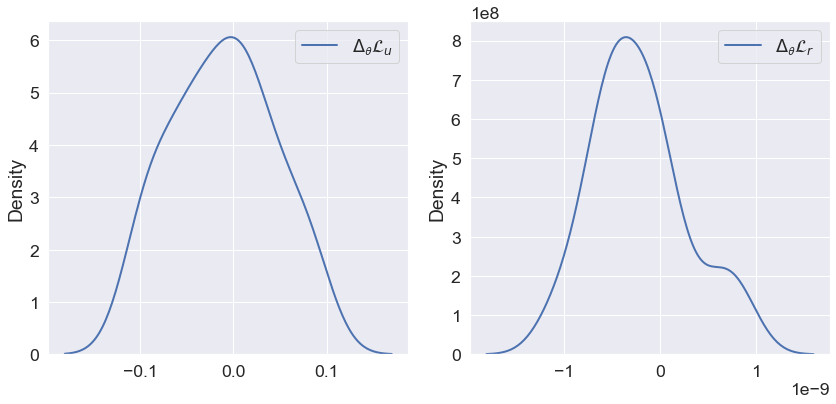

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(PINN_solver.gradients_log[0][1][0].numpy().flatten(), linewidth =2, ax = axs[0], 
            label = r'$\Delta_\mathcal{\theta}\mathcal{L}_u$')
axs[0].legend()


sns.kdeplot(PINN_solver.gradients_log[0][2][0].numpy().flatten(), linewidth =2, ax = axs[1], 
            label = r'$\Delta_\mathcal{\theta}\mathcal{L}_r$')

plt.tight_layout()
plt.legend()

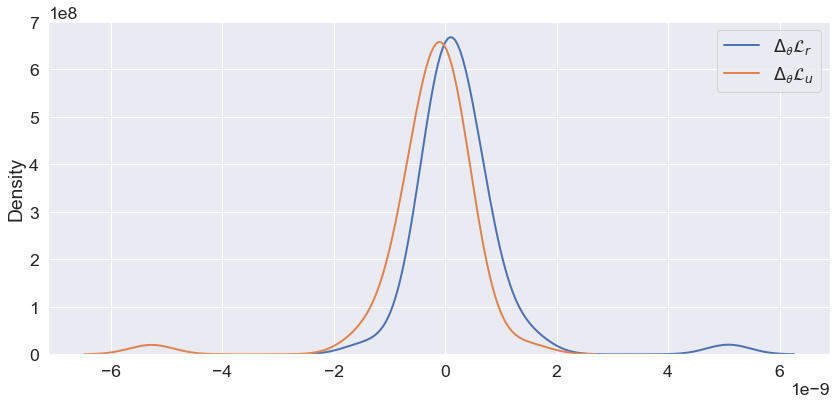

In [146]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

sns.kdeplot(PINN_solver.gradients_log[8][2][0].numpy().flatten(), ax = axs, linewidth =2,
            label = r'$\Delta_\mathcal{\theta}\mathcal{L}_r$')

sns.kdeplot(PINN_solver.gradients_log[8][1][0].numpy().flatten(), linewidth =2, ax = axs, 
            label = r'$\Delta_\mathcal{\theta}\mathcal{L}_u$')

plt.tight_layout()
plt.legend()

### Compare model prediction with and without PCGrad

In [147]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

In [148]:
######################################################################################
# Test data for validating the model predictions
n_star = 5000+1
x_star = np.linspace(lb, ub, n_star) #N_star = x_star.shape[0] 
x_star_normalized = (x_star-mu)/sigma

In [149]:
y_pred = PINN_solver.model(x_star_normalized)
y_pred_pcgrad = PINN_solver_pcgrad.model(x_star_normalized)

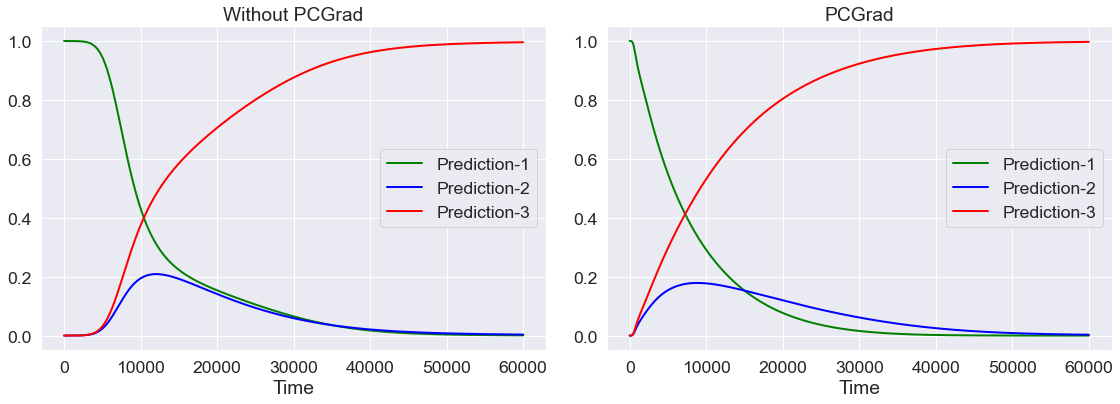

In [150]:
f, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'Prediction-1', color = 'green', linewidth = 2, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'Prediction-2', color = 'blue', linewidth = 2, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'Prediction-3', color = 'red', linewidth = 2, ax=ax[0])

ax[0].set_xlabel("Time")
ax[0].set_title("Without PCGrad")

sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'Prediction-1', color = 'green', linewidth = 2, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'Prediction-2', color = 'blue', linewidth = 2, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'Prediction-3', color = 'red', linewidth = 2, ax=ax[1])

ax[1].set_xlabel("Time")
ax[1].set_title("PCGrad")

plt.tight_layout()
plt.savefig("comparison.pdf")

### Visualize loss function

In [151]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

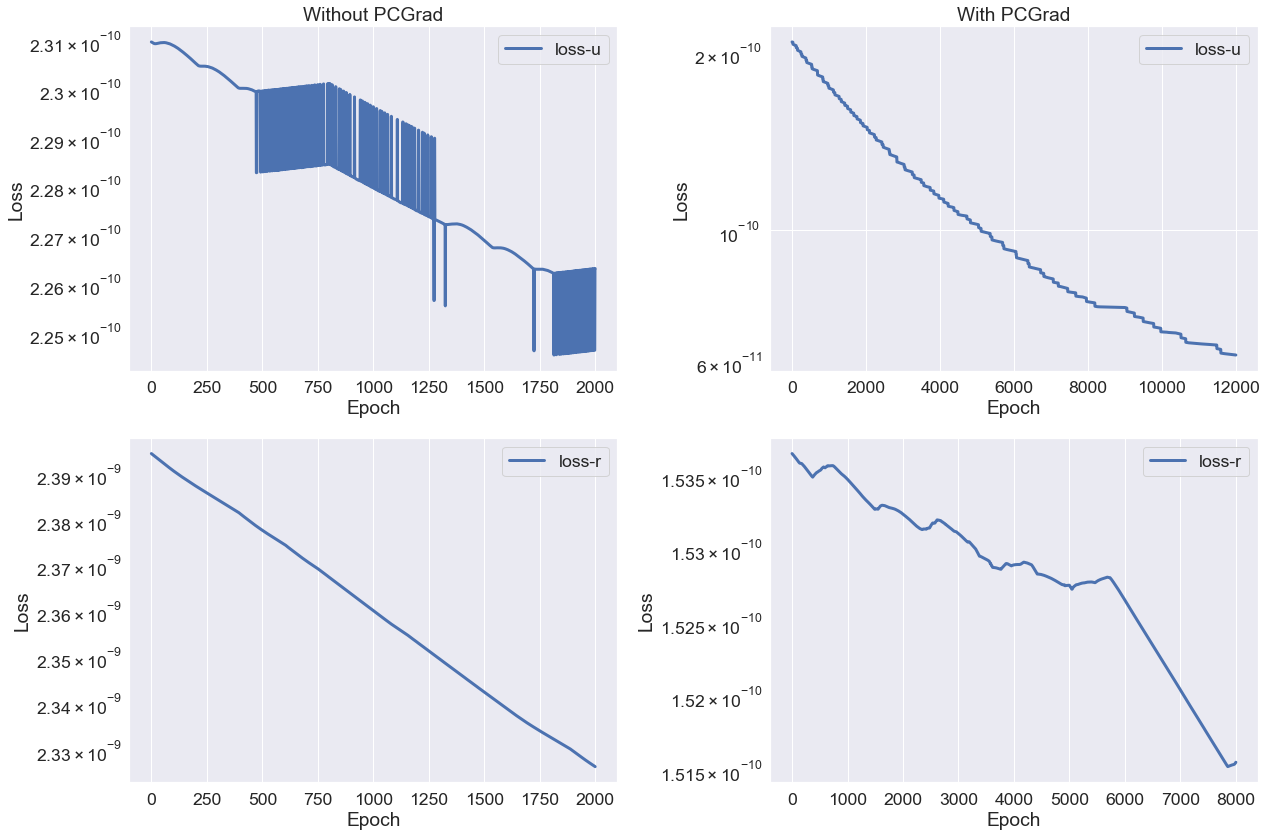

In [152]:
f, ax = plt.subplots(2, 2, figsize=(18, 12))

sns.lineplot(x = range(len(pinn_loss_log[40000:42000, 0])), y = pinn_loss_log[40000:42000, 0], linewidth = 3, label='loss-u',
            ax = ax[0][0])
ax[0][0].set_title("Without PCGrad")
ax[0][0].set(yscale="log")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Loss")


sns.lineplot(x = range(len(pinn_pcgrad_loss_log[30000:42000, 0])), y = pinn_pcgrad_loss_log[30000:42000, 0], 
             linewidth = 3, label='loss-u', ax = ax[0][1])

ax[0][1].set_title("With PCGrad")
ax[0][1].set(yscale="log")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Loss")


sns.lineplot(x = range(len(pinn_loss_log[80000:82000, 1])), y = pinn_loss_log[80000:82000, 1], linewidth = 3, label='loss-r',
            ax = ax[1][0])

ax[1][0].set(yscale="log")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Loss")


sns.lineplot(x = range(len(pinn_pcgrad_loss_log[40000:48000, 1])), y = pinn_pcgrad_loss_log[40000:48000, 1], 
             linewidth = 3, label='loss-r', ax = ax[1][1])

ax[1][1].set(yscale="log")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Loss")


plt.tight_layout()
plt.savefig('loss.pdf')

### 

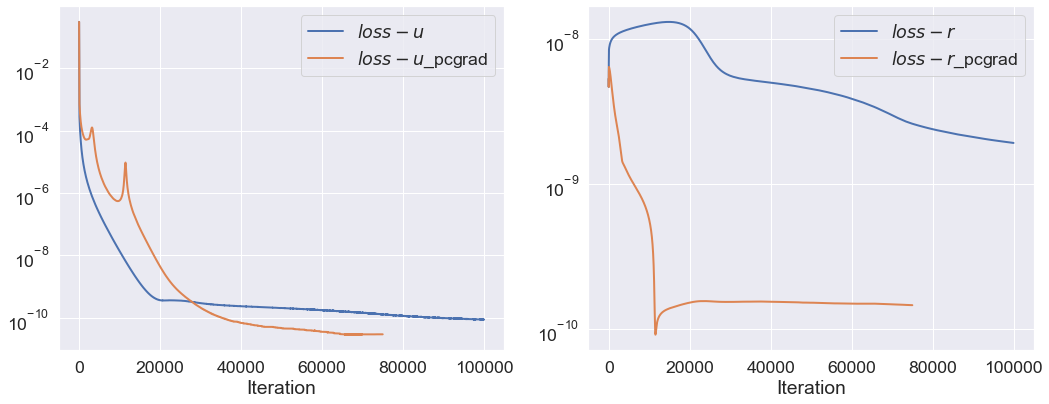

In [157]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 2, label = "$loss-u$", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 2, 
             label = "$loss-u$_pcgrad", ax = axes[0])
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration")

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = pinn_loss_log[:, 1],  linewidth = 2, 
             label = "$loss-r$", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = pinn_pcgrad_loss_log[:, 1],  linewidth = 2, 
             label = "$loss-r$_pcgrad", ax = axes[1])
axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.savefig("performance_comparison.pdf")